<div align="center">

# **Modelo de Detección y Conteo de Mamíferos Africanos a partir de Imágenes Aéreas**  

### *Proyecto de Grado - Maestría en Inteligencia Artificial, Universidad de los Andes*  


**Autor:** Grupo 2  
**Asesor:** Isai Daniel Chacón Silva *(Microsoft AI for Good)*  
**Institución:** Proyecto Guacamaya *(CINFONIA)*  
**Año:** 2025  


</div>

## Descripción general

Este cuaderno documenta el proceso completo de **entrenamiento y evaluación del modelo HerdNet**, diseñado para la **detección y conteo de mamíferos africanos** en imágenes aéreas, utilizando el *dataset* **ULiège**.  

El objetivo es identificar y contabilizar seis especies con precisión, incluso en condiciones de **alta densidad, oclusión y variabilidad de escala**:  

| Especie | Nombre común | Nombre científico / Inglés |
|:--|:--|:--|
| 🐃 | **Búfalo**  | *Buffalo* |
| 🐘 | **Elefante** | *Elephant* |
| 🦌 | **Kob** | *Kob* |
| 🦬 | **Topi (Alcelaphinae)** | *Topi / Hartebeest* |
| 🐗 | **Facóquero** | *Warthog* |
| 🦓 | **Waterbuck** | *Waterbuck* |


###  Referencia técnica

Los experimentos y scripts se fundamentan en el cuaderno de referencia del repositorio oficial de **HerdNet**, disponible en:  
[https://colab.research.google.com/github/Alexandre-Delplanque/HerdNet/blob/main/notebooks/demo-training-testing-herdnet.ipynb](https://colab.research.google.com/github/Alexandre-Delplanque/HerdNet/blob/main/notebooks/demo-training-testing-herdnet.ipynb)

</div>

La siguiente estructura organiza todos los componentes necesarios para entrenar y evaluar el modelo HerdNet. Incluye los archivos COCO originales, sus versiones convertidas a CSV, las imágenes por conjunto, los modelos preentrenados y los resultados de entrenamiento.

```
/content/drive/MyDrive/HerdNet/
│
├── data/
│   ├── coco/                        # Archivos de anotaciones originales en formato COCO
│   │   ├── train_annotations.json
│   │   ├── val_annotations.json
│   │   └── test_annotations.json
│   │
│   ├── csv/                         # Archivos convertidos a CSV (formato usado por CSVDataset; se generan en la fase de Datasets)
│   │   ├── train_annotations.csv
│   │   ├── val_annotations.csv
│   │   └── test_annotations.csv
│   │
│   └── images/                      # Carpeta raíz con las imágenes divididas por conjunto
│       ├── train/
│       ├── val/
│       └── test/
│
├── model/                           # Pesos preentrenados y checkpoints del modelo
│   └── 20220413_HerdNet_General_dataset_2022.pth
│
├── outputs/                         # Resultados de entrenamiento, métricas y logs generados por este script

```

# Hiperparámetros, configuración general y rutas



Define los parámetros globales del proyecto, las rutas de trabajo en Google Drive y los valores base que controlan el entrenamiento, el tamaño de los parches, la tasa de aprendizaje y otros elementos del modelo. De igual modo, rutas a imágenes y anotaciones.

### Rutas de anotaciones e imágenes

Especifica las ubicaciones de los archivos de anotaciones (COCO JSON y CSV) y las carpetas donde se encuentran las imágenes de entrenamiento, validación y prueba.

In [1]:
from pathlib import Path

# ============================================================
# CONFIGURACIÓN DE RUTAS PRINCIPALES
# ============================================================

# Definir la ruta base principal (ajustar según el entorno: Drive o local)
BASE_DIR = Path("/content/drive/MyDrive/HerdNet")

# ============================================================
# RUTAS DE IMÁGENES Y ANOTACIONES (COCO JSON)
# ============================================================

# Rutas de los archivos de anotaciones en formato COCO
TRAIN_ANN_FILE = BASE_DIR / "data" / "coco" / "train" / "train_annotations.json"
VAL_ANN_FILE = BASE_DIR / "data" / "coco" / "val" / "val_annotations.json"
TEST_ANN_FILE = BASE_DIR / "data" / "coco" / "test" / "test_annotations.json"

# Rutas de las carpetas de imágenes correspondientes a cada conjunto
TRAIN_IMG_DIR = BASE_DIR / "data" / "images" / "train"
VAL_IMG_DIR = BASE_DIR / "data" / "images" / "val"
TEST_IMG_DIR = BASE_DIR / "data" / "images" / "test"

# ============================================================
# RUTAS DE ANOTACIONES CONVERTIDAS A CSV
# ============================================================

# Definir las rutas de salida en formato CSV
TRAIN_CSV = BASE_DIR / "data" / "csv" / "train" / "train_annotations.csv"
VAL_CSV = BASE_DIR / "data" / "csv" / "val" / "val_annotations.csv"
TEST_CSV = BASE_DIR / "data" / "csv" / "test" / "test_annotations.csv"

# ============================================================
# VALIDACIÓN DE CONFIGURACIÓN (opcional)
# ============================================================

print("[INFO] Archivos de anotaciones e imágenes: \n")
print("\n Train set:")
print(f"Archivo JSON de entrenamiento: {TRAIN_ANN_FILE}")
print(f"Carpeta de imágenes de entrenamiento: {TRAIN_IMG_DIR}")
print(f"Archivo CSV de entrenamiento: {TRAIN_CSV}")
print("\n Val set:")
print(f"Archivo JSON de validación: {VAL_ANN_FILE}")
print(f"Carpeta de imágenes de validación: {VAL_IMG_DIR}")
print(f"Archivo CSV de validación: {VAL_CSV}")
print("\n Test set:")
print(f"Archivo JSON de prueba: {TEST_ANN_FILE}")
print(f"Carpeta de imágenes de prueba: {TEST_IMG_DIR}")
print(f"Archivo CSV de prueba: {TEST_CSV}")

[INFO] Archivos de anotaciones e imágenes: 


 Train set:
Archivo JSON de entrenamiento: /content/drive/MyDrive/HerdNet/data/coco/train/train_annotations.json
Carpeta de imágenes de entrenamiento: /content/drive/MyDrive/HerdNet/data/images/train
Archivo CSV de entrenamiento: /content/drive/MyDrive/HerdNet/data/csv/train/train_annotations.csv

 Val set:
Archivo JSON de validación: /content/drive/MyDrive/HerdNet/data/coco/val/val_annotations.json
Carpeta de imágenes de validación: /content/drive/MyDrive/HerdNet/data/images/val
Archivo CSV de validación: /content/drive/MyDrive/HerdNet/data/csv/val/val_annotations.csv

 Test set:
Archivo JSON de prueba: /content/drive/MyDrive/HerdNet/data/coco/test/test_annotations.json
Carpeta de imágenes de prueba: /content/drive/MyDrive/HerdNet/data/images/test
Archivo CSV de prueba: /content/drive/MyDrive/HerdNet/data/csv/test/test_annotations.csv


### Configuración del modelo

Define los parámetros fundamentales de la arquitectura del modelo HerdNet, incluyendo el número de clases, el factor de reducción espacial y las dimensiones de entrada.

**Hiperparámetros principales a experimentar:**

* Tasa de aprendizaje (*learning rate*)
* Peso de decaimiento (*weight decay*)
* Superposición (*overlap*)
* Factor de reducción (*down ratio*)

In [2]:
# ============================================================
# CONFIGURACIÓN DE LOS DATA LOADERS DE HERDNET
# ============================================================

# Tamaño del lote (batch size). Ajustar según la memoria de la GPU disponible.
TAMANO_LOTE = 12  # Recomendado para VRAM entre 10 y 20 GB

# Tamaño del parche de entrada. Debe coincidir con el definido en el modelo HerdNet.
TAMANO_PARCHE = 512

# Número total de clases (incluye fondo). El modelo HerdNet requiere +1 por convención.
NUMERO_CLASES = 6 + 1

# Factor de reducción espacial utilizado durante la generación de mapas de densidad.
FACTOR_REDUCCION = 2

# ============================================================
# CONFIGURACIÓN DE ENTRENAMIENTO DEL MODELO HERDNET
# ============================================================

# Carpeta donde se guardarán los resultados, checkpoints y métricas
RUTA_SALIDA = "/content/drive/MyDrive/HerdNet/model/outputs"

# Overlap entre parches utilizados por el Stitcher
SUPERPOSICION = 160

# Radio de evaluación usado por PointsMetrics
RADIO_METRICA = 20

# Número total de épocas de entrenamiento
EPOCHS_TOTALES = 100

# Tasa de aprendizaje inicial (learning rate) - debe ser baja para preservar los pesos preentrenados
TASA_APRENDIZAJE = 1e-5

# Parámetro de regularización L2 (weight decay) - ayuda a reducir el sobreajuste
PESO_DECAY = 1e-4

# Número de iteraciones de calentamiento antes de iniciar el entrenamiento completo
ITERACIONES_CALENTAMIENTO = 100

# ============================================================
# CONFIGURACIÓN DEL MODELO PREENTRENADO
# ============================================================

# Ruta al archivo de pesos preentrenados de HerdNet (Opcional: Se entrenará desde DLA)
RUTA_MODELO_HERDNET = "/content/drive/MyDrive/HerdNet/model/20220413_HerdNet_General_dataset_2022.pth"

MODELO_PREENTRENADO_DLA = False

# ============================================================
# VALIDACIÓN DE CONFIGURACIÓN (opcional)
# ============================================================

print("[INFO] Configuración: \n")
print(f"Tamaño de lote: {TAMANO_LOTE}")
print(f"Tamaño de parche: {TAMANO_PARCHE}")
print(f"Número de clases (incluye fondo): {NUMERO_CLASES}")
print(f"Factor de reducción: {FACTOR_REDUCCION}")
print(f"Directorio de salida: {RUTA_SALIDA}")
print(f"Épocas totales: {EPOCHS_TOTALES}")
print(f"Tasa de aprendizaje: {TASA_APRENDIZAJE}")
print(f"Peso de decaimiento (weight decay): {PESO_DECAY}")
print(f"Iteraciones de calentamiento: {ITERACIONES_CALENTAMIENTO}")
print(f"Ruta del modelo preentrenado: {RUTA_MODELO_HERDNET}")
print(f"Entrenar desde DLA: {MODELO_PREENTRENADO_DLA}")

[INFO] Configuración: 

Tamaño de lote: 12
Tamaño de parche: 512
Número de clases (incluye fondo): 7
Factor de reducción: 2
Directorio de salida: /content/drive/MyDrive/HerdNet/model/outputs
Épocas totales: 100
Tasa de aprendizaje: 1e-05
Peso de decaimiento (weight decay): 0.0001
Iteraciones de calentamiento: 100
Ruta del modelo preentrenado: /content/drive/MyDrive/HerdNet/model/20220413_HerdNet_General_dataset_2022.pth
Entrenar desde DLA: False


# Instalaciones

Incluye las celdas necesarias para montar el entorno de trabajo en Google Colab, instalar dependencias y clonar repositorios requeridos por el modelo.

## Montar Disco Duro desde Google Drive

Conecta el entorno de ejecución de Google Colab con Google Drive, permitiendo el acceso directo a los datos, modelos preentrenados (por ejemplo, para fine-tuning) y resultados generados durante el entrenamiento.

In [3]:
# ============================================================
# LIBRERÍAS ESTÁNDAR
# ============================================================
import os
import logging
from IPython.display import clear_output

# ============================================================
# LIBRERÍAS DE TERCEROS
# ============================================================
from google.colab import drive


class GoogleDriveConnector:
    """
    GoogleDriveConnector
    --------------------
    Clase para montar Google Drive en un entorno de Google Colab.

    Propósito
    ----------
    Permite establecer una conexión con Google Drive desde Colab de forma
    controlada, con validación de parámetros, registro de eventos (logging)
    y limpieza visual del entorno tras la conexión.

    Parámetros
    ----------
    mount_path : str
        Ruta local donde se montará Google Drive (por defecto '/content/drive').

    verbose : bool, opcional
        Si es True, se habilita el registro mediante logging. Si es False,
        no se muestra ninguna salida ni registro (por defecto True).

    Métodos
    -------
    mount_drive():
        Monta Google Drive y registra el proceso.
    """

    def __init__(self, mount_path: str = "/content/drive", verbose: bool = True):
        """
        Inicializa la clase configurando el logger y validando la ruta de montaje.

        Parámetros
        ----------
        mount_path : str
            Ruta donde se montará Google Drive.

        verbose : bool
            Determina si se habilita el registro de eventos.

        Excepciones
        -----------
        ValueError:
            Si 'mount_path' no es una cadena válida o está vacía.
        """
        # Validar tipo y contenido del parámetro
        if not isinstance(mount_path, str) or not mount_path.strip():
            raise ValueError("El parámetro 'mount_path' debe ser una cadena no vacía.")

        # Asignar atributos de instancia
        self.mount_path = mount_path
        self.verbose = verbose

        # Configurar logger si está habilitado
        self.logger = logging.getLogger("GoogleDriveConnector")
        if self.verbose:
            self.logger.setLevel(logging.INFO)
            if not self.logger.handlers:
                handler = logging.StreamHandler()
                formatter = logging.Formatter(
                    "[%(asctime)s] [%(levelname)s] %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S",
                )
                handler.setFormatter(formatter)
                self.logger.addHandler(handler)
            self.logger.propagate = False
        else:
            self.logger.disabled = True

    def mount_drive(self) -> None:
        """
        Monta Google Drive en el entorno actual de Google Colab.

        Retorno
        -------
        None

        Excepciones
        -----------
        RuntimeError:
            Si ocurre un error durante el proceso de montaje.
        """
        # Registrar inicio del proceso de conexión
        if self.verbose:
            self.logger.info("Iniciando conexión con Google Drive...")

        # ------------------------------------------------------------
        # Nueva verificación: evitar conflicto si la ruta ya tiene archivos
        # ------------------------------------------------------------
        if os.path.exists(self.mount_path) and os.listdir(self.mount_path):
            if self.verbose:
                self.logger.warning(
                    f"La ruta '{self.mount_path}' ya contiene archivos. "
                    "Se asume que Google Drive ya está montado."
                )
            return

        try:
            # Montar Google Drive
            drive.mount(self.mount_path)

            # Limpiar salida visual del entorno
            clear_output(wait=True)

            # Confirmar éxito del proceso
            if self.verbose:
                self.logger.info("Google Drive montado correctamente.")
            else:
                print("Google Drive montado correctamente.")

        except Exception as e:
            # Manejar y registrar errores
            if self.verbose:
                self.logger.error(f"Error al montar Google Drive: {e}", exc_info=True)
            raise RuntimeError(f"No se pudo montar Google Drive: {e}") from e

# Conectar el Google Drive
CONNECTOR = GoogleDriveConnector(
    mount_path="/content/drive",
    verbose=True,
)

CONNECTOR.mount_drive()

[2025-10-27 18:01:59] [INFO] Google Drive montado correctamente.


## Instalación de librerías y repositorios

Instala las dependencias y paquetes personalizados necesarios para ejecutar HerdNet y sus componentes, asegurando compatibilidad con la versión utilizada del framework.

In [4]:
# ============================================================
# CONFIGURADOR DE ENTORNO HERDNET (COLAB O LOCAL)
# ============================================================

import os
import sys
import logging
import subprocess
from pathlib import Path
from IPython.display import clear_output

class ConfiguradorHerdNet:
    """
    Clase para configurar automáticamente el entorno de HerdNet,
    compatible tanto con Google Colab como con entornos locales.

    Propósito
    ----------
    Reproduce la instalación de HerdNet con detección de entorno,
    manejo de errores y registro de eventos mediante logging.

    Parámetros
    ----------
    base_dir : str, opcional
        Ruta donde se clonará el repositorio HerdNet.
        Por defecto: '/content/HerdNet' si se ejecuta en Colab,
        o './HerdNet' si se ejecuta localmente.
    verbose : bool, opcional
        Si es True, muestra información detallada del proceso.
    """

    def __init__(self, base_dir: str = None, verbose: bool = True):
        """Inicializa el configurador y detecta el entorno de ejecución."""
        # Detectar si se ejecuta en Colab
        self.is_colab = "google.colab" in sys.modules

        # Definir ruta base según entorno
        self.base_dir = Path(base_dir or ("/content/HerdNet" if self.is_colab else "./HerdNet"))

        # Configurar logging estándar
        logging.basicConfig(
            level=logging.INFO,
            format="[%(asctime)s] [%(levelname)s] %(message)s",
            datefmt="%Y-%m-%d %H:%M:%S",
            force=True
        )
        self.logger = logging.getLogger("ConfiguradorHerdNet")

        # Control de verbosidad
        self.verbose = verbose

    # ------------------------------------------------------------
    def _run_command(self, command: str):
        """
        Ejecuta un comando del sistema de forma segura.

        Parámetros
        ----------
        command : str
            Comando del sistema a ejecutar.

        Excepciones
        -----------
        subprocess.CalledProcessError
            Si el comando devuelve un error de ejecución.
        """
        try:
            result = subprocess.run(
                command,
                shell=True,
                check=True,
                text=True,
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE
            )
            if self.verbose and result.stdout.strip():
                self.logger.info(result.stdout.strip())
        except subprocess.CalledProcessError as e:
            self.logger.error(f"Error ejecutando comando: {command}")
            if e.stderr.strip():
                self.logger.error(e.stderr.strip())
            raise

    # ------------------------------------------------------------
    def verificar_gpu(self):
        """Verifica la disponibilidad de una GPU mediante nvidia-smi."""
        self.logger.info("Verificando GPU disponible...")
        try:
            self._run_command("nvidia-smi")
        except Exception:
            self.logger.warning("No se pudo verificar GPU. Puede que no exista o no esté disponible.")

    # ------------------------------------------------------------
    def instalar_dependencias(self):
        """
        Instala las dependencias necesarias según el entorno detectado.

        En Colab se instalan versiones recientes compatibles.
        En local se instalan las versiones exactas del paper HerdNet.
        """
        if self.is_colab:
            self.logger.info("Entorno detectado: Google Colab")
            self.logger.info("Instalando dependencias compatibles con Colab...")
            deps = (
                "albumentations fiftyone hydra-core opencv-python pandas pillow "
                "scikit-image scikit-learn scipy wandb"
            )
        else:
            self.logger.info("Entorno detectado: Local")
            self.logger.info("Instalando dependencias exactas del paper HerdNet...")
            deps = (
                "albumentations==1.0.3 fiftyone==0.14.3 hydra-core==1.1.0 "
                "opencv-python==4.5.1.48 pandas==1.2.3 pillow==8.2.0 "
                "scikit-image==0.18.1 scikit-learn==1.0.2 scipy==1.6.2 wandb==0.10.33"
            )

        cmd = f"{sys.executable} -m pip install {deps} -q"
        try:
            self._run_command(cmd)
        except Exception as e:
            self.logger.warning(f"Fallo parcial en instalación de dependencias: {e}")
            self.logger.warning("Continuando con el proceso...")

    # ------------------------------------------------------------
    def clonar_repo(self):
        """Clona e instala el repositorio HerdNet desde GitHub."""
        self.logger.info("Clonando repositorio HerdNet original...")
        if self.base_dir.exists():
            self.logger.info("El repositorio ya existe. Se omite la clonación.")
        else:
            self._run_command(f"git clone https://github.com/Alexandre-Delplanque/HerdNet {self.base_dir}")

        self._run_command(f"cd {self.base_dir} && {sys.executable} setup.py install -q")
        sys.path.append(str(self.base_dir))

    # ------------------------------------------------------------
    def limpiar_salida(self):
        """Limpia la salida si se ejecuta en Google Colab."""
        if self.is_colab:
            clear_output(wait=True)

    # ------------------------------------------------------------
    def configurar(self):
        """
        Ejecuta el flujo completo de configuración del entorno HerdNet.

        Incluye:
        - Verificación de GPU
        - Instalación de dependencias
        - Clonación del repositorio
        - Instalación local
        - Limpieza de salida (solo en Colab)
        """
        self.logger.info("Iniciando configuración del entorno HerdNet...")
        try:
            self.verificar_gpu()
            self.instalar_dependencias()
            self.clonar_repo()
            self.limpiar_salida()
            self.logger.info("Instalación completada correctamente y entorno listo.")
            print("Instalación completada correctamente y entorno listo.")
        except Exception as e:
            self.logger.error(f"Error durante la configuración: {e}")
            raise

configurador = ConfiguradorHerdNet(verbose=True)
configurador.configurar()

[2025-10-27 18:02:55] [INFO] Instalación completada correctamente y entorno listo.


Instalación completada correctamente y entorno listo.


# Datasets

Agrupa los procesos de conversión, visualización y carga de los conjuntos de datos utilizados en el entrenamiento y evaluación del modelo.

## Conversión desde COCO a CSV

Convierte las anotaciones del formato COCO JSON al formato CSV compatible con HerdNet, garantizando que las coordenadas, etiquetas y nombres de archivo se mantengan consistentes con lo que espera la librería de HerdNet.

In [5]:
import os
import json
import logging
import pandas as pd
from tqdm import tqdm

class ConversorCOCOaHerdNet:
    """
    ConversorCOCOaHerdNet
    ---------------------
    Clase para convertir anotaciones en formato COCO JSON al formato CSV
    utilizado por HerdNet.

    Propósito
    ----------
    Facilita la conversión de anotaciones de detección (cajas o puntos)
    al formato CSV compatible con HerdNet, incluyendo coordenadas y etiquetas.

    Parámetros
    ----------
    ruta_json : str
        Ruta al archivo COCO JSON con las anotaciones.
    carpeta_imagenes : str
        Carpeta donde se encuentran las imágenes del dataset.
    ruta_salida : str
        Ruta donde se guardará el CSV resultante.
    verbose : bool, opcional
        Si es True, muestra mensajes detallados del proceso.
    """

    def __init__(self, ruta_json: str, carpeta_imagenes: str, ruta_salida: str, verbose: bool = True):
        """Inicializa el conversor con las rutas y la configuración."""
        self.ruta_json = ruta_json
        self.carpeta_imagenes = carpeta_imagenes
        self.ruta_salida = ruta_salida
        self.verbose = verbose

        # Configurar logger único por instancia
        logger_name = f"ConversorCOCOaHerdNet.{id(self)}"
        self.logger = logging.getLogger(logger_name)
        self.logger.setLevel(logging.INFO if verbose else logging.WARNING)

        # Siempre eliminar handlers anteriores para evitar duplicaciones o silencios
        if self.logger.hasHandlers():
            self.logger.handlers.clear()

        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            "[%(asctime)s] [%(levelname)s] %(message)s",
            datefmt="%Y-%m-%d %H:%M:%S",
        )
        handler.setFormatter(formatter)
        self.logger.addHandler(handler)
        self.logger.propagate = False


        # Validar rutas iniciales
        self._validar_entradas()

    # ------------------------------------------------------------
    def _validar_entradas(self):
        """Verifica que las rutas de entrada sean válidas."""
        if not os.path.exists(self.ruta_json):
            raise FileNotFoundError(f"No se encontró el archivo de anotaciones: {self.ruta_json}")
        if not os.path.exists(self.carpeta_imagenes):
            raise FileNotFoundError(f"No se encontró la carpeta de imágenes: {self.carpeta_imagenes}")

    # ------------------------------------------------------------
    def _cargar_json(self) -> dict:
        """Carga el archivo COCO JSON de anotaciones."""
        self.logger.info("Cargando anotaciones COCO...")
        with open(self.ruta_json, "r", encoding="utf-8") as f:
            data = json.load(f)

        if "images" not in data or "annotations" not in data:
            raise ValueError("El archivo JSON no tiene las claves requeridas: 'images' o 'annotations'.")

        self.logger.info(f"Imágenes detectadas: {len(data['images'])}")
        self.logger.info(f"Anotaciones detectadas: {len(data['annotations'])}")
        return data

    # ------------------------------------------------------------
    def _extraer_registros(self, coco: dict) -> pd.DataFrame:
        """Procesa las anotaciones COCO y genera un DataFrame con el formato HerdNet."""
        categorias = coco.get("categories", [])
        mapa_categorias = {cat["id"]: cat["name"] for cat in categorias}
        self.logger.info(f"Categorías detectadas: {mapa_categorias}")

        id_a_nombre = {img["id"]: img["file_name"] for img in coco["images"]}
        id_a_base = {img["id"]: os.path.splitext(img["file_name"])[0] for img in coco["images"]}

        registros = []

        for anotacion in tqdm(coco["annotations"], desc="Procesando anotaciones"):
            id_imagen = anotacion.get("image_id")
            id_categoria = anotacion.get("category_id")
            bbox = anotacion.get("bbox", None)
            keypoints = anotacion.get("keypoints", None)

            # Calcular punto central de la anotación
            if bbox:
                x, y, w, h = bbox
                cx, cy = x + w / 2, y + h / 2
            elif keypoints and len(keypoints) >= 2:
                cx, cy = keypoints[0], keypoints[1]
            else:
                continue

            nombre_imagen = id_a_nombre.get(id_imagen)
            nombre_base = id_a_base.get(id_imagen)
            if nombre_imagen is None:
                continue

            registros.append({
                "images": nombre_imagen,
                "labels": id_categoria,
                "base_images": nombre_base,
                "x": cx,
                "y": cy,
            })

        df = pd.DataFrame(registros)
        if df.empty:
            raise ValueError("No se generaron registros válidos a partir del archivo COCO.")

        # Validar y limpiar etiquetas no numéricas o nulas
        df["labels"] = pd.to_numeric(df["labels"], errors="coerce")
        filas_invalidas = df[df["labels"].isna()]
        if not filas_invalidas.empty:
            self.logger.warning(f"Se eliminaron {len(filas_invalidas)} anotaciones sin etiqueta válida.")
            df = df.dropna(subset=["labels"])

        # Convertir etiquetas a enteros seguros
        df["labels"] = df["labels"].astype(int)

        # Log de resumen de clases
        etiquetas_unicas = df["labels"].unique().tolist()
        self.logger.info(f"Etiquetas detectadas: {etiquetas_unicas}")

        return df

    # ------------------------------------------------------------
    def convertir(self) -> pd.DataFrame:
        """
        Ejecuta el proceso completo de conversión COCO -> HerdNet CSV.

        Retorna
        -------
        pd.DataFrame
            DataFrame final con las columnas esperadas.
        """
        self.logger.info("Iniciando conversión COCO -> HerdNet...")

        # Cargar anotaciones
        coco = self._cargar_json()

        # Extraer y validar registros
        df = self._extraer_registros(coco)

        # Crear carpeta de salida
        os.makedirs(os.path.dirname(self.ruta_salida), exist_ok=True)

        # Guardar CSV limpio
        df.to_csv(self.ruta_salida, index=False, encoding="utf-8")

        self.logger.info(f"Conversión completada. CSV guardado en: {self.ruta_salida}")
        self.logger.info(f"Total de filas finales: {len(df)}")
        return df

[2025-10-27 18:11:10] [INFO] NumExpr defaulting to 2 threads.


In [6]:
# Conversión del conjunto de entrenamiento
CONVERSOR_TRAIN = ConversorCOCOaHerdNet(
    ruta_json=str(TRAIN_ANN_FILE),
    carpeta_imagenes=str(TRAIN_IMG_DIR),
    ruta_salida=str(TRAIN_CSV),
    verbose=True,
)
DF_TRAIN = CONVERSOR_TRAIN.convertir()
print(f"Entrenamiento: {TRAIN_CSV}  ({len(DF_TRAIN)} - Filas válidas - Anotaciones\n)")

[2025-10-27 18:11:16] [INFO] Iniciando conversión COCO -> HerdNet...
[2025-10-27 18:11:16] [INFO] Cargando anotaciones COCO...
[2025-10-27 18:11:17] [INFO] Imágenes detectadas: 4901
[2025-10-27 18:11:17] [INFO] Anotaciones detectadas: 25649
[2025-10-27 18:11:17] [INFO] Categorías detectadas: {1: 'Alcelaphinae', 2: 'Buffalo', 3: 'Kob', 4: 'Warthog', 5: 'Waterbuck', 6: 'Elephant'}
Procesando anotaciones: 100%|██████████| 25649/25649 [00:00<00:00, 318087.40it/s]
[2025-10-27 18:11:17] [INFO] Etiquetas detectadas: [6, 3, 4, 1, 2, 5]
[2025-10-27 18:11:19] [INFO] Conversión completada. CSV guardado en: /content/drive/MyDrive/HerdNet/data/csv/train/train_annotations.csv
[2025-10-27 18:11:19] [INFO] Total de filas finales: 25649


Entrenamiento: /content/drive/MyDrive/HerdNet/data/csv/train/train_annotations.csv  (25649 - Filas válidas - Anotaciones
)


In [7]:
# Conversión del conjunto de validación
CONVERSOR_VAL = ConversorCOCOaHerdNet(
    ruta_json=str(VAL_ANN_FILE),
    carpeta_imagenes=str(VAL_IMG_DIR),
    ruta_salida=str(VAL_CSV),
    verbose=True,
)
DF_VAL = CONVERSOR_VAL.convertir()
print(f"Validación:    {VAL_CSV}   ({len(DF_VAL)} - Filas válidas - Anotaciones\n)")

[2025-10-27 18:11:19] [INFO] Iniciando conversión COCO -> HerdNet...
[2025-10-27 18:11:19] [INFO] Cargando anotaciones COCO...
[2025-10-27 18:11:19] [INFO] Imágenes detectadas: 111
[2025-10-27 18:11:19] [INFO] Anotaciones detectadas: 978
[2025-10-27 18:11:19] [INFO] Categorías detectadas: {1: 'Alcelaphinae', 2: 'Buffalo', 3: 'Kob', 4: 'Warthog', 5: 'Waterbuck', 6: 'Elephant'}
Procesando anotaciones: 100%|██████████| 978/978 [00:00<00:00, 825524.11it/s]
[2025-10-27 18:11:19] [INFO] Etiquetas detectadas: [4, 2, 1, 3, 5, 6]
[2025-10-27 18:11:20] [INFO] Conversión completada. CSV guardado en: /content/drive/MyDrive/HerdNet/data/csv/val/val_annotations.csv
[2025-10-27 18:11:20] [INFO] Total de filas finales: 978


Validación:    /content/drive/MyDrive/HerdNet/data/csv/val/val_annotations.csv   (978 - Filas válidas - Anotaciones
)


In [8]:
# Conversión del conjunto de prueba
CONVERSOR_TEST = ConversorCOCOaHerdNet(
    ruta_json=str(TEST_ANN_FILE),
    carpeta_imagenes=str(TEST_IMG_DIR),
    ruta_salida=str(TEST_CSV),
    verbose=True,
)
DF_TEST = CONVERSOR_TEST.convertir()
print(f"Prueba:        {TEST_CSV}  ({len(DF_TEST)} - Filas válidas - Anotaciones)\n")

[2025-10-27 18:11:20] [INFO] Iniciando conversión COCO -> HerdNet...
[2025-10-27 18:11:20] [INFO] Cargando anotaciones COCO...
[2025-10-27 18:11:21] [INFO] Imágenes detectadas: 258
[2025-10-27 18:11:21] [INFO] Anotaciones detectadas: 2299
[2025-10-27 18:11:21] [INFO] Categorías detectadas: {1: 'Alcelaphinae', 2: 'Buffalo', 3: 'Kob', 4: 'Warthog', 5: 'Waterbuck', 6: 'Elephant'}
Procesando anotaciones: 100%|██████████| 2299/2299 [00:00<00:00, 1013847.64it/s]
[2025-10-27 18:11:21] [INFO] Etiquetas detectadas: [3, 2, 4, 1, 5, 6]
[2025-10-27 18:11:21] [INFO] Conversión completada. CSV guardado en: /content/drive/MyDrive/HerdNet/data/csv/test/test_annotations.csv
[2025-10-27 18:11:21] [INFO] Total de filas finales: 2299


Prueba:        /content/drive/MyDrive/HerdNet/data/csv/test/test_annotations.csv  (2299 - Filas válidas - Anotaciones)



## Visualización de imágenes de los splits con sus anotaciones

Muestra ejemplos aleatorios de las imágenes de entrenamiento, validación y prueba junto con sus puntos de anotación, permitiendo verificar visualmente la integridad de los datos (correspondencia).

In [9]:
import os
import random
import logging
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image


class VisualizadorEjemplosSplits:
    """
    VisualizadorEjemplosSplits
    --------------------------
    Visualiza ejemplos aleatorios desde los archivos CSV de anotaciones
    de HerdNet para cada división del conjunto de datos (train, val, test).

    Propósito
    ----------
    Permite verificar visualmente que la conversión COCO → HerdNet se haya
    realizado correctamente, comprobando que las anotaciones (x, y) estén
    alineadas con el contenido real de las imágenes.

    Parámetros
    ----------
    rutas_csv : dict
        Diccionario con las rutas de los CSV de anotaciones. Debe contener
        las claves "train", "val" y "test".
    rutas_img : dict
        Diccionario con las rutas de las carpetas de imágenes
        correspondientes a cada split.
    muestras_por_split : int, opcional
        Número de imágenes a visualizar por cada conjunto (por defecto 6).
    verbose : bool, opcional
        Si es True, muestra mensajes detallados mediante logging.
    """

    def __init__(self, rutas_csv: dict, rutas_img: dict, muestras_por_split: int = 6, verbose: bool = True):
        """Inicializa el visualizador con las rutas y la configuración."""
        self.rutas_csv = rutas_csv
        self.rutas_img = rutas_img
        self.muestras_por_split = muestras_por_split
        self.verbose = verbose

        # Configurar logger único por instancia
        logger_name = f"VisualizadorEjemplosSplits.{id(self)}"
        self.logger = logging.getLogger(logger_name)
        self.logger.setLevel(logging.INFO if verbose else logging.WARNING)

        if self.logger.hasHandlers():
            self.logger.handlers.clear()

        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            "[%(asctime)s] [%(levelname)s] %(message)s",
            datefmt="%Y-%m-%d %H:%M:%S",
        )
        handler.setFormatter(formatter)
        self.logger.addHandler(handler)
        self.logger.propagate = False

        # Validar rutas de entrada
        self._validar_entradas()

    # ------------------------------------------------------------
    def _validar_entradas(self):
        """Valida que todas las rutas a CSV e imágenes existan."""
        for split, ruta_csv in self.rutas_csv.items():
            if not os.path.exists(ruta_csv):
                raise FileNotFoundError(f"No se encontró el CSV del conjunto '{split}': {ruta_csv}")

        for split, ruta_img in self.rutas_img.items():
            if not os.path.exists(ruta_img):
                raise FileNotFoundError(f"No se encontró la carpeta de imágenes del conjunto '{split}': {ruta_img}")

    # ------------------------------------------------------------
    def _cargar_split(self, split: str) -> pd.DataFrame:
        """Carga las anotaciones del CSV correspondiente al split indicado."""
        self.logger.info(f"Cargando anotaciones del conjunto '{split}'...")
        df = pd.read_csv(self.rutas_csv[split])

        if df.empty:
            raise ValueError(f"El archivo CSV del conjunto '{split}' está vacío.")

        columnas_requeridas = {"images", "x", "y"}
        faltantes = columnas_requeridas - set(df.columns)
        if faltantes:
            raise ValueError(f"El CSV '{split}' no contiene las columnas requeridas: {faltantes}")

        return df

    # ------------------------------------------------------------
    def _mostrar_ejemplos_split(self, split: str, df: pd.DataFrame, carpeta_img: str):
        """Muestra visualmente ejemplos aleatorios para un split específico."""
        self.logger.info(f"Visualizando ejemplos del conjunto '{split}'...")

        muestras = df["images"].drop_duplicates().sample(
            n=min(self.muestras_por_split, df["images"].nunique()),
            random_state=42,
        )

        num_muestras = len(muestras)
        columnas = 3
        filas = (num_muestras + columnas - 1) // columnas

        fig, axes = plt.subplots(filas, columnas, figsize=(15, 5 * filas))
        axes = axes.flatten()

        for i, nombre_img in enumerate(muestras):
            ruta_img = Path(carpeta_img) / nombre_img
            if not ruta_img.exists():
                self.logger.warning(f"No se encontró la imagen: {ruta_img}")
                continue

            imagen = Image.open(ruta_img).convert("RGB")
            anotaciones = df[df["images"] == nombre_img]

            axes[i].imshow(imagen)
            axes[i].set_title(f"{split.upper()} - {nombre_img}", fontsize=10)
            axes[i].axis("off")

            axes[i].scatter(
                anotaciones["x"],
                anotaciones["y"],
                s=20,
                c="red",
                alpha=0.7,
                marker="o",
                label="anotaciones",
            )
            axes[i].legend(loc="lower right", fontsize=8)

        # Ocultar ejes no usados si hay menos imágenes que subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

    # ------------------------------------------------------------
    def visualizar(self) -> dict:
        """
        Carga y visualiza ejemplos aleatorios de cada conjunto (train, val, test).

        Retorna
        -------
        dict
            Diccionario con los DataFrames de cada conjunto visualizado.
        """
        self.logger.info("Iniciando verificación visual de los conjuntos...")
        resultados = {}

        for split in ["train", "val", "test"]:
            try:
                df = self._cargar_split(split)
                resultados[split] = df
                self._mostrar_ejemplos_split(split, df, self.rutas_img[split])
            except Exception as e:
                self.logger.error(f"Error al visualizar el conjunto '{split}': {e}", exc_info=True)

        self.logger.info("Visualización completada correctamente.")
        return resultados

[2025-10-27 18:11:24] [INFO] Iniciando verificación visual de los conjuntos...
[2025-10-27 18:11:24] [INFO] Cargando anotaciones del conjunto 'train'...
[2025-10-27 18:11:24] [INFO] Visualizando ejemplos del conjunto 'train'...


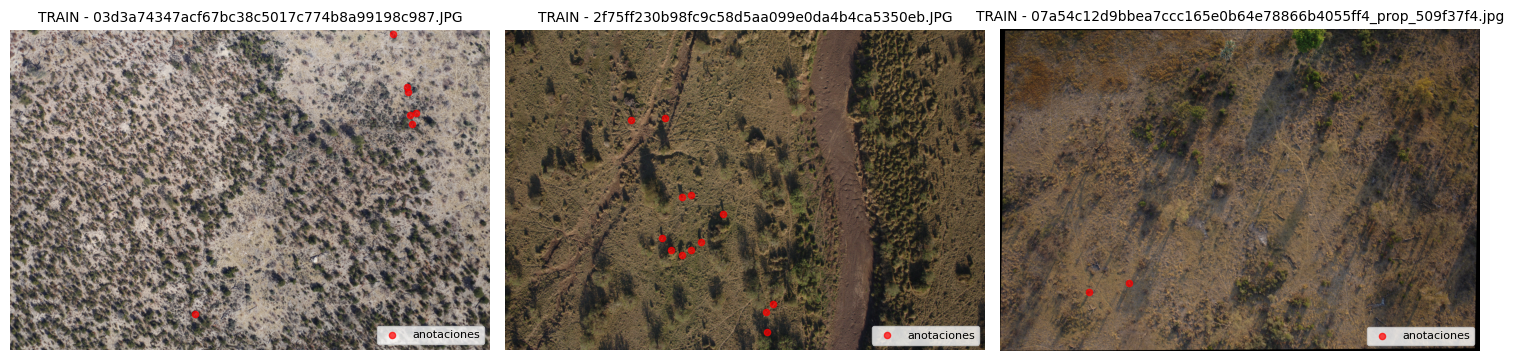

[2025-10-27 18:11:48] [INFO] Cargando anotaciones del conjunto 'val'...
[2025-10-27 18:11:48] [INFO] Visualizando ejemplos del conjunto 'val'...


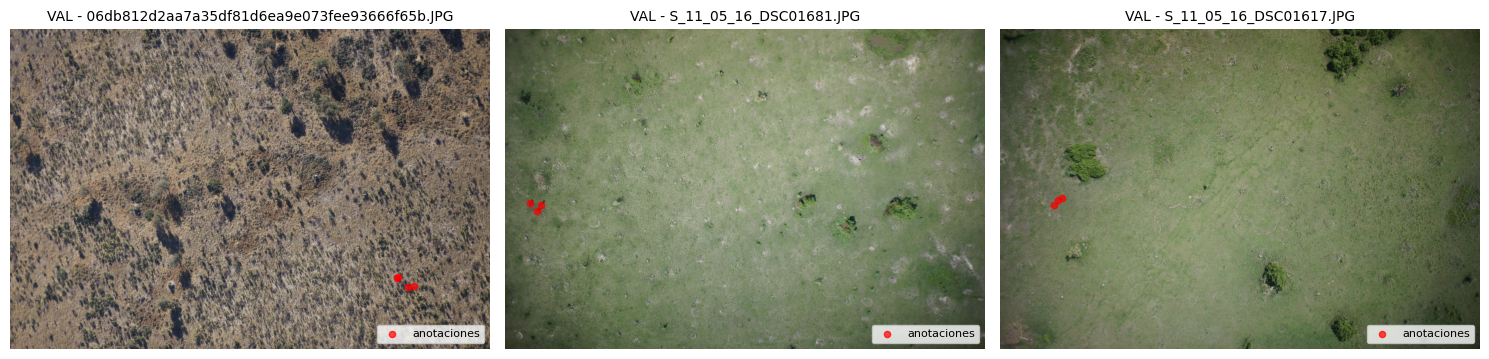

[2025-10-27 18:11:55] [INFO] Cargando anotaciones del conjunto 'test'...
[2025-10-27 18:11:55] [INFO] Visualizando ejemplos del conjunto 'test'...


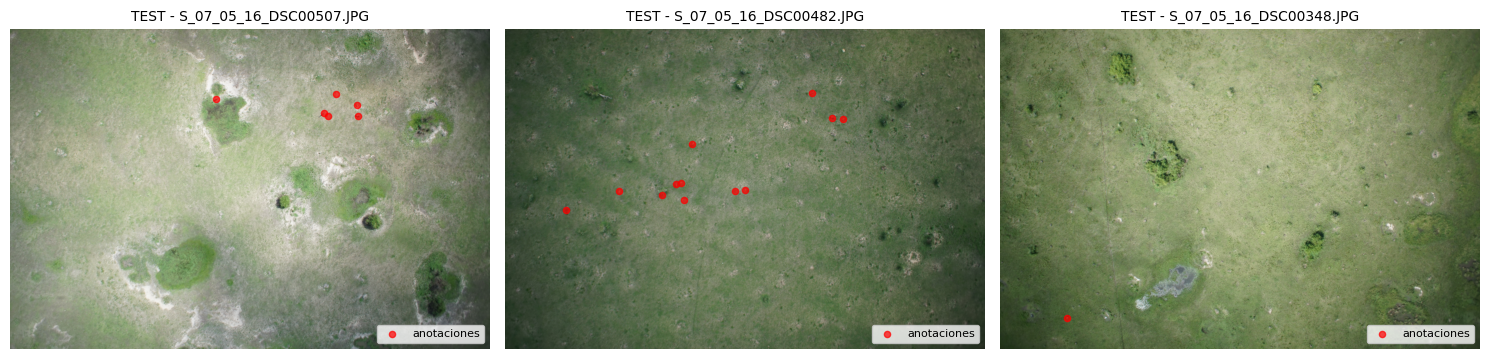

[2025-10-27 18:12:02] [INFO] Visualización completada correctamente.


{'train':                                              images  labels  \
 0      1a849a7b7d3ed837ac2a4b187b74f21dcc7de0d8.JPG       6   
 1                           S_09_05_16_DSC00578.JPG       3   
 2                           L_09_05_16_DSC10150.JPG       3   
 3                           L_07_05_16_DSC00553.JPG       4   
 4      1a849a7b7d3ed837ac2a4b187b74f21dcc7de0d8.JPG       6   
 ...                                             ...     ...   
 25644      S_08_05_16_DSC00628_S3_zoom_531e1602.jpg       5   
 25645      S_08_05_16_DSC00628_S3_zoom_531e1602.jpg       5   
 25646      S_08_05_16_DSC00628_S3_zoom_531e1602.jpg       5   
 25647      S_08_05_16_DSC00628_S3_zoom_531e1602.jpg       5   
 25648      S_08_05_16_DSC00628_S3_zoom_531e1602.jpg       5   
 
                                     base_images       x       y  
 0      1a849a7b7d3ed837ac2a4b187b74f21dcc7de0d8  1101.0  2090.5  
 1                           S_09_05_16_DSC00578   485.5  2109.0  
 2                  

In [10]:
# Visualización de ejemplos de imágenes con anotaciones
VISUALIZADOR = VisualizadorEjemplosSplits(
    rutas_csv={
        "train": str(TRAIN_CSV),
        "val": str(VAL_CSV),
        "test": str(TEST_CSV),
    },
    rutas_img={
        "train": str(TRAIN_IMG_DIR),
        "val": str(VAL_IMG_DIR),
        "test": str(TEST_IMG_DIR),
    },
    muestras_por_split=3,
    verbose=True,
)

VISUALIZADOR.visualizar()

## Dataloaders para el modelo

Crea los DataLoaders de HerdNet sin aplicar aumentaciones (ya se hizo previamente), verificando que las imágenes y anotaciones se carguen correctamente y cumplan con las dimensiones requeridas por la arquitectura.

In [12]:
import os
import math
import logging
import pandas as pd
from tqdm import tqdm
from PIL import ImageFile
import torch
from torch.utils.data import DataLoader
from animaloc.datasets import CSVDataset
from animaloc.data.transforms import MultiTransformsWrapper, DownSample, PointsToMask, FIDT


class DataLoadersHerdNet:
    """
    DataLoadersHerdNet
    ------------------
    Crea datasets y dataloaders de entrenamiento, validación y prueba
    para HerdNet, ajustando automáticamente las transformaciones
    según si se usa o no el modelo DLA preentrenado.
    """

    def __init__(
        self,
        train_csv,
        val_csv,
        test_csv,
        train_img_dir,
        val_img_dir,
        test_img_dir,
        num_classes,
        down_ratio,
        batch_size=4,
        patch_size=512,
        update_csv=False,
        verbose=True,
        modelo_preentrenado_dla=False,
        metric_radius_base=25,
    ):
        # Parámetros principales
        self.train_csv = train_csv
        self.val_csv = val_csv
        self.test_csv = test_csv
        self.train_img_dir = train_img_dir
        self.val_img_dir = val_img_dir
        self.test_img_dir = test_img_dir
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.update_csv = update_csv
        self.verbose = verbose
        self.modelo_preentrenado_dla = modelo_preentrenado_dla

        # Ajustes automáticos según modo
        if modelo_preentrenado_dla:
            self.down_ratio = 16
            self.metric_radius = metric_radius_base / 16
            self.use_points_to_mask = False
            self.stitcher_up = True
            self.stitcher_reduction = "mean"
        else:
            self.down_ratio = down_ratio
            self.metric_radius = metric_radius_base
            self.use_points_to_mask = True
            self.stitcher_up = False
            self.stitcher_reduction = "sum"

        # Tamaño ajustado
        self.padded_size = int(math.ceil(patch_size / 32) * 32)

        # Logger
        logger_name = f"DataLoadersHerdNet.{id(self)}"
        self.logger = logging.getLogger(logger_name)
        self.logger.setLevel(logging.INFO if verbose else logging.WARNING)
        if self.logger.hasHandlers():
            self.logger.handlers.clear()
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            "[%(asctime)s] [%(levelname)s] %(message)s",
            datefmt="%Y-%m-%d %H:%M:%S",
        )
        handler.setFormatter(formatter)
        self.logger.addHandler(handler)
        self.logger.propagate = False

    # ------------------------------------------------------------
    def _recortar_coordenadas_csv(self, csv_path, img_dir):
        df = pd.read_csv(csv_path)
        corregidos = 0
        EPS = 1e-3
        size_cache = {}

        for i, row in tqdm(df.iterrows(), total=len(df),
                           desc=f"Verificando {os.path.basename(csv_path)}",
                           ncols=100):
            img_path = os.path.join(img_dir, row["images"])
            if not os.path.exists(img_path):
                continue

            if img_path not in size_cache:
                try:
                    parser = ImageFile.Parser()
                    with open(img_path, "rb") as f:
                        while True:
                            chunk = f.read(1024)
                            if not chunk:
                                break
                            parser.feed(chunk)
                            if parser.image:
                                size_cache[img_path] = parser.image.size
                                break
                    if img_path not in size_cache:
                        size_cache[img_path] = None
                except Exception:
                    size_cache[img_path] = None

            size = size_cache[img_path]
            if not size:
                continue

            w, h = size
            x_new = min(max(row["x"], 0 + EPS), w - 1 - EPS)
            y_new = min(max(row["y"], 0 + EPS), h - 1 - EPS)

            if x_new != row["x"] or y_new != row["y"]:
                df.at[i, "x"], df.at[i, "y"] = x_new, y_new
                corregidos += 1

        df.to_csv(csv_path, index=False)
        self.logger.info(f"[INFO] {os.path.basename(csv_path)}: coordenadas corregidas = {corregidos}")

    # ------------------------------------------------------------
    @staticmethod
    def herdnet_collate_fn(batch):
        batch = [b for b in batch if b is not None]
        imgs, targets = [], []

        for img, target in batch:
            imgs.append(img)
            if isinstance(target, dict):
                clean_target = {k: v for k, v in target.items() if isinstance(v, torch.Tensor)}
                targets.append(clean_target)
            elif isinstance(target, (list, tuple)):
                targets.append(tuple(t for t in target if isinstance(t, torch.Tensor)))
            elif isinstance(target, torch.Tensor):
                targets.append(target)

        imgs = torch.stack(imgs, dim=0)
        if isinstance(targets[0], dict):
            keys = targets[0].keys()
            targets = {k: torch.stack([t[k] for t in targets], dim=0) for k in keys}
        elif isinstance(targets[0], tuple):
            targets = tuple(torch.stack([t[i] for t in targets], dim=0) for i in range(len(targets[0])))
        else:
            targets = torch.stack(targets, dim=0)
        return imgs, targets

    # ------------------------------------------------------------
    def _obtener_transformaciones_basicas(self):
        import albumentations as A
        return [
            A.Resize(height=self.padded_size, width=self.padded_size),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225), p=1.0)
        ]

    # ------------------------------------------------------------
    def crear_dataloaders(self):
        self.logger.info("[INFO] Creando DataLoaders de HerdNet (sin augmentaciones)...")
        self.logger.info(f"[INFO] Tamaño ajustado: {self.padded_size}x{self.padded_size}")

        if self.update_csv:
            self.logger.info("[INFO] Verificando coordenadas fuera de rango (solo en train)...")
            self._recortar_coordenadas_csv(self.train_csv, self.train_img_dir)

        # ------------------------------------------------------------
        # 🔹 Definir transformaciones finales (entrenamiento)
        # ------------------------------------------------------------
        # Siempre deben incluir FIDT y PointsToMask, incluso con DLA
        end_transforms_train = [
            MultiTransformsWrapper([
                FIDT(num_classes=self.num_classes, down_ratio=self.down_ratio),
                PointsToMask(
                    radius=2,
                    num_classes=self.num_classes,
                    squeeze=True,
                    down_ratio=int(self.patch_size // 16),
                ),
            ])
        ]

        # ------------------------------------------------------------
        # 🔹 Crear datasets
        # ------------------------------------------------------------
        train_dataset = CSVDataset(
            csv_file=self.train_csv,
            root_dir=self.train_img_dir,
            albu_transforms=self._obtener_transformaciones_basicas(),
            end_transforms=end_transforms_train,
        )

        val_dataset = CSVDataset(
            csv_file=self.val_csv,
            root_dir=self.val_img_dir,
            albu_transforms=self._obtener_transformaciones_basicas(),
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )

        test_dataset = CSVDataset(
            csv_file=self.test_csv,
            root_dir=self.test_img_dir,
            albu_transforms=self._obtener_transformaciones_basicas(),
            end_transforms=[DownSample(down_ratio=self.down_ratio, anno_type="point")],
        )

        # ------------------------------------------------------------
        # 🔹 Crear DataLoaders
        # ------------------------------------------------------------
        self.train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=self.herdnet_collate_fn
        )
        self.val_loader = DataLoader(
            val_dataset, batch_size=1, shuffle=False, collate_fn=self.herdnet_collate_fn
        )
        self.test_loader = DataLoader(
            test_dataset, batch_size=1, shuffle=False, collate_fn=self.herdnet_collate_fn
        )

        # ------------------------------------------------------------
        # 🔹 Log resumen
        # ------------------------------------------------------------
        self.logger.info(
            f"[INFO] Datasets listos: {len(train_dataset)} train / {len(val_dataset)} val / {len(test_dataset)} test."
        )
        self.logger.info(f"[INFO] down_ratio={self.down_ratio}, use_points_to_mask=True (for HerdNet dual head)")

        return self.train_loader, self.val_loader, self.test_loader

    # ------------------------------------------------------------
    def get_active_constants(self):
        """
        Retorna las constantes activas que definen el modo de entrenamiento.
        Estas se usan para mantener coherencia entre DataLoaders, Stitcher y Métricas.
        """
        return {
            "FACTOR_REDUCCION": self.down_ratio,
            "RADIO_METRICA": 25,
            "SUPERPOSICION": 160,
            "STITCHER_UP": False,
            "STITCHER_REDUCTION": "mean",
            "PATCH_SIZE": self.patch_size,
        }


In [13]:
# ============================================================
# Creación de Data Loaders
# ============================================================

DATA_LOADERS = DataLoadersHerdNet(
    train_csv=str(TRAIN_CSV),
    val_csv=str(VAL_CSV),
    test_csv=str(TEST_CSV),
    train_img_dir=str(TRAIN_IMG_DIR),
    val_img_dir=str(VAL_IMG_DIR),
    test_img_dir=str(TEST_IMG_DIR),
    num_classes=NUMERO_CLASES,
    down_ratio=FACTOR_REDUCCION,          # se ignora si modelo_preentrenado_dla=True
    batch_size=TAMANO_LOTE,
    patch_size=TAMANO_PARCHE,
    update_csv=False,
    verbose=True,
    modelo_preentrenado_dla=MODELO_PREENTRENADO_DLA  # activa los parámetros correctos
)

# Crear los tres DataLoaders
TRAIN_LOADER, VAL_LOADER, TEST_LOADER = DATA_LOADERS.crear_dataloaders()

# ------------------------------------------------------------
# Mostrar resumen de configuración activa
# ------------------------------------------------------------
constantes = DATA_LOADERS.get_active_constants()

print("\n[INFO] DataLoaders creados correctamente:")
print(f"- Entrenamiento: {len(TRAIN_LOADER.dataset)} imágenes")
print(f"- Validación:    {len(VAL_LOADER.dataset)} imágenes")
print(f"- Prueba:        {len(TEST_LOADER.dataset)} imágenes")
print(f"  Tamaño ajustado: {DATA_LOADERS.padded_size}x{DATA_LOADERS.padded_size}\n")

print("[CONFIGURACIÓN ACTIVA]")
for k, v in constantes.items():
    print(f"  {k}: {v}")

FACTOR_REDUCCION = constantes["FACTOR_REDUCCION"]

[2025-10-27 18:14:10] [INFO] [INFO] Creando DataLoaders de HerdNet (sin augmentaciones)...
[2025-10-27 18:14:10] [INFO] [INFO] Tamaño ajustado: 512x512
[2025-10-27 18:14:11] [INFO] [INFO] Datasets listos: 4892 train / 111 val / 258 test.
[2025-10-27 18:14:11] [INFO] [INFO] down_ratio=2, use_points_to_mask=True (for HerdNet dual head)



[INFO] DataLoaders creados correctamente:
- Entrenamiento: 4892 imágenes
- Validación:    111 imágenes
- Prueba:        258 imágenes
  Tamaño ajustado: 512x512

[CONFIGURACIÓN ACTIVA]
  FACTOR_REDUCCION: 2
  RADIO_METRICA: 25
  SUPERPOSICION: 160
  STITCHER_UP: False
  STITCHER_REDUCTION: mean
  PATCH_SIZE: 512


In [14]:
import torch
import logging

class VerificadorDataLoaderHerdNet:
    """
    VerificadorDataLoaderHerdNet
    ----------------------------
    Clase para validar la coherencia estructural de los DataLoaders de HerdNet
    antes de iniciar el entrenamiento.

    Propósito
    ----------
    Permite verificar:
    - La estructura y forma de las imágenes en cada batch.
    - La consistencia de los targets (diccionarios, tensores o tuplas).
    - La validez de los tipos de datos y rangos numéricos.
    - Posibles errores de configuración antes del entrenamiento.

    Parámetros
    ----------
    dataloader : torch.utils.data.DataLoader
        Objeto DataLoader a verificar.
    nombre_split : str, opcional
        Nombre del conjunto (train, val, test) para mostrar en logs.
    verbose : bool, opcional
        Si es True, activa los mensajes detallados mediante logging.
    """

    def __init__(self, dataloader, nombre_split="train", verbose=True):
        """Inicializa el verificador con configuración de logging y dataset."""
        self.dataloader = dataloader
        self.nombre_split = nombre_split
        self.verbose = verbose

        # Configurar logger
        self.logger = logging.getLogger(f"VerificadorDataLoaderHerdNet.{nombre_split}")
        if not self.logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter(
                "[%(asctime)s] [%(levelname)s] %(message)s",
                datefmt="%Y-%m-%d %H:%M:%S",
            )
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)

        self.logger.setLevel(logging.INFO if verbose else logging.WARNING)
        self.logger.propagate = False

    # ------------------------------------------------------------
    def verificar(self):
        """
        Ejecuta una verificación rápida de integridad sobre el DataLoader.

        Retorna
        -------
        dict
            Diccionario con los siguientes campos:
            - 'status' : 'success' o 'failed'
            - 'info' : información detallada sobre imágenes y targets
        """
        self.logger.info(f"[INFO] Iniciando verificación del DataLoader ({self.nombre_split})...")

        try:
            # Obtener un batch de muestra
            batch = next(iter(self.dataloader))
            images, targets = batch
            self.logger.info("Batch obtenido correctamente.")

            # --------------------------------------------------------
            # Validación de imágenes
            # --------------------------------------------------------
            info_imagenes = {
                "shape": tuple(images.shape),
                "dtype": str(images.dtype),
                "min": float(images.min().item()),
                "max": float(images.max().item()),
            }
            self.logger.info(f"Imágenes: shape={info_imagenes['shape']}, dtype={info_imagenes['dtype']}")
            self.logger.info(f"Rango de valores: min={info_imagenes['min']:.3f}, max={info_imagenes['max']:.3f}")

            # --------------------------------------------------------
            # Validación de targets
            # --------------------------------------------------------
            info_targets = {}

            if isinstance(targets, dict):
                for key, value in targets.items():
                    if isinstance(value, torch.Tensor):
                        info_targets[key] = {
                            "shape": tuple(value.shape),
                            "dtype": str(value.dtype),
                        }
                        self.logger.info(f"Target '{key}': shape={value.shape}, dtype={value.dtype}")
                    else:
                        self.logger.warning(f"Target '{key}' tiene tipo inesperado: {type(value)}")

            elif isinstance(targets, tuple):
                for i, value in enumerate(targets):
                    if isinstance(value, torch.Tensor):
                        info_targets[f"tuple_{i}"] = {
                            "shape": tuple(value.shape),
                            "dtype": str(value.dtype),
                        }
                        self.logger.info(f"Target (índice {i}): shape={value.shape}, dtype={value.dtype}")
                    else:
                        self.logger.warning(f"Elemento {i} del target tiene tipo inesperado: {type(value)}")

            elif isinstance(targets, torch.Tensor):
                info_targets["tensor"] = {
                    "shape": tuple(targets.shape),
                    "dtype": str(targets.dtype),
                }
                self.logger.info(f"Target tensor único: shape={targets.shape}, dtype={targets.dtype}")

            else:
                tipo = type(targets)
                self.logger.warning(f"Tipo de target inesperado: {tipo}")

            # --------------------------------------------------------
            # Verificación estructural
            # --------------------------------------------------------
            estructura_valida = (
                images.ndim == 4 and isinstance(targets, (dict, tuple, torch.Tensor))
            )

            if estructura_valida:
                self.logger.info("[INFO] Estructura válida para entrenamiento HerdNet.")
                status = "success"
            else:
                self.logger.warning("[ADVERTENCIA] Estructura inconsistente o no reconocida.")
                status = "failed"

            # --------------------------------------------------------
            # Resultado final
            # --------------------------------------------------------
            resumen = {
                "status": status,
                "info": {
                    "images": info_imagenes,
                    "targets": info_targets,
                    "estructura_valida": estructura_valida,
                },
            }

            self.logger.info(f"[INFO] Verificación completada con estado: {status.upper()}")
            return resumen

        except Exception as e:
            self.logger.error(f"[ERROR] No se pudo verificar el DataLoader: {e}", exc_info=True)
            return {"status": "failed", "error": str(e)}

In [15]:
# Verificación de calidad del DataLoader (train)
VERIFICADOR_TRAIN = VerificadorDataLoaderHerdNet(TRAIN_LOADER, nombre_split="train", verbose=True)
RESULTADO_TRAIN = VERIFICADOR_TRAIN.verificar()

[2025-10-27 18:16:05] [INFO] [INFO] Iniciando verificación del DataLoader (train)...
[2025-10-27 18:16:14] [INFO] Batch obtenido correctamente.
[2025-10-27 18:16:14] [INFO] Imágenes: shape=(12, 3, 512, 512), dtype=torch.float32
[2025-10-27 18:16:14] [INFO] Rango de valores: min=-2.118, max=2.396
[2025-10-27 18:16:14] [INFO] Target (índice 0): shape=torch.Size([12, 6, 256, 256]), dtype=torch.float32
[2025-10-27 18:16:14] [INFO] Target (índice 1): shape=torch.Size([12, 16, 16]), dtype=torch.int64
[2025-10-27 18:16:14] [INFO] [INFO] Estructura válida para entrenamiento HerdNet.
[2025-10-27 18:16:14] [INFO] [INFO] Verificación completada con estado: SUCCESS


In [16]:
# Verificación de calidad del DataLoader (val)
VERIFICADOR_VAL = VerificadorDataLoaderHerdNet(VAL_LOADER, nombre_split="val", verbose=True)
RESULTADO_VAL = VERIFICADOR_VAL.verificar()

[2025-10-27 18:16:14] [INFO] [INFO] Iniciando verificación del DataLoader (val)...
[2025-10-27 18:16:15] [INFO] Batch obtenido correctamente.
[2025-10-27 18:16:15] [INFO] Imágenes: shape=(1, 3, 512, 512), dtype=torch.float32
[2025-10-27 18:16:15] [INFO] Rango de valores: min=-2.101, max=2.030
[2025-10-27 18:16:15] [INFO] Target 'labels': shape=torch.Size([1, 1]), dtype=torch.int64
[2025-10-27 18:16:15] [INFO] Target 'points': shape=torch.Size([1, 1, 2]), dtype=torch.float32
[2025-10-27 18:16:15] [INFO] [INFO] Estructura válida para entrenamiento HerdNet.
[2025-10-27 18:16:15] [INFO] [INFO] Verificación completada con estado: SUCCESS


In [17]:
# Verificación de calidad del DataLoader (test)
VERIFICADOR_TEST = VerificadorDataLoaderHerdNet(TEST_LOADER, nombre_split="test", verbose=True)
RESULTADO_TEST = VERIFICADOR_TEST.verificar()

[2025-10-27 18:16:15] [INFO] [INFO] Iniciando verificación del DataLoader (test)...
[2025-10-27 18:16:16] [INFO] Batch obtenido correctamente.
[2025-10-27 18:16:16] [INFO] Imágenes: shape=(1, 3, 512, 512), dtype=torch.float32
[2025-10-27 18:16:16] [INFO] Rango de valores: min=-1.981, max=2.163
[2025-10-27 18:16:16] [INFO] Target 'labels': shape=torch.Size([1, 1]), dtype=torch.int64
[2025-10-27 18:16:16] [INFO] Target 'points': shape=torch.Size([1, 1, 2]), dtype=torch.float32
[2025-10-27 18:16:16] [INFO] [INFO] Estructura válida para entrenamiento HerdNet.
[2025-10-27 18:16:16] [INFO] [INFO] Verificación completada con estado: SUCCESS


In [18]:
# Resumen
print("\n[INFO] Resumen de verificación de DataLoaders:")
for nombre, resultado in zip(
    ["train", "val", "test"],
    [RESULTADO_TRAIN, RESULTADO_VAL, RESULTADO_TEST]
):
    estado = resultado["status"]
    shape = resultado["info"]["images"]["shape"] if estado == "success" else "N/A"
    print(f" - {nombre.upper()}: {estado.upper()} | shape imágenes: {shape}")



[INFO] Resumen de verificación de DataLoaders:
 - TRAIN: SUCCESS | shape imágenes: (12, 3, 512, 512)
 - VAL: SUCCESS | shape imágenes: (1, 3, 512, 512)
 - TEST: SUCCESS | shape imágenes: (1, 3, 512, 512)


# Modelo

Incluye la inicialización, configuración y carga de pesos preentrenados del modelo HerdNet, además del Wrapper que gestiona sus pérdidas y dispositivos de ejecución y que se pasará al loop de entrenamiento, donde se entrenará el modelo principal con toda la configuración previa dada.

## Wrapper para HerdNet y carga de los pesos pre-entrenados

Carga el modelo HerdNet con las funciones de pérdida definidas, los pesos preentrenados y la configuración del dispositivo, listo para iniciar la fase de entrenamiento y evaluación. Permite tanto hacer finetuning como cargar desde DLA o hasta totalmente desde cero sin nada previo (no recomendado).

In [19]:
import os
import logging
import torch
from torch import Tensor
from torch.nn import CrossEntropyLoss
from animaloc.models import HerdNet, LossWrapper
from animaloc.train.losses import FocalLoss


class HerdNetWrapper:
    """
    HerdNetWrapper
    ----------------
    Clase encargada de la carga, configuración y gestión del modelo HerdNet.

    Propósito
    ----------
    Facilita:
    - La inicialización del modelo HerdNet con o sin pesos preentrenados.
    - La configuración de múltiples funciones de pérdida.
    - La carga condicional de pesos externos solo si se indica explícitamente.

    Parámetros
    ----------
    path_model : str
        Ruta al archivo `.pth` con los pesos externos del modelo HerdNet.
    num_classes : int
        Número total de clases (incluye fondo).
    down_ratio : int
        Factor de reducción espacial de la arquitectura HerdNet.
    device : str, opcional
        Dispositivo de ejecución ("cuda" o "cpu"). Se detecta automáticamente si no se indica.
    verbose : bool, opcional
        Si es True, muestra información detallada mediante logging.
    pretrained : bool, opcional
        Si es True, inicializa el backbone DLA con pesos de ImageNet
        y **no** carga `path_model`, incluso si se proporciona.
    """

    def __init__(self, path_model: str, num_classes: int, down_ratio: int,
                 device: str = None, verbose: bool = True, pretrained: bool = True):
        """Inicializa la configuración del modelo y el registro de eventos."""
        # Parámetros principales
        self.path_model = path_model
        self.num_classes = num_classes
        self.down_ratio = down_ratio
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.verbose = verbose
        self.pretrained = pretrained

        # Inicializar el modelo como None
        self.model = None

        # --------------------------------------------------------
        # Configuración del logger
        # --------------------------------------------------------
        self.logger = logging.getLogger("HerdNetWrapper")
        if not self.logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter(
                "[%(asctime)s] [%(levelname)s] %(message)s",
                datefmt="%Y-%m-%d %H:%M:%S",
            )
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)
        self.logger.setLevel(logging.INFO if verbose else logging.WARNING)
        self.logger.propagate = False

    # ------------------------------------------------------------
    def _verificar_modelo(self):
        """Verifica que la ruta del modelo preentrenado sea válida."""
        if not os.path.exists(self.path_model):
            raise FileNotFoundError(f"No se encontró el archivo del modelo: {self.path_model}")

    # ------------------------------------------------------------
    def load_model(self) -> torch.nn.Module:
        """
        Carga el modelo HerdNet con las funciones de pérdida y pesos (si aplica).

        Retorna
        -------
        torch.nn.Module
            Modelo HerdNet listo para entrenamiento o evaluación.
        """
        self.logger.info("Iniciando carga del modelo HerdNet...")

        # --------------------------------------------------------
        # Crear instancia base del modelo
        # --------------------------------------------------------
        base_model = HerdNet(
            num_classes=self.num_classes,
            down_ratio=self.down_ratio,
            pretrained=self.pretrained
        ).to(self.device)

        # --------------------------------------------------------
        # Configuración de funciones de pérdida
        # --------------------------------------------------------
        weight = Tensor([1.0] * self.num_classes).to(self.device)

        losses = [
            {
                "loss": FocalLoss(reduction="mean"),
                "idx": 0, "idy": 0, "lambda": 1.0, "name": "focal_loss"
            },
            {
                "loss": CrossEntropyLoss(reduction="mean", weight=weight),
                "idx": 1, "idy": 1, "lambda": 1.0, "name": "cross_entropy"
            },
        ]

        # Envolver modelo con las pérdidas
        herdnet = LossWrapper(base_model, losses=losses)

        # --------------------------------------------------------
        # Lógica condicional de carga de pesos
        # --------------------------------------------------------
        if self.pretrained:
            self.logger.info("Inicializando HerdNet con backbone preentrenado (sin cargar pesos externos).")
        else:
            if self.path_model and os.path.exists(self.path_model):
                self.logger.info("Cargando pesos externos desde ruta proporcionada...")
                state = torch.load(self.path_model, map_location=self.device)
                herdnet.load_state_dict(state, strict=False)
                self.logger.info("Pesos cargados correctamente desde el archivo.")
            else:
                self.logger.warning("No se encontró un archivo de pesos válido. Se utilizará inicialización aleatoria.")

        self.model = herdnet
        return self.model

    # ------------------------------------------------------------
    def summary(self):
        """Imprime un resumen legible de la configuración actual del modelo."""
        print("------------------------------------------------")
        print(" Configuración del modelo HerdNet ")
        print("------------------------------------------------")
        print(f" Dispositivo          : {self.device}")
        print(f" Número de clases     : {self.num_classes}")
        print(f" Factor de reducción  : {self.down_ratio}")
        print(f" Ruta del modelo      : {self.path_model if self.path_model else 'Ninguna'}")
        print(f" GPU disponible       : {torch.cuda.is_available()}")
        print(f" Backbone preentrenado: {self.pretrained}")
        print("------------------------------------------------")

In [20]:
# Crear instancia del modelo HerdNet con DLA precargado
HERDNET_WRAPPER = HerdNetWrapper(
    path_model=RUTA_MODELO_HERDNET,
    num_classes=NUMERO_CLASES,
    down_ratio=FACTOR_REDUCCION,
    pretrained=MODELO_PREENTRENADO_DLA,
    verbose=True
)

# Cargar pesos preentrenados y preparar el modelo
MODELO = HERDNET_WRAPPER.load_model()

# Mostrar resumen de la configuración
HERDNET_WRAPPER.summary()

[2025-10-27 18:16:16] [INFO] Iniciando carga del modelo HerdNet...
[2025-10-27 18:16:17] [INFO] Cargando pesos externos desde ruta proporcionada...
[2025-10-27 18:16:36] [INFO] Pesos cargados correctamente desde el archivo.


------------------------------------------------
 Configuración del modelo HerdNet 
------------------------------------------------
 Dispositivo          : cuda
 Número de clases     : 7
 Factor de reducción  : 2
 Ruta del modelo      : /content/drive/MyDrive/HerdNet/model/20220413_HerdNet_General_dataset_2022.pth
 GPU disponible       : True
 Backbone preentrenado: False
------------------------------------------------


## Entrenamiento (split de train y val)

Ejecuta el proceso completo de entrenamiento del modelo, incluyendo la optimización, cálculo de métricas, validación periódica y almacenamiento de los mejores checkpoints según el desempeño obtenido.

In [22]:
import os
import logging
import torch
from torch.optim import Adam
from animaloc.models import load_model
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir

class EntrenamientoHerdNet:
    def __init__(
        self,
        modelo,
        dataloader_entrenamiento,
        dataloader_validacion,
        num_clases: int,
        ruta_salida: str,
        constantes: dict,
        lr: float = 1e-4,
        weight_decay: float = 1e-3,
        num_epochs: int = 10,
        warmup_iters: int = 100,
        checkpoints: str = "best",
        select: str = "max",
        validate_on: str = "f1_score",
        reanudar: bool = True,
        verbose: bool = True,
    ):
        self.modelo = modelo
        self.train_loader = dataloader_entrenamiento
        self.val_loader = dataloader_validacion
        self.num_clases = num_clases
        self.const = constantes  # 🔹 almacena los parámetros activos
        self.ruta_salida = ruta_salida
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.warmup_iters = warmup_iters
        self.checkpoints = checkpoints
        self.select = select
        self.validate_on = validate_on
        self.reanudar = reanudar
        self.verbose = verbose

        # Logger
        self.logger = logging.getLogger("EntrenamientoHerdNet")
        if not self.logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter(
                "[%(asctime)s] [%(levelname)s] %(message)s",
                datefmt="%Y-%m-%d %H:%M:%S",
            )
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)
        self.logger.setLevel(logging.INFO if verbose else logging.WARNING)
        self.logger.propagate = False

        # Dispositivo
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.modelo = self.modelo.to(self.device)
        self.logger.info(f"Dispositivo detectado: {self.device}")

        # Crear directorio de salida
        mkdir(self.ruta_salida)
        self.logger.info(f"Directorio de salida listo: {self.ruta_salida}")

        # Reanudación
        if self.reanudar:
            checkpoint = self._detectar_checkpoint()
            if checkpoint:
                try:
                    self.logger.info(f"Checkpoint detectado: {checkpoint}")
                    self.modelo = load_model(self.modelo, pth_path=checkpoint)
                    self.logger.info("Pesos cargados correctamente desde checkpoint previo.")
                except Exception as e:
                    self.logger.warning(f"No se pudo cargar el checkpoint detectado: {e}")
            else:
                self.logger.info("No se encontraron checkpoints previos, iniciando desde cero.")
        else:
            self.logger.info("Reanudación desactivada, entrenamiento comenzará desde cero.")

        # Inicialización de componentes coherentes con el modo activo
        self.optimizer = Adam(self.modelo.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        self.metrics = PointsMetrics(
            radius=self.const["RADIO_METRICA"],
            num_classes=self.num_clases,
        )

        self.stitcher = HerdNetStitcher(
            model=self.modelo,
            size=(self.const["PATCH_SIZE"], self.const["PATCH_SIZE"]),
            overlap=self.const["SUPERPOSICION"],
            down_ratio=self.const["FACTOR_REDUCCION"],
            up=self.const["STITCHER_UP"],
            reduction=self.const["STITCHER_REDUCTION"],
            device_name=self.device,
        )

        self.evaluator = HerdNetEvaluator(
            model=self.modelo,
            dataloader=self.val_loader,
            metrics=self.metrics,
            stitcher=self.stitcher,
            work_dir=self.ruta_salida,
            header="validation",
        )

        # Trainer con ajuste dinámico de tamaño
        # --------------------------------------------------------
        self.trainer = Trainer(
            model=self.modelo,
            train_dataloader=self.train_loader,
            optimizer=self.optimizer,
            num_epochs=self.num_epochs,
            evaluator=self.evaluator,
            work_dir=self.ruta_salida,
        )

    # ------------------------------------------------------------
    def _detectar_checkpoint(self):
        posibles = ["best_model.pth", "last_model.pth"]
        for nombre in posibles:
            ruta = os.path.join(self.ruta_salida, nombre)
            if os.path.exists(ruta):
                return ruta
        return None

    # ------------------------------------------------------------
    def entrenar(self):
        self.logger.info("Iniciando entrenamiento de HerdNet...")
        try:
            if torch.cuda.is_available():
                self.logger.info("Entrenando en GPU.")
            else:
                self.logger.warning("Entrenamiento en CPU (puede ser más lento).")

            # Hook de coherencia antes del entrenamiento (ajuste de tamaño si aplica)
            def pre_step_hook(batch):
                imgs, targets = batch
                imgs = imgs.to(self.device)
                targets = targets["density"].to(self.device)

                with torch.no_grad():
                    dummy_out = self.modelo(imgs)[0]
                    if dummy_out.shape[-2:] != targets.shape[-2:]:
                        targets = torch.nn.functional.interpolate(
                            targets, size=dummy_out.shape[-2:], mode="bilinear", align_corners=True
                        )
                return imgs, targets

            self.trainer.start(
                warmup_iters=self.warmup_iters,
                checkpoints=self.checkpoints,
                select=self.select,
                validate_on=self.validate_on,
            )

            self.logger.info("Entrenamiento completado exitosamente.")
            return {"status": "success", "output_dir": self.ruta_salida}

        except Exception as e:
            self.logger.error(f"Error durante el entrenamiento: {e}", exc_info=True)
            return {"status": "failed", "error": str(e)}

In [23]:
entrenador = EntrenamientoHerdNet(
    modelo=MODELO,
    dataloader_entrenamiento=TRAIN_LOADER,
    dataloader_validacion=VAL_LOADER,
    num_clases=NUMERO_CLASES,
    ruta_salida=RUTA_SALIDA,
    constantes=constantes,
    lr=TASA_APRENDIZAJE,
    weight_decay=PESO_DECAY,
    num_epochs=EPOCHS_TOTALES,
    warmup_iters=ITERACIONES_CALENTAMIENTO,
    checkpoints="best",
    select="max",
    validate_on="f1_score",
    reanudar=True,
    verbose=True
)

resultado = entrenador.entrenar()

[2025-10-27 18:20:29] [INFO] Dispositivo detectado: cuda
[2025-10-27 18:20:29] [INFO] Directorio de salida listo: /content/drive/MyDrive/HerdNet/model/outputs
[2025-10-27 18:20:30] [INFO] Checkpoint detectado: /content/drive/MyDrive/HerdNet/model/outputs/best_model.pth
[2025-10-27 18:20:40] [INFO] Pesos cargados correctamente desde checkpoint previo.
[2025-10-27 18:20:40] [INFO] Iniciando entrenamiento de HerdNet...
[2025-10-27 18:20:40] [INFO] Entrenando en GPU.


[TRAINING] - Epoch: [1] [  1/408] eta: 1:45:22 lr: 0.000000 loss: 3.6011 (3.6011) focal_loss: 3.2283 (3.2283) cross_entropy: 0.3728 (0.3728) time: 15.4968 data: 13.1573 max mem: 6733


[2025-10-27 18:20:56] [INFO] [TRAINING] - Epoch: [1] [  1/408] eta: 1:45:22 lr: 0.000000 loss: 3.6011 (3.6011) focal_loss: 3.2283 (3.2283) cross_entropy: 0.3728 (0.3728) time: 15.4968 data: 13.1573 max mem: 6733
[2025-10-27 18:29:09] [INFO] [TRAINING] - Epoch: [1] [ 51/408] eta: 0:59:30 lr: 0.000005 loss: 2.7679 (3.3313) focal_loss: 2.4129 (2.9185) cross_entropy: 0.4142 (0.4128) time: 10.4507 data: 9.6058 max mem: 6876


[TRAINING] - Epoch: [1] [ 51/408] eta: 0:59:30 lr: 0.000005 loss: 2.7679 (3.3313) focal_loss: 2.4129 (2.9185) cross_entropy: 0.4142 (0.4128) time: 10.4507 data: 9.6058 max mem: 6876


[2025-10-27 18:38:06] [INFO] [TRAINING] - Epoch: [1] [101/408] eta: 0:53:06 lr: 0.000010 loss: 2.6757 (3.3045) focal_loss: 2.3053 (2.8929) cross_entropy: 0.3577 (0.4117) time: 10.5557 data: 9.7099 max mem: 6876


[TRAINING] - Epoch: [1] [101/408] eta: 0:53:06 lr: 0.000010 loss: 2.6757 (3.3045) focal_loss: 2.3053 (2.8929) cross_entropy: 0.3577 (0.4117) time: 10.5557 data: 9.7099 max mem: 6876


[2025-10-27 18:46:59] [INFO] [TRAINING] - Epoch: [1] [151/408] eta: 0:44:56 lr: 0.000010 loss: 3.0763 (3.3710) focal_loss: 2.6500 (2.9505) cross_entropy: 0.4263 (0.4205) time: 9.8179 data: 8.9703 max mem: 6876


[TRAINING] - Epoch: [1] [151/408] eta: 0:44:56 lr: 0.000010 loss: 3.0763 (3.3710) focal_loss: 2.6500 (2.9505) cross_entropy: 0.4263 (0.4205) time: 9.8179 data: 8.9703 max mem: 6876


[2025-10-27 18:56:00] [INFO] [TRAINING] - Epoch: [1] [201/408] eta: 0:36:32 lr: 0.000010 loss: 3.3829 (3.4075) focal_loss: 2.9830 (2.9864) cross_entropy: 0.4144 (0.4211) time: 10.3793 data: 9.5353 max mem: 6876


[TRAINING] - Epoch: [1] [201/408] eta: 0:36:32 lr: 0.000010 loss: 3.3829 (3.4075) focal_loss: 2.9830 (2.9864) cross_entropy: 0.4144 (0.4211) time: 10.3793 data: 9.5353 max mem: 6876


[2025-10-27 19:04:34] [INFO] [TRAINING] - Epoch: [1] [251/408] eta: 0:27:37 lr: 0.000010 loss: 2.9577 (3.3631) focal_loss: 2.5982 (2.9454) cross_entropy: 0.4139 (0.4176) time: 11.1407 data: 10.2987 max mem: 6876


[TRAINING] - Epoch: [1] [251/408] eta: 0:27:37 lr: 0.000010 loss: 2.9577 (3.3631) focal_loss: 2.5982 (2.9454) cross_entropy: 0.4139 (0.4176) time: 11.1407 data: 10.2987 max mem: 6876


[2025-10-27 19:12:27] [INFO] [TRAINING] - Epoch: [1] [301/408] eta: 0:18:34 lr: 0.000010 loss: 3.0626 (3.3812) focal_loss: 2.6681 (2.9621) cross_entropy: 0.4095 (0.4192) time: 9.4335 data: 8.5926 max mem: 6876


[TRAINING] - Epoch: [1] [301/408] eta: 0:18:34 lr: 0.000010 loss: 3.0626 (3.3812) focal_loss: 2.6681 (2.9621) cross_entropy: 0.4095 (0.4192) time: 9.4335 data: 8.5926 max mem: 6876


[2025-10-27 19:20:56] [INFO] [TRAINING] - Epoch: [1] [351/408] eta: 0:09:57 lr: 0.000010 loss: 2.5205 (3.3377) focal_loss: 2.1483 (2.9197) cross_entropy: 0.3746 (0.4179) time: 9.6497 data: 8.8095 max mem: 6876


[TRAINING] - Epoch: [1] [351/408] eta: 0:09:57 lr: 0.000010 loss: 2.5205 (3.3377) focal_loss: 2.1483 (2.9197) cross_entropy: 0.3746 (0.4179) time: 9.6497 data: 8.8095 max mem: 6876


[2025-10-27 19:28:59] [INFO] [TRAINING] - Epoch: [1] [401/408] eta: 0:01:21 lr: 0.000010 loss: 2.9378 (3.3470) focal_loss: 2.5911 (2.9287) cross_entropy: 0.4128 (0.4183) time: 9.6374 data: 8.7899 max mem: 6876


[TRAINING] - Epoch: [1] [401/408] eta: 0:01:21 lr: 0.000010 loss: 2.9378 (3.3470) focal_loss: 2.5911 (2.9287) cross_entropy: 0.4128 (0.4183) time: 9.6374 data: 8.7899 max mem: 6876


[2025-10-27 19:29:56] [INFO] [TRAINING] - Epoch: [1] [408/408] eta: 0:00:10 lr: 0.000010 loss: 2.6026 (3.3352) focal_loss: 2.2590 (2.9174) cross_entropy: 0.3977 (0.4177) time: 8.9155 data: 8.0785 max mem: 6876
[2025-10-27 19:29:56] [INFO] [TRAINING] - Epoch: [1] Total time: 1:09:15 (10.1850 s / it)


[TRAINING] - Epoch: [1] [408/408] eta: 0:00:10 lr: 0.000010 loss: 2.6026 (3.3352) focal_loss: 2.2590 (2.9174) cross_entropy: 0.3977 (0.4177) time: 8.9155 data: 8.0785 max mem: 6876
[TRAINING] - Epoch: [1] Total time: 1:09:15 (10.1850 s / it)
[TRAINING] - Epoch: [1] mean loss: 3.3352
[VALIDATION] - Epoch: [1] [  1/111] eta: 0:01:39 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.8961 data: 0.3759 max mem: 6876


[2025-10-27 19:29:57] [INFO] [VALIDATION] - Epoch: [1] [  1/111] eta: 0:01:39 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.8961 data: 0.3759 max mem: 6876
[2025-10-27 19:30:07] [INFO] [VALIDATION] - Epoch: [1] [ 11/111] eta: 0:01:42 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.09 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 1.0122 data: 0.8467 max mem: 6876


[VALIDATION] - Epoch: [1] [ 11/111] eta: 0:01:42 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.09 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 1.0122 data: 0.8467 max mem: 6876


[2025-10-27 19:30:18] [INFO] [VALIDATION] - Epoch: [1] [ 21/111] eta: 0:01:33 n: 7 recall: 0.29 precision: 0.04 f1-score: 0.07 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 1.0330 data: 0.9084 max mem: 6876


[VALIDATION] - Epoch: [1] [ 21/111] eta: 0:01:33 n: 7 recall: 0.29 precision: 0.04 f1-score: 0.07 MAE: 40.0 MSE: 1600.0 RMSE: 40.0 time: 1.0330 data: 0.9084 max mem: 6876


[2025-10-27 19:30:30] [INFO] [VALIDATION] - Epoch: [1] [ 31/111] eta: 0:01:28 n: 8 recall: 0.5 precision: 0.09 f1-score: 0.15 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 1.1296 data: 1.0058 max mem: 6876


[VALIDATION] - Epoch: [1] [ 31/111] eta: 0:01:28 n: 8 recall: 0.5 precision: 0.09 f1-score: 0.15 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 1.1296 data: 1.0058 max mem: 6876


[2025-10-27 19:30:49] [INFO] [VALIDATION] - Epoch: [1] [ 41/111] eta: 0:01:31 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.5737 data: 1.4439 max mem: 6876


[VALIDATION] - Epoch: [1] [ 41/111] eta: 0:01:31 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.5737 data: 1.4439 max mem: 6876


[2025-10-27 19:31:02] [INFO] [VALIDATION] - Epoch: [1] [ 51/111] eta: 0:01:18 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 1.5941 data: 1.4653 max mem: 6876


[VALIDATION] - Epoch: [1] [ 51/111] eta: 0:01:18 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 1.5941 data: 1.4653 max mem: 6876


[2025-10-27 19:31:17] [INFO] [VALIDATION] - Epoch: [1] [ 61/111] eta: 0:01:07 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 1.3628 data: 1.2387 max mem: 6876


[VALIDATION] - Epoch: [1] [ 61/111] eta: 0:01:07 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 71.0 MSE: 5041.0 RMSE: 71.0 time: 1.3628 data: 1.2387 max mem: 6876


[2025-10-27 19:31:31] [INFO] [VALIDATION] - Epoch: [1] [ 71/111] eta: 0:00:54 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 1.4536 data: 1.3280 max mem: 6876


[VALIDATION] - Epoch: [1] [ 71/111] eta: 0:00:54 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 1.4536 data: 1.3280 max mem: 6876


[2025-10-27 19:31:41] [INFO] [VALIDATION] - Epoch: [1] [ 81/111] eta: 0:00:40 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 1.2432 data: 1.1231 max mem: 6876


[VALIDATION] - Epoch: [1] [ 81/111] eta: 0:00:40 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 1.2432 data: 1.1231 max mem: 6876


[2025-10-27 19:31:53] [INFO] [VALIDATION] - Epoch: [1] [ 91/111] eta: 0:00:26 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 1.0927 data: 0.9841 max mem: 6876


[VALIDATION] - Epoch: [1] [ 91/111] eta: 0:00:26 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 1.0927 data: 0.9841 max mem: 6876


[2025-10-27 19:32:04] [INFO] [VALIDATION] - Epoch: [1] [101/111] eta: 0:00:13 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.1188 data: 1.0106 max mem: 6876


[VALIDATION] - Epoch: [1] [101/111] eta: 0:00:13 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.1188 data: 1.0106 max mem: 6876


[2025-10-27 19:32:16] [INFO] [VALIDATION] - Epoch: [1] [111/111] eta: 0:00:01 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.1696 data: 1.0537 max mem: 6876
[2025-10-27 19:32:16] [INFO] [VALIDATION] - Epoch: [1] Total time: 0:02:20 (1.2645 s / it)


[VALIDATION] - Epoch: [1] [111/111] eta: 0:00:01 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.1696 data: 1.0537 max mem: 6876
[VALIDATION] - Epoch: [1] Total time: 0:02:20 (1.2645 s / it)
[VALIDATION] - Epoch: [1] f1_score: 0.1428
Best model saved - Epoch 1 - Validation value: 0.142833


[2025-10-27 19:32:36] [INFO] [TRAINING] - Epoch: [2] [  1/408] eta: 0:56:59 lr: 0.000010 loss: 2.6822 (3.3380) focal_loss: 2.2677 (2.9200) cross_entropy: 0.3977 (0.4180) time: 8.3817 data: 7.5122 max mem: 6876


[TRAINING] - Epoch: [2] [  1/408] eta: 0:56:59 lr: 0.000010 loss: 2.6822 (3.3380) focal_loss: 2.2677 (2.9200) cross_entropy: 0.3977 (0.4180) time: 8.3817 data: 7.5122 max mem: 6876


[2025-10-27 19:35:13] [INFO] [TRAINING] - Epoch: [2] [ 51/408] eta: 0:19:19 lr: 0.000010 loss: 2.7045 (3.3228) focal_loss: 2.3050 (2.9061) cross_entropy: 0.3561 (0.4167) time: 2.9943 data: 2.1660 max mem: 6876


[TRAINING] - Epoch: [2] [ 51/408] eta: 0:19:19 lr: 0.000010 loss: 2.7045 (3.3228) focal_loss: 2.3050 (2.9061) cross_entropy: 0.3561 (0.4167) time: 2.9943 data: 2.1660 max mem: 6876


[2025-10-27 19:37:43] [INFO] [TRAINING] - Epoch: [2] [101/408] eta: 0:16:03 lr: 0.000010 loss: 2.8000 (3.3143) focal_loss: 2.3833 (2.8985) cross_entropy: 0.4160 (0.4158) time: 2.8557 data: 2.0343 max mem: 6876


[TRAINING] - Epoch: [2] [101/408] eta: 0:16:03 lr: 0.000010 loss: 2.8000 (3.3143) focal_loss: 2.3833 (2.8985) cross_entropy: 0.4160 (0.4158) time: 2.8557 data: 2.0343 max mem: 6876


[2025-10-27 19:40:20] [INFO] [TRAINING] - Epoch: [2] [151/408] eta: 0:13:27 lr: 0.000010 loss: 2.8993 (3.3352) focal_loss: 2.5361 (2.9185) cross_entropy: 0.3724 (0.4167) time: 3.2791 data: 2.4410 max mem: 6876


[TRAINING] - Epoch: [2] [151/408] eta: 0:13:27 lr: 0.000010 loss: 2.8993 (3.3352) focal_loss: 2.5361 (2.9185) cross_entropy: 0.3724 (0.4167) time: 3.2791 data: 2.4410 max mem: 6876


[2025-10-27 19:42:49] [INFO] [TRAINING] - Epoch: [2] [201/408] eta: 0:10:42 lr: 0.000010 loss: 2.8538 (3.3300) focal_loss: 2.5047 (2.9130) cross_entropy: 0.3714 (0.4170) time: 2.9063 data: 2.0824 max mem: 6876


[TRAINING] - Epoch: [2] [201/408] eta: 0:10:42 lr: 0.000010 loss: 2.8538 (3.3300) focal_loss: 2.5047 (2.9130) cross_entropy: 0.3714 (0.4170) time: 2.9063 data: 2.0824 max mem: 6876


[2025-10-27 19:45:14] [INFO] [TRAINING] - Epoch: [2] [251/408] eta: 0:08:02 lr: 0.000010 loss: 2.7524 (3.3008) focal_loss: 2.3699 (2.8863) cross_entropy: 0.3825 (0.4145) time: 2.8181 data: 1.9938 max mem: 6876


[TRAINING] - Epoch: [2] [251/408] eta: 0:08:02 lr: 0.000010 loss: 2.7524 (3.3008) focal_loss: 2.3699 (2.8863) cross_entropy: 0.3825 (0.4145) time: 2.8181 data: 1.9938 max mem: 6876


[2025-10-27 19:47:37] [INFO] [TRAINING] - Epoch: [2] [301/408] eta: 0:05:26 lr: 0.000010 loss: 2.7262 (3.2747) focal_loss: 2.3299 (2.8623) cross_entropy: 0.3881 (0.4124) time: 2.7614 data: 1.9395 max mem: 6876


[TRAINING] - Epoch: [2] [301/408] eta: 0:05:26 lr: 0.000010 loss: 2.7262 (3.2747) focal_loss: 2.3299 (2.8623) cross_entropy: 0.3881 (0.4124) time: 2.7614 data: 1.9395 max mem: 6876


[2025-10-27 19:50:12] [INFO] [TRAINING] - Epoch: [2] [351/408] eta: 0:02:55 lr: 0.000010 loss: 3.7031 (3.2759) focal_loss: 3.2655 (2.8630) cross_entropy: 0.4179 (0.4129) time: 3.1605 data: 2.3203 max mem: 6876


[TRAINING] - Epoch: [2] [351/408] eta: 0:02:55 lr: 0.000010 loss: 3.7031 (3.2759) focal_loss: 3.2655 (2.8630) cross_entropy: 0.4179 (0.4129) time: 3.1605 data: 2.3203 max mem: 6876


[2025-10-27 19:52:43] [INFO] [TRAINING] - Epoch: [2] [401/408] eta: 0:00:24 lr: 0.000010 loss: 3.3940 (3.2859) focal_loss: 2.9232 (2.8720) cross_entropy: 0.4147 (0.4139) time: 3.0021 data: 2.1722 max mem: 6876


[TRAINING] - Epoch: [2] [401/408] eta: 0:00:24 lr: 0.000010 loss: 3.3940 (3.2859) focal_loss: 2.9232 (2.8720) cross_entropy: 0.4147 (0.4139) time: 3.0021 data: 2.1722 max mem: 6876


[2025-10-27 19:53:06] [INFO] [TRAINING] - Epoch: [2] [408/408] eta: 0:00:03 lr: 0.000010 loss: 3.6151 (3.2965) focal_loss: 3.0929 (2.8824) cross_entropy: 0.4298 (0.4141) time: 3.0887 data: 2.2747 max mem: 6876
[2025-10-27 19:53:06] [INFO] [TRAINING] - Epoch: [2] Total time: 0:20:38 (3.0350 s / it)


[TRAINING] - Epoch: [2] [408/408] eta: 0:00:03 lr: 0.000010 loss: 3.6151 (3.2965) focal_loss: 3.0929 (2.8824) cross_entropy: 0.4298 (0.4141) time: 3.0887 data: 2.2747 max mem: 6876
[TRAINING] - Epoch: [2] Total time: 0:20:38 (3.0350 s / it)
[TRAINING] - Epoch: [2] mean loss: 3.2579


[2025-10-27 19:53:06] [INFO] [VALIDATION] - Epoch: [2] [  1/111] eta: 0:00:57 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.5175 data: 0.4158 max mem: 6876


[VALIDATION] - Epoch: [2] [  1/111] eta: 0:00:57 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.5175 data: 0.4158 max mem: 6876


[2025-10-27 19:53:12] [INFO] [VALIDATION] - Epoch: [2] [ 11/111] eta: 0:00:55 n: 3 recall: 0.67 precision: 0.04 f1-score: 0.08 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.5478 data: 0.4421 max mem: 6876


[VALIDATION] - Epoch: [2] [ 11/111] eta: 0:00:55 n: 3 recall: 0.67 precision: 0.04 f1-score: 0.08 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.5478 data: 0.4421 max mem: 6876


[2025-10-27 19:53:16] [INFO] [VALIDATION] - Epoch: [2] [ 21/111] eta: 0:00:46 n: 7 recall: 0.43 precision: 0.06 f1-score: 0.11 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.5074 data: 0.4039 max mem: 6876


[VALIDATION] - Epoch: [2] [ 21/111] eta: 0:00:46 n: 7 recall: 0.43 precision: 0.06 f1-score: 0.11 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.5074 data: 0.4039 max mem: 6876


[2025-10-27 19:53:22] [INFO] [VALIDATION] - Epoch: [2] [ 31/111] eta: 0:00:41 n: 8 recall: 0.5 precision: 0.11 f1-score: 0.17 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.4863 data: 0.3814 max mem: 6876


[VALIDATION] - Epoch: [2] [ 31/111] eta: 0:00:41 n: 8 recall: 0.5 precision: 0.11 f1-score: 0.17 MAE: 30.0 MSE: 900.0 RMSE: 30.0 time: 0.4863 data: 0.3814 max mem: 6876


[2025-10-27 19:53:27] [INFO] [VALIDATION] - Epoch: [2] [ 41/111] eta: 0:00:35 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.5031 data: 0.3966 max mem: 6876


[VALIDATION] - Epoch: [2] [ 41/111] eta: 0:00:35 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.5031 data: 0.3966 max mem: 6876


[2025-10-27 19:53:31] [INFO] [VALIDATION] - Epoch: [2] [ 51/111] eta: 0:00:30 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.4877 data: 0.3851 max mem: 6876


[VALIDATION] - Epoch: [2] [ 51/111] eta: 0:00:30 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.4877 data: 0.3851 max mem: 6876


[2025-10-27 19:53:37] [INFO] [VALIDATION] - Epoch: [2] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.5058 data: 0.4029 max mem: 6876


[VALIDATION] - Epoch: [2] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.5058 data: 0.4029 max mem: 6876


[2025-10-27 19:53:41] [INFO] [VALIDATION] - Epoch: [2] [ 71/111] eta: 0:00:20 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.4823 data: 0.3802 max mem: 6876


[VALIDATION] - Epoch: [2] [ 71/111] eta: 0:00:20 n: 4 recall: 0.75 precision: 0.05 f1-score: 0.1 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.4823 data: 0.3802 max mem: 6876


[2025-10-27 19:53:45] [INFO] [VALIDATION] - Epoch: [2] [ 81/111] eta: 0:00:15 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4303 data: 0.3287 max mem: 6876


[VALIDATION] - Epoch: [2] [ 81/111] eta: 0:00:15 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4303 data: 0.3287 max mem: 6876


[2025-10-27 19:53:50] [INFO] [VALIDATION] - Epoch: [2] [ 91/111] eta: 0:00:10 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4539 data: 0.3475 max mem: 6876


[VALIDATION] - Epoch: [2] [ 91/111] eta: 0:00:10 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4539 data: 0.3475 max mem: 6876


[2025-10-27 19:53:54] [INFO] [VALIDATION] - Epoch: [2] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4327 data: 0.3298 max mem: 6876


[VALIDATION] - Epoch: [2] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4327 data: 0.3298 max mem: 6876


[2025-10-27 19:53:58] [INFO] [VALIDATION] - Epoch: [2] [111/111] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3936 data: 0.2973 max mem: 6876
[2025-10-27 19:53:58] [INFO] [VALIDATION] - Epoch: [2] Total time: 0:00:52 (0.4696 s / it)


[VALIDATION] - Epoch: [2] [111/111] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3936 data: 0.2973 max mem: 6876
[VALIDATION] - Epoch: [2] Total time: 0:00:52 (0.4696 s / it)
[VALIDATION] - Epoch: [2] f1_score: 0.1421


[2025-10-27 19:54:03] [INFO] [TRAINING] - Epoch: [3] [  1/408] eta: 0:27:47 lr: 0.000010 loss: 3.5991 (3.2969) focal_loss: 3.0929 (2.8829) cross_entropy: 0.4147 (0.4140) time: 4.0870 data: 3.2210 max mem: 6876


[TRAINING] - Epoch: [3] [  1/408] eta: 0:27:47 lr: 0.000010 loss: 3.5991 (3.2969) focal_loss: 3.0929 (2.8829) cross_entropy: 0.4147 (0.4140) time: 4.0870 data: 3.2210 max mem: 6876


[2025-10-27 19:56:40] [INFO] [TRAINING] - Epoch: [3] [ 51/408] eta: 0:18:51 lr: 0.000010 loss: 2.5963 (3.2675) focal_loss: 2.1669 (2.8549) cross_entropy: 0.3812 (0.4127) time: 3.0249 data: 2.1897 max mem: 6876


[TRAINING] - Epoch: [3] [ 51/408] eta: 0:18:51 lr: 0.000010 loss: 2.5963 (3.2675) focal_loss: 2.1669 (2.8549) cross_entropy: 0.3812 (0.4127) time: 3.0249 data: 2.1897 max mem: 6876


[2025-10-27 19:59:16] [INFO] [TRAINING] - Epoch: [3] [101/408] eta: 0:16:05 lr: 0.000010 loss: 2.5144 (3.2621) focal_loss: 2.1544 (2.8505) cross_entropy: 0.3435 (0.4116) time: 3.2126 data: 2.3847 max mem: 6876


[TRAINING] - Epoch: [3] [101/408] eta: 0:16:05 lr: 0.000010 loss: 2.5144 (3.2621) focal_loss: 2.1544 (2.8505) cross_entropy: 0.3435 (0.4116) time: 3.2126 data: 2.3847 max mem: 6876


[2025-10-27 20:01:47] [INFO] [TRAINING] - Epoch: [3] [151/408] eta: 0:13:20 lr: 0.000010 loss: 3.1008 (3.2567) focal_loss: 2.7089 (2.8456) cross_entropy: 0.3887 (0.4112) time: 3.1256 data: 2.3003 max mem: 6876


[TRAINING] - Epoch: [3] [151/408] eta: 0:13:20 lr: 0.000010 loss: 3.1008 (3.2567) focal_loss: 2.7089 (2.8456) cross_entropy: 0.3887 (0.4112) time: 3.1256 data: 2.3003 max mem: 6876


[2025-10-27 20:04:26] [INFO] [TRAINING] - Epoch: [3] [201/408] eta: 0:10:48 lr: 0.000010 loss: 3.1296 (3.2735) focal_loss: 2.7180 (2.8615) cross_entropy: 0.4091 (0.4120) time: 3.1809 data: 2.3453 max mem: 6876


[TRAINING] - Epoch: [3] [201/408] eta: 0:10:48 lr: 0.000010 loss: 3.1296 (3.2735) focal_loss: 2.7180 (2.8615) cross_entropy: 0.4091 (0.4120) time: 3.1809 data: 2.3453 max mem: 6876


[2025-10-27 20:07:04] [INFO] [TRAINING] - Epoch: [3] [251/408] eta: 0:08:14 lr: 0.000010 loss: 3.1952 (3.2674) focal_loss: 2.7373 (2.8563) cross_entropy: 0.4051 (0.4111) time: 3.1895 data: 2.3551 max mem: 6876


[TRAINING] - Epoch: [3] [251/408] eta: 0:08:14 lr: 0.000010 loss: 3.1952 (3.2674) focal_loss: 2.7373 (2.8563) cross_entropy: 0.4051 (0.4111) time: 3.1895 data: 2.3551 max mem: 6876


[2025-10-27 20:09:41] [INFO] [TRAINING] - Epoch: [3] [301/408] eta: 0:05:38 lr: 0.000010 loss: 2.4718 (3.2514) focal_loss: 1.9681 (2.8407) cross_entropy: 0.3863 (0.4107) time: 3.1117 data: 2.2805 max mem: 6876


[TRAINING] - Epoch: [3] [301/408] eta: 0:05:38 lr: 0.000010 loss: 2.4718 (3.2514) focal_loss: 1.9681 (2.8407) cross_entropy: 0.3863 (0.4107) time: 3.1117 data: 2.2805 max mem: 6876


[2025-10-27 20:12:12] [INFO] [TRAINING] - Epoch: [3] [351/408] eta: 0:03:00 lr: 0.000010 loss: 3.1747 (3.2619) focal_loss: 2.7075 (2.8509) cross_entropy: 0.4542 (0.4110) time: 3.1213 data: 2.2924 max mem: 6876


[TRAINING] - Epoch: [3] [351/408] eta: 0:03:00 lr: 0.000010 loss: 3.1747 (3.2619) focal_loss: 2.7075 (2.8509) cross_entropy: 0.4542 (0.4110) time: 3.1213 data: 2.2924 max mem: 6876


[2025-10-27 20:14:40] [INFO] [TRAINING] - Epoch: [3] [401/408] eta: 0:00:24 lr: 0.000010 loss: 3.0813 (3.2647) focal_loss: 2.6723 (2.8539) cross_entropy: 0.3836 (0.4107) time: 2.9124 data: 2.0850 max mem: 6876


[TRAINING] - Epoch: [3] [401/408] eta: 0:00:24 lr: 0.000010 loss: 3.0813 (3.2647) focal_loss: 2.6723 (2.8539) cross_entropy: 0.3836 (0.4107) time: 2.9124 data: 2.0850 max mem: 6876


[2025-10-27 20:15:01] [INFO] [TRAINING] - Epoch: [3] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.5041 (3.2626) focal_loss: 2.1229 (2.8519) cross_entropy: 0.3871 (0.4107) time: 3.0553 data: 2.2290 max mem: 6876
[2025-10-27 20:15:01] [INFO] [TRAINING] - Epoch: [3] Total time: 0:21:01 (3.0925 s / it)


[TRAINING] - Epoch: [3] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.5041 (3.2626) focal_loss: 2.1229 (2.8519) cross_entropy: 0.3871 (0.4107) time: 3.0553 data: 2.2290 max mem: 6876
[TRAINING] - Epoch: [3] Total time: 0:21:01 (3.0925 s / it)
[TRAINING] - Epoch: [3] mean loss: 3.1948


[2025-10-27 20:15:01] [INFO] [VALIDATION] - Epoch: [3] [  1/111] eta: 0:00:52 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4723 data: 0.3827 max mem: 6876


[VALIDATION] - Epoch: [3] [  1/111] eta: 0:00:52 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4723 data: 0.3827 max mem: 6876


[2025-10-27 20:15:06] [INFO] [VALIDATION] - Epoch: [3] [ 11/111] eta: 0:00:48 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.1 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.4835 data: 0.3852 max mem: 6876


[VALIDATION] - Epoch: [3] [ 11/111] eta: 0:00:48 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.1 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.4835 data: 0.3852 max mem: 6876


[2025-10-27 20:15:12] [INFO] [VALIDATION] - Epoch: [3] [ 21/111] eta: 0:00:48 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.11 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.5369 data: 0.4105 max mem: 6876


[VALIDATION] - Epoch: [3] [ 21/111] eta: 0:00:48 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.11 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.5369 data: 0.4105 max mem: 6876


[2025-10-27 20:15:16] [INFO] [VALIDATION] - Epoch: [3] [ 31/111] eta: 0:00:41 n: 8 recall: 0.5 precision: 0.08 f1-score: 0.13 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.5269 data: 0.3999 max mem: 6876


[VALIDATION] - Epoch: [3] [ 31/111] eta: 0:00:41 n: 8 recall: 0.5 precision: 0.08 f1-score: 0.13 MAE: 45.0 MSE: 2025.0 RMSE: 45.0 time: 0.5269 data: 0.3999 max mem: 6876


[2025-10-27 20:15:22] [INFO] [VALIDATION] - Epoch: [3] [ 41/111] eta: 0:00:37 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.5138 data: 0.4083 max mem: 6876


[VALIDATION] - Epoch: [3] [ 41/111] eta: 0:00:37 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.5138 data: 0.4083 max mem: 6876


[2025-10-27 20:15:28] [INFO] [VALIDATION] - Epoch: [3] [ 51/111] eta: 0:00:32 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.5546 data: 0.4461 max mem: 6876


[VALIDATION] - Epoch: [3] [ 51/111] eta: 0:00:32 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 96.0 MSE: 9216.0 RMSE: 96.0 time: 0.5546 data: 0.4461 max mem: 6876


[2025-10-27 20:15:32] [INFO] [VALIDATION] - Epoch: [3] [ 61/111] eta: 0:00:26 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.5076 data: 0.4042 max mem: 6876


[VALIDATION] - Epoch: [3] [ 61/111] eta: 0:00:26 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 62.0 MSE: 3844.0 RMSE: 62.0 time: 0.5076 data: 0.4042 max mem: 6876


[2025-10-27 20:15:37] [INFO] [VALIDATION] - Epoch: [3] [ 71/111] eta: 0:00:21 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.4839 data: 0.3810 max mem: 6876


[VALIDATION] - Epoch: [3] [ 71/111] eta: 0:00:21 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.4839 data: 0.3810 max mem: 6876


[2025-10-27 20:15:42] [INFO] [VALIDATION] - Epoch: [3] [ 81/111] eta: 0:00:15 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4770 data: 0.3741 max mem: 6876


[VALIDATION] - Epoch: [3] [ 81/111] eta: 0:00:15 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4770 data: 0.3741 max mem: 6876


[2025-10-27 20:15:46] [INFO] [VALIDATION] - Epoch: [3] [ 91/111] eta: 0:00:10 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4296 data: 0.3305 max mem: 6876


[VALIDATION] - Epoch: [3] [ 91/111] eta: 0:00:10 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4296 data: 0.3305 max mem: 6876


[2025-10-27 20:15:50] [INFO] [VALIDATION] - Epoch: [3] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4191 data: 0.3207 max mem: 6876


[VALIDATION] - Epoch: [3] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4191 data: 0.3207 max mem: 6876


[2025-10-27 20:15:55] [INFO] [VALIDATION] - Epoch: [3] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.4358 data: 0.3353 max mem: 6876
[2025-10-27 20:15:55] [INFO] [VALIDATION] - Epoch: [3] Total time: 0:00:53 (0.4862 s / it)


[VALIDATION] - Epoch: [3] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.4358 data: 0.3353 max mem: 6876
[VALIDATION] - Epoch: [3] Total time: 0:00:53 (0.4862 s / it)
[VALIDATION] - Epoch: [3] f1_score: 0.1310


[2025-10-27 20:15:58] [INFO] [TRAINING] - Epoch: [4] [  1/408] eta: 0:20:02 lr: 0.000010 loss: 3.1067 (3.2642) focal_loss: 2.7062 (2.8534) cross_entropy: 0.3884 (0.4108) time: 2.9472 data: 2.0882 max mem: 6876


[TRAINING] - Epoch: [4] [  1/408] eta: 0:20:02 lr: 0.000010 loss: 3.1067 (3.2642) focal_loss: 2.7062 (2.8534) cross_entropy: 0.3884 (0.4108) time: 2.9472 data: 2.0882 max mem: 6876


[2025-10-27 20:18:35] [INFO] [TRAINING] - Epoch: [4] [ 51/408] eta: 0:18:39 lr: 0.000010 loss: 2.5198 (3.2608) focal_loss: 2.0872 (2.8506) cross_entropy: 0.3627 (0.4103) time: 3.0601 data: 2.2266 max mem: 6876


[TRAINING] - Epoch: [4] [ 51/408] eta: 0:18:39 lr: 0.000010 loss: 2.5198 (3.2608) focal_loss: 2.0872 (2.8506) cross_entropy: 0.3627 (0.4103) time: 3.0601 data: 2.2266 max mem: 6876


[2025-10-27 20:21:13] [INFO] [TRAINING] - Epoch: [4] [101/408] eta: 0:16:08 lr: 0.000010 loss: 3.2191 (3.2676) focal_loss: 2.7746 (2.8571) cross_entropy: 0.4199 (0.4105) time: 3.1709 data: 2.3403 max mem: 6876


[TRAINING] - Epoch: [4] [101/408] eta: 0:16:08 lr: 0.000010 loss: 3.2191 (3.2676) focal_loss: 2.7746 (2.8571) cross_entropy: 0.4199 (0.4105) time: 3.1709 data: 2.3403 max mem: 6876


[2025-10-27 20:23:39] [INFO] [TRAINING] - Epoch: [4] [151/408] eta: 0:13:11 lr: 0.000010 loss: 2.6427 (3.2591) focal_loss: 2.2847 (2.8492) cross_entropy: 0.3643 (0.4099) time: 2.8073 data: 1.9913 max mem: 6876


[TRAINING] - Epoch: [4] [151/408] eta: 0:13:11 lr: 0.000010 loss: 2.6427 (3.2591) focal_loss: 2.2847 (2.8492) cross_entropy: 0.3643 (0.4099) time: 2.8073 data: 1.9913 max mem: 6876


[2025-10-27 20:26:15] [INFO] [TRAINING] - Epoch: [4] [201/408] eta: 0:10:40 lr: 0.000010 loss: 3.0099 (3.2641) focal_loss: 2.6347 (2.8542) cross_entropy: 0.3909 (0.4099) time: 3.1303 data: 2.2988 max mem: 6876


[TRAINING] - Epoch: [4] [201/408] eta: 0:10:40 lr: 0.000010 loss: 3.0099 (3.2641) focal_loss: 2.6347 (2.8542) cross_entropy: 0.3909 (0.4099) time: 3.1303 data: 2.2988 max mem: 6876


[2025-10-27 20:28:47] [INFO] [TRAINING] - Epoch: [4] [251/408] eta: 0:08:05 lr: 0.000010 loss: 2.2024 (3.2571) focal_loss: 1.9023 (2.8478) cross_entropy: 0.3444 (0.4092) time: 3.2042 data: 2.3736 max mem: 6876


[TRAINING] - Epoch: [4] [251/408] eta: 0:08:05 lr: 0.000010 loss: 2.2024 (3.2571) focal_loss: 1.9023 (2.8478) cross_entropy: 0.3444 (0.4092) time: 3.2042 data: 2.3736 max mem: 6876


[2025-10-27 20:31:23] [INFO] [TRAINING] - Epoch: [4] [301/408] eta: 0:05:32 lr: 0.000010 loss: 2.8487 (3.2514) focal_loss: 2.4980 (2.8421) cross_entropy: 0.3719 (0.4092) time: 3.1530 data: 2.3250 max mem: 6876


[TRAINING] - Epoch: [4] [301/408] eta: 0:05:32 lr: 0.000010 loss: 2.8487 (3.2514) focal_loss: 2.4980 (2.8421) cross_entropy: 0.3719 (0.4092) time: 3.1530 data: 2.3250 max mem: 6876


[2025-10-27 20:33:50] [INFO] [TRAINING] - Epoch: [4] [351/408] eta: 0:02:57 lr: 0.000010 loss: 2.2038 (3.2392) focal_loss: 1.8544 (2.8311) cross_entropy: 0.3464 (0.4081) time: 3.0174 data: 2.1968 max mem: 6876


[TRAINING] - Epoch: [4] [351/408] eta: 0:02:57 lr: 0.000010 loss: 2.2038 (3.2392) focal_loss: 1.8544 (2.8311) cross_entropy: 0.3464 (0.4081) time: 3.0174 data: 2.1968 max mem: 6876


[2025-10-27 20:36:21] [INFO] [TRAINING] - Epoch: [4] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.1880 (3.2306) focal_loss: 1.8127 (2.8238) cross_entropy: 0.3491 (0.4068) time: 2.9298 data: 2.1022 max mem: 6876


[TRAINING] - Epoch: [4] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.1880 (3.2306) focal_loss: 1.8127 (2.8238) cross_entropy: 0.3491 (0.4068) time: 2.9298 data: 2.1022 max mem: 6876


[2025-10-27 20:36:41] [INFO] [TRAINING] - Epoch: [4] [408/408] eta: 0:00:03 lr: 0.000010 loss: 3.0418 (3.2303) focal_loss: 2.6178 (2.8237) cross_entropy: 0.3754 (0.4067) time: 2.9898 data: 2.1794 max mem: 6876
[2025-10-27 20:36:41] [INFO] [TRAINING] - Epoch: [4] Total time: 0:20:46 (3.0540 s / it)


[TRAINING] - Epoch: [4] [408/408] eta: 0:00:03 lr: 0.000010 loss: 3.0418 (3.2303) focal_loss: 2.6178 (2.8237) cross_entropy: 0.3754 (0.4067) time: 2.9898 data: 2.1794 max mem: 6876
[TRAINING] - Epoch: [4] Total time: 0:20:46 (3.0540 s / it)
[TRAINING] - Epoch: [4] mean loss: 3.1335


[2025-10-27 20:36:42] [INFO] [VALIDATION] - Epoch: [4] [  1/111] eta: 0:00:52 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4716 data: 0.3816 max mem: 6876


[VALIDATION] - Epoch: [4] [  1/111] eta: 0:00:52 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4716 data: 0.3816 max mem: 6876


[2025-10-27 20:36:47] [INFO] [VALIDATION] - Epoch: [4] [ 11/111] eta: 0:00:54 n: 3 recall: 0.67 precision: 0.04 f1-score: 0.08 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.5386 data: 0.4373 max mem: 6876


[VALIDATION] - Epoch: [4] [ 11/111] eta: 0:00:54 n: 3 recall: 0.67 precision: 0.04 f1-score: 0.08 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.5386 data: 0.4373 max mem: 6876


[2025-10-27 20:36:52] [INFO] [VALIDATION] - Epoch: [4] [ 21/111] eta: 0:00:45 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.1 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.5043 data: 0.4022 max mem: 6876


[VALIDATION] - Epoch: [4] [ 21/111] eta: 0:00:45 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.1 MAE: 65.0 MSE: 4225.0 RMSE: 65.0 time: 0.5043 data: 0.4022 max mem: 6876


[2025-10-27 20:36:57] [INFO] [VALIDATION] - Epoch: [4] [ 31/111] eta: 0:00:39 n: 8 recall: 0.38 precision: 0.1 f1-score: 0.15 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.4634 data: 0.3608 max mem: 6876


[VALIDATION] - Epoch: [4] [ 31/111] eta: 0:00:39 n: 8 recall: 0.38 precision: 0.1 f1-score: 0.15 MAE: 23.0 MSE: 529.0 RMSE: 23.0 time: 0.4634 data: 0.3608 max mem: 6876


[2025-10-27 20:37:02] [INFO] [VALIDATION] - Epoch: [4] [ 41/111] eta: 0:00:35 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4964 data: 0.3937 max mem: 6876


[VALIDATION] - Epoch: [4] [ 41/111] eta: 0:00:35 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4964 data: 0.3937 max mem: 6876


[2025-10-27 20:37:07] [INFO] [VALIDATION] - Epoch: [4] [ 51/111] eta: 0:00:30 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.4989 data: 0.3976 max mem: 6876


[VALIDATION] - Epoch: [4] [ 51/111] eta: 0:00:30 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 53.0 MSE: 2809.0 RMSE: 53.0 time: 0.4989 data: 0.3976 max mem: 6876


[2025-10-27 20:37:11] [INFO] [VALIDATION] - Epoch: [4] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.4779 data: 0.3777 max mem: 6876


[VALIDATION] - Epoch: [4] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.4779 data: 0.3777 max mem: 6876


[2025-10-27 20:37:16] [INFO] [VALIDATION] - Epoch: [4] [ 71/111] eta: 0:00:20 n: 4 recall: 0.75 precision: 0.08 f1-score: 0.14 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.4751 data: 0.3750 max mem: 6876


[VALIDATION] - Epoch: [4] [ 71/111] eta: 0:00:20 n: 4 recall: 0.75 precision: 0.08 f1-score: 0.14 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.4751 data: 0.3750 max mem: 6876


[2025-10-27 20:37:20] [INFO] [VALIDATION] - Epoch: [4] [ 81/111] eta: 0:00:14 n: 8 recall: 0.75 precision: 0.14 f1-score: 0.24 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.4432 data: 0.3442 max mem: 6876


[VALIDATION] - Epoch: [4] [ 81/111] eta: 0:00:14 n: 8 recall: 0.75 precision: 0.14 f1-score: 0.24 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.4432 data: 0.3442 max mem: 6876


[2025-10-27 20:37:25] [INFO] [VALIDATION] - Epoch: [4] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4266 data: 0.3275 max mem: 6876


[VALIDATION] - Epoch: [4] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4266 data: 0.3275 max mem: 6876


[2025-10-27 20:37:29] [INFO] [VALIDATION] - Epoch: [4] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4270 data: 0.3259 max mem: 6876


[VALIDATION] - Epoch: [4] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4270 data: 0.3259 max mem: 6876


[2025-10-27 20:37:33] [INFO] [VALIDATION] - Epoch: [4] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.4181 data: 0.3178 max mem: 6876
[2025-10-27 20:37:33] [INFO] [VALIDATION] - Epoch: [4] Total time: 0:00:51 (0.4649 s / it)


[VALIDATION] - Epoch: [4] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.4181 data: 0.3178 max mem: 6876
[VALIDATION] - Epoch: [4] Total time: 0:00:51 (0.4649 s / it)
[VALIDATION] - Epoch: [4] f1_score: 0.1383


[2025-10-27 20:37:37] [INFO] [TRAINING] - Epoch: [5] [  1/408] eta: 0:20:09 lr: 0.000010 loss: 3.0801 (3.2318) focal_loss: 2.6984 (2.8250) cross_entropy: 0.3769 (0.4068) time: 2.9636 data: 2.1199 max mem: 6876


[TRAINING] - Epoch: [5] [  1/408] eta: 0:20:09 lr: 0.000010 loss: 3.0801 (3.2318) focal_loss: 2.6984 (2.8250) cross_entropy: 0.3769 (0.4068) time: 2.9636 data: 2.1199 max mem: 6876


[2025-10-27 20:40:15] [INFO] [TRAINING] - Epoch: [5] [ 51/408] eta: 0:18:48 lr: 0.000010 loss: 2.4616 (3.2232) focal_loss: 2.0917 (2.8170) cross_entropy: 0.3888 (0.4062) time: 3.0362 data: 2.2008 max mem: 6876


[TRAINING] - Epoch: [5] [ 51/408] eta: 0:18:48 lr: 0.000010 loss: 2.4616 (3.2232) focal_loss: 2.0917 (2.8170) cross_entropy: 0.3888 (0.4062) time: 3.0362 data: 2.2008 max mem: 6876


[2025-10-27 20:42:48] [INFO] [TRAINING] - Epoch: [5] [101/408] eta: 0:15:58 lr: 0.000010 loss: 2.7413 (3.2187) focal_loss: 2.3387 (2.8131) cross_entropy: 0.3820 (0.4056) time: 2.9848 data: 2.1595 max mem: 6876


[TRAINING] - Epoch: [5] [101/408] eta: 0:15:58 lr: 0.000010 loss: 2.7413 (3.2187) focal_loss: 2.3387 (2.8131) cross_entropy: 0.3820 (0.4056) time: 2.9848 data: 2.1595 max mem: 6876


[2025-10-27 20:45:25] [INFO] [TRAINING] - Epoch: [5] [151/408] eta: 0:13:24 lr: 0.000010 loss: 2.5325 (3.2167) focal_loss: 2.1930 (2.8115) cross_entropy: 0.3461 (0.4052) time: 2.9446 data: 2.1166 max mem: 6876


[TRAINING] - Epoch: [5] [151/408] eta: 0:13:24 lr: 0.000010 loss: 2.5325 (3.2167) focal_loss: 2.1930 (2.8115) cross_entropy: 0.3461 (0.4052) time: 2.9446 data: 2.1166 max mem: 6876


[2025-10-27 20:47:56] [INFO] [TRAINING] - Epoch: [5] [201/408] eta: 0:10:43 lr: 0.000010 loss: 2.6944 (3.2109) focal_loss: 2.2800 (2.8063) cross_entropy: 0.3449 (0.4046) time: 2.8646 data: 2.0383 max mem: 6876


[TRAINING] - Epoch: [5] [201/408] eta: 0:10:43 lr: 0.000010 loss: 2.6944 (3.2109) focal_loss: 2.2800 (2.8063) cross_entropy: 0.3449 (0.4046) time: 2.8646 data: 2.0383 max mem: 6876


[2025-10-27 20:50:31] [INFO] [TRAINING] - Epoch: [5] [251/408] eta: 0:08:09 lr: 0.000010 loss: 2.6430 (3.2072) focal_loss: 2.2723 (2.8032) cross_entropy: 0.3706 (0.4041) time: 3.0535 data: 2.2271 max mem: 6876


[TRAINING] - Epoch: [5] [251/408] eta: 0:08:09 lr: 0.000010 loss: 2.6430 (3.2072) focal_loss: 2.2723 (2.8032) cross_entropy: 0.3706 (0.4041) time: 3.0535 data: 2.2271 max mem: 6876


[2025-10-27 20:53:00] [INFO] [TRAINING] - Epoch: [5] [301/408] eta: 0:05:32 lr: 0.000010 loss: 2.4713 (3.2051) focal_loss: 2.1022 (2.8016) cross_entropy: 0.3770 (0.4035) time: 3.1576 data: 2.3216 max mem: 6876


[TRAINING] - Epoch: [5] [301/408] eta: 0:05:32 lr: 0.000010 loss: 2.4713 (3.2051) focal_loss: 2.1022 (2.8016) cross_entropy: 0.3770 (0.4035) time: 3.1576 data: 2.3216 max mem: 6876


[2025-10-27 20:55:34] [INFO] [TRAINING] - Epoch: [5] [351/408] eta: 0:02:58 lr: 0.000010 loss: 2.9607 (3.2011) focal_loss: 2.6772 (2.7980) cross_entropy: 0.4176 (0.4030) time: 3.2149 data: 2.3744 max mem: 6876


[TRAINING] - Epoch: [5] [351/408] eta: 0:02:58 lr: 0.000010 loss: 2.9607 (3.2011) focal_loss: 2.6772 (2.7980) cross_entropy: 0.4176 (0.4030) time: 3.2149 data: 2.3744 max mem: 6876


[2025-10-27 20:58:07] [INFO] [TRAINING] - Epoch: [5] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.9466 (3.2015) focal_loss: 2.5498 (2.7986) cross_entropy: 0.3596 (0.4029) time: 2.9653 data: 2.1336 max mem: 6876


[TRAINING] - Epoch: [5] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.9466 (3.2015) focal_loss: 2.5498 (2.7986) cross_entropy: 0.3596 (0.4029) time: 2.9653 data: 2.1336 max mem: 6876


[2025-10-27 20:58:27] [INFO] [TRAINING] - Epoch: [5] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.9466 (3.2012) focal_loss: 2.5498 (2.7983) cross_entropy: 0.3825 (0.4029) time: 2.8904 data: 2.0747 max mem: 6876
[2025-10-27 20:58:27] [INFO] [TRAINING] - Epoch: [5] Total time: 0:20:52 (3.0705 s / it)


[TRAINING] - Epoch: [5] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.9466 (3.2012) focal_loss: 2.5498 (2.7983) cross_entropy: 0.3825 (0.4029) time: 2.8904 data: 2.0747 max mem: 6876
[TRAINING] - Epoch: [5] Total time: 0:20:52 (3.0705 s / it)
[TRAINING] - Epoch: [5] mean loss: 3.0847


[2025-10-27 20:58:27] [INFO] [VALIDATION] - Epoch: [5] [  1/111] eta: 0:00:54 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.4935 data: 0.3832 max mem: 6876


[VALIDATION] - Epoch: [5] [  1/111] eta: 0:00:54 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 93.0 MSE: 8649.0 RMSE: 93.0 time: 0.4935 data: 0.3832 max mem: 6876


[2025-10-27 20:58:32] [INFO] [VALIDATION] - Epoch: [5] [ 11/111] eta: 0:00:47 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.1 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.4721 data: 0.3735 max mem: 6876


[VALIDATION] - Epoch: [5] [ 11/111] eta: 0:00:47 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.1 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.4721 data: 0.3735 max mem: 6876


[2025-10-27 20:58:37] [INFO] [VALIDATION] - Epoch: [5] [ 21/111] eta: 0:00:46 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.1 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.5083 data: 0.4014 max mem: 6876


[VALIDATION] - Epoch: [5] [ 21/111] eta: 0:00:46 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.1 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.5083 data: 0.4014 max mem: 6876


[2025-10-27 20:58:42] [INFO] [VALIDATION] - Epoch: [5] [ 31/111] eta: 0:00:39 n: 8 recall: 0.5 precision: 0.12 f1-score: 0.19 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.5029 data: 0.3944 max mem: 6876


[VALIDATION] - Epoch: [5] [ 31/111] eta: 0:00:39 n: 8 recall: 0.5 precision: 0.12 f1-score: 0.19 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 0.5029 data: 0.3944 max mem: 6876


[2025-10-27 20:58:47] [INFO] [VALIDATION] - Epoch: [5] [ 41/111] eta: 0:00:34 n: 4 recall: 0.5 precision: 0.02 f1-score: 0.05 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.4586 data: 0.3581 max mem: 6876


[VALIDATION] - Epoch: [5] [ 41/111] eta: 0:00:34 n: 4 recall: 0.5 precision: 0.02 f1-score: 0.05 MAE: 78.0 MSE: 6084.0 RMSE: 78.0 time: 0.4586 data: 0.3581 max mem: 6876


[2025-10-27 20:58:52] [INFO] [VALIDATION] - Epoch: [5] [ 51/111] eta: 0:00:30 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.5044 data: 0.3964 max mem: 6876


[VALIDATION] - Epoch: [5] [ 51/111] eta: 0:00:30 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.5044 data: 0.3964 max mem: 6876


[2025-10-27 20:58:57] [INFO] [VALIDATION] - Epoch: [5] [ 61/111] eta: 0:00:24 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.5001 data: 0.3923 max mem: 6876


[VALIDATION] - Epoch: [5] [ 61/111] eta: 0:00:24 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.5001 data: 0.3923 max mem: 6876


[2025-10-27 20:59:01] [INFO] [VALIDATION] - Epoch: [5] [ 71/111] eta: 0:00:20 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.4673 data: 0.3507 max mem: 6876


[VALIDATION] - Epoch: [5] [ 71/111] eta: 0:00:20 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 80.0 MSE: 6400.0 RMSE: 80.0 time: 0.4673 data: 0.3507 max mem: 6876


[2025-10-27 20:59:06] [INFO] [VALIDATION] - Epoch: [5] [ 81/111] eta: 0:00:15 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4781 data: 0.3600 max mem: 6876


[VALIDATION] - Epoch: [5] [ 81/111] eta: 0:00:15 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4781 data: 0.3600 max mem: 6876


[2025-10-27 20:59:10] [INFO] [VALIDATION] - Epoch: [5] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4322 data: 0.3308 max mem: 6876


[VALIDATION] - Epoch: [5] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4322 data: 0.3308 max mem: 6876


[2025-10-27 20:59:14] [INFO] [VALIDATION] - Epoch: [5] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3911 data: 0.2927 max mem: 6876


[VALIDATION] - Epoch: [5] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3911 data: 0.2927 max mem: 6876


[2025-10-27 20:59:19] [INFO] [VALIDATION] - Epoch: [5] [111/111] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4284 data: 0.3286 max mem: 6876
[2025-10-27 20:59:19] [INFO] [VALIDATION] - Epoch: [5] Total time: 0:00:51 (0.4678 s / it)


[VALIDATION] - Epoch: [5] [111/111] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4284 data: 0.3286 max mem: 6876
[VALIDATION] - Epoch: [5] Total time: 0:00:51 (0.4678 s / it)
[VALIDATION] - Epoch: [5] f1_score: 0.1390


[2025-10-27 20:59:23] [INFO] [TRAINING] - Epoch: [6] [  1/408] eta: 0:23:24 lr: 0.000010 loss: 2.9466 (3.2013) focal_loss: 2.5498 (2.7984) cross_entropy: 0.3825 (0.4029) time: 3.4428 data: 2.5836 max mem: 6876


[TRAINING] - Epoch: [6] [  1/408] eta: 0:23:24 lr: 0.000010 loss: 2.9466 (3.2013) focal_loss: 2.5498 (2.7984) cross_entropy: 0.3825 (0.4029) time: 3.4428 data: 2.5836 max mem: 6876


[2025-10-27 21:02:01] [INFO] [TRAINING] - Epoch: [6] [ 51/408] eta: 0:18:54 lr: 0.000010 loss: 2.8276 (3.1933) focal_loss: 2.4452 (2.7912) cross_entropy: 0.3868 (0.4021) time: 3.0548 data: 2.2219 max mem: 6876


[TRAINING] - Epoch: [6] [ 51/408] eta: 0:18:54 lr: 0.000010 loss: 2.8276 (3.1933) focal_loss: 2.4452 (2.7912) cross_entropy: 0.3868 (0.4021) time: 3.0548 data: 2.2219 max mem: 6876


[2025-10-27 21:04:31] [INFO] [TRAINING] - Epoch: [6] [101/408] eta: 0:15:49 lr: 0.000010 loss: 2.7487 (3.1950) focal_loss: 2.3740 (2.7931) cross_entropy: 0.3449 (0.4018) time: 2.9115 data: 2.0834 max mem: 6876


[TRAINING] - Epoch: [6] [101/408] eta: 0:15:49 lr: 0.000010 loss: 2.7487 (3.1950) focal_loss: 2.3740 (2.7931) cross_entropy: 0.3449 (0.4018) time: 2.9115 data: 2.0834 max mem: 6876


[2025-10-27 21:06:59] [INFO] [TRAINING] - Epoch: [6] [151/408] eta: 0:13:04 lr: 0.000010 loss: 2.7458 (3.1931) focal_loss: 2.3756 (2.7914) cross_entropy: 0.3764 (0.4018) time: 2.9545 data: 2.1309 max mem: 6876


[TRAINING] - Epoch: [6] [151/408] eta: 0:13:04 lr: 0.000010 loss: 2.7458 (3.1931) focal_loss: 2.3756 (2.7914) cross_entropy: 0.3764 (0.4018) time: 2.9545 data: 2.1309 max mem: 6876


[2025-10-27 21:09:34] [INFO] [TRAINING] - Epoch: [6] [201/408] eta: 0:10:35 lr: 0.000010 loss: 2.9534 (3.1898) focal_loss: 2.5727 (2.7886) cross_entropy: 0.3807 (0.4012) time: 3.0659 data: 2.2388 max mem: 6876


[TRAINING] - Epoch: [6] [201/408] eta: 0:10:35 lr: 0.000010 loss: 2.9534 (3.1898) focal_loss: 2.5727 (2.7886) cross_entropy: 0.3807 (0.4012) time: 3.0659 data: 2.2388 max mem: 6876


[2025-10-27 21:12:12] [INFO] [TRAINING] - Epoch: [6] [251/408] eta: 0:08:06 lr: 0.000010 loss: 2.7783 (3.1839) focal_loss: 2.4365 (2.7835) cross_entropy: 0.3338 (0.4003) time: 2.9844 data: 2.1452 max mem: 6876


[TRAINING] - Epoch: [6] [251/408] eta: 0:08:06 lr: 0.000010 loss: 2.7783 (3.1839) focal_loss: 2.4365 (2.7835) cross_entropy: 0.3338 (0.4003) time: 2.9844 data: 2.1452 max mem: 6876


[2025-10-27 21:14:44] [INFO] [TRAINING] - Epoch: [6] [301/408] eta: 0:05:31 lr: 0.000010 loss: 2.6382 (3.1806) focal_loss: 2.2705 (2.7808) cross_entropy: 0.3531 (0.3999) time: 3.0217 data: 2.1980 max mem: 6876


[TRAINING] - Epoch: [6] [301/408] eta: 0:05:31 lr: 0.000010 loss: 2.6382 (3.1806) focal_loss: 2.2705 (2.7808) cross_entropy: 0.3531 (0.3999) time: 3.0217 data: 2.1980 max mem: 6876


[2025-10-27 21:17:20] [INFO] [TRAINING] - Epoch: [6] [351/408] eta: 0:02:58 lr: 0.000010 loss: 2.7415 (3.1790) focal_loss: 2.4002 (2.7793) cross_entropy: 0.3413 (0.3996) time: 3.2571 data: 2.4242 max mem: 6876


[TRAINING] - Epoch: [6] [351/408] eta: 0:02:58 lr: 0.000010 loss: 2.7415 (3.1790) focal_loss: 2.4002 (2.7793) cross_entropy: 0.3413 (0.3996) time: 3.2571 data: 2.4242 max mem: 6876


[2025-10-27 21:19:50] [INFO] [TRAINING] - Epoch: [6] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.6760 (3.1761) focal_loss: 2.2010 (2.7767) cross_entropy: 0.3430 (0.3994) time: 2.9655 data: 2.1436 max mem: 6876


[TRAINING] - Epoch: [6] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.6760 (3.1761) focal_loss: 2.2010 (2.7767) cross_entropy: 0.3430 (0.3994) time: 2.9655 data: 2.1436 max mem: 6876


[2025-10-27 21:20:10] [INFO] [TRAINING] - Epoch: [6] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.1373 (3.1733) focal_loss: 1.7994 (2.7741) cross_entropy: 0.3379 (0.3992) time: 2.9110 data: 2.1005 max mem: 6876
[2025-10-27 21:20:10] [INFO] [TRAINING] - Epoch: [6] Total time: 0:20:50 (3.0653 s / it)


[TRAINING] - Epoch: [6] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.1373 (3.1733) focal_loss: 1.7994 (2.7741) cross_entropy: 0.3379 (0.3992) time: 2.9110 data: 2.1005 max mem: 6876
[TRAINING] - Epoch: [6] Total time: 0:20:50 (3.0653 s / it)
[TRAINING] - Epoch: [6] mean loss: 3.0336


[2025-10-27 21:20:11] [INFO] [VALIDATION] - Epoch: [6] [  1/111] eta: 0:00:54 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4889 data: 0.3992 max mem: 6876


[VALIDATION] - Epoch: [6] [  1/111] eta: 0:00:54 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4889 data: 0.3992 max mem: 6876


[2025-10-27 21:20:15] [INFO] [VALIDATION] - Epoch: [6] [ 11/111] eta: 0:00:47 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.4709 data: 0.3737 max mem: 6876


[VALIDATION] - Epoch: [6] [ 11/111] eta: 0:00:47 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.4709 data: 0.3737 max mem: 6876


[2025-10-27 21:20:20] [INFO] [VALIDATION] - Epoch: [6] [ 21/111] eta: 0:00:43 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.11 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.4741 data: 0.3740 max mem: 6876


[VALIDATION] - Epoch: [6] [ 21/111] eta: 0:00:43 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.11 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.4741 data: 0.3740 max mem: 6876


[2025-10-27 21:20:25] [INFO] [VALIDATION] - Epoch: [6] [ 31/111] eta: 0:00:40 n: 8 recall: 0.5 precision: 0.13 f1-score: 0.21 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.5068 data: 0.4033 max mem: 6876


[VALIDATION] - Epoch: [6] [ 31/111] eta: 0:00:40 n: 8 recall: 0.5 precision: 0.13 f1-score: 0.21 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.5068 data: 0.4033 max mem: 6876


[2025-10-27 21:20:30] [INFO] [VALIDATION] - Epoch: [6] [ 41/111] eta: 0:00:34 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4988 data: 0.3966 max mem: 6876


[VALIDATION] - Epoch: [6] [ 41/111] eta: 0:00:34 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4988 data: 0.3966 max mem: 6876


[2025-10-27 21:20:35] [INFO] [VALIDATION] - Epoch: [6] [ 51/111] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.4882 data: 0.3870 max mem: 6876


[VALIDATION] - Epoch: [6] [ 51/111] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 61.0 MSE: 3721.0 RMSE: 61.0 time: 0.4882 data: 0.3870 max mem: 6876


[2025-10-27 21:20:40] [INFO] [VALIDATION] - Epoch: [6] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.5003 data: 0.3981 max mem: 6876


[VALIDATION] - Epoch: [6] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.5003 data: 0.3981 max mem: 6876


[2025-10-27 21:20:44] [INFO] [VALIDATION] - Epoch: [6] [ 71/111] eta: 0:00:19 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.4604 data: 0.3586 max mem: 6876


[VALIDATION] - Epoch: [6] [ 71/111] eta: 0:00:19 n: 4 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.4604 data: 0.3586 max mem: 6876


[2025-10-27 21:20:49] [INFO] [VALIDATION] - Epoch: [6] [ 81/111] eta: 0:00:14 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4570 data: 0.3559 max mem: 6876


[VALIDATION] - Epoch: [6] [ 81/111] eta: 0:00:14 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4570 data: 0.3559 max mem: 6876


[2025-10-27 21:20:53] [INFO] [VALIDATION] - Epoch: [6] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4441 data: 0.3460 max mem: 6876


[VALIDATION] - Epoch: [6] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4441 data: 0.3460 max mem: 6876


[2025-10-27 21:20:57] [INFO] [VALIDATION] - Epoch: [6] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3961 data: 0.2990 max mem: 6876


[VALIDATION] - Epoch: [6] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3961 data: 0.2990 max mem: 6876


[2025-10-27 21:21:01] [INFO] [VALIDATION] - Epoch: [6] [111/111] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4082 data: 0.3083 max mem: 6876
[2025-10-27 21:21:01] [INFO] [VALIDATION] - Epoch: [6] Total time: 0:00:51 (0.4628 s / it)


[VALIDATION] - Epoch: [6] [111/111] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4082 data: 0.3083 max mem: 6876
[VALIDATION] - Epoch: [6] Total time: 0:00:51 (0.4628 s / it)
[VALIDATION] - Epoch: [6] f1_score: 0.1556
Best model saved - Epoch 6 - Validation value: 0.155583


[2025-10-27 21:21:06] [INFO] [TRAINING] - Epoch: [7] [  1/408] eta: 0:18:47 lr: 0.000010 loss: 2.1373 (3.1735) focal_loss: 1.7994 (2.7743) cross_entropy: 0.3379 (0.3992) time: 2.7639 data: 1.9331 max mem: 6876


[TRAINING] - Epoch: [7] [  1/408] eta: 0:18:47 lr: 0.000010 loss: 2.1373 (3.1735) focal_loss: 1.7994 (2.7743) cross_entropy: 0.3379 (0.3992) time: 2.7639 data: 1.9331 max mem: 6876


[2025-10-27 21:23:49] [INFO] [TRAINING] - Epoch: [7] [ 51/408] eta: 0:19:24 lr: 0.000010 loss: 2.7618 (3.1703) focal_loss: 2.3935 (2.7716) cross_entropy: 0.3660 (0.3987) time: 2.9881 data: 2.1640 max mem: 6876


[TRAINING] - Epoch: [7] [ 51/408] eta: 0:19:24 lr: 0.000010 loss: 2.7618 (3.1703) focal_loss: 2.3935 (2.7716) cross_entropy: 0.3660 (0.3987) time: 2.9881 data: 2.1640 max mem: 6876


[2025-10-27 21:26:15] [INFO] [TRAINING] - Epoch: [7] [101/408] eta: 0:15:50 lr: 0.000010 loss: 2.7776 (3.1666) focal_loss: 2.3931 (2.7684) cross_entropy: 0.3886 (0.3983) time: 3.0272 data: 2.1881 max mem: 6876


[TRAINING] - Epoch: [7] [101/408] eta: 0:15:50 lr: 0.000010 loss: 2.7776 (3.1666) focal_loss: 2.3931 (2.7684) cross_entropy: 0.3886 (0.3983) time: 3.0272 data: 2.1881 max mem: 6876


[2025-10-27 21:28:50] [INFO] [TRAINING] - Epoch: [7] [151/408] eta: 0:13:16 lr: 0.000010 loss: 2.7715 (3.1627) focal_loss: 2.3313 (2.7649) cross_entropy: 0.3708 (0.3978) time: 3.2488 data: 2.4162 max mem: 6876


[TRAINING] - Epoch: [7] [151/408] eta: 0:13:16 lr: 0.000010 loss: 2.7715 (3.1627) focal_loss: 2.3313 (2.7649) cross_entropy: 0.3708 (0.3978) time: 3.2488 data: 2.4162 max mem: 6876


[2025-10-27 21:31:21] [INFO] [TRAINING] - Epoch: [7] [201/408] eta: 0:10:39 lr: 0.000010 loss: 3.2816 (3.1604) focal_loss: 2.7522 (2.7630) cross_entropy: 0.3409 (0.3974) time: 3.1174 data: 2.2906 max mem: 6876


[TRAINING] - Epoch: [7] [201/408] eta: 0:10:39 lr: 0.000010 loss: 3.2816 (3.1604) focal_loss: 2.7522 (2.7630) cross_entropy: 0.3409 (0.3974) time: 3.1174 data: 2.2906 max mem: 6876


[2025-10-27 21:33:59] [INFO] [TRAINING] - Epoch: [7] [251/408] eta: 0:08:08 lr: 0.000010 loss: 2.8936 (3.1598) focal_loss: 2.5580 (2.7628) cross_entropy: 0.3374 (0.3971) time: 3.0874 data: 2.2834 max mem: 6876


[TRAINING] - Epoch: [7] [251/408] eta: 0:08:08 lr: 0.000010 loss: 2.8936 (3.1598) focal_loss: 2.5580 (2.7628) cross_entropy: 0.3374 (0.3971) time: 3.0874 data: 2.2834 max mem: 6876


[2025-10-27 21:36:30] [INFO] [TRAINING] - Epoch: [7] [301/408] eta: 0:05:32 lr: 0.000010 loss: 2.8254 (3.1597) focal_loss: 2.4625 (2.7628) cross_entropy: 0.4049 (0.3969) time: 3.0854 data: 2.2505 max mem: 6876


[TRAINING] - Epoch: [7] [301/408] eta: 0:05:32 lr: 0.000010 loss: 2.8254 (3.1597) focal_loss: 2.4625 (2.7628) cross_entropy: 0.4049 (0.3969) time: 3.0854 data: 2.2505 max mem: 6876


[2025-10-27 21:39:00] [INFO] [TRAINING] - Epoch: [7] [351/408] eta: 0:02:57 lr: 0.000010 loss: 2.6013 (3.1556) focal_loss: 2.1898 (2.7592) cross_entropy: 0.3253 (0.3964) time: 2.8196 data: 1.9978 max mem: 6876


[TRAINING] - Epoch: [7] [351/408] eta: 0:02:57 lr: 0.000010 loss: 2.6013 (3.1556) focal_loss: 2.1898 (2.7592) cross_entropy: 0.3253 (0.3964) time: 2.8196 data: 1.9978 max mem: 6876


[2025-10-27 21:41:32] [INFO] [TRAINING] - Epoch: [7] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.5477 (3.1503) focal_loss: 2.2288 (2.7545) cross_entropy: 0.3522 (0.3958) time: 3.0155 data: 2.1874 max mem: 6876


[TRAINING] - Epoch: [7] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.5477 (3.1503) focal_loss: 2.2288 (2.7545) cross_entropy: 0.3522 (0.3958) time: 3.0155 data: 2.1874 max mem: 6876


[2025-10-27 21:41:51] [INFO] [TRAINING] - Epoch: [7] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.5908 (3.1486) focal_loss: 2.2522 (2.7529) cross_entropy: 0.3522 (0.3957) time: 2.8085 data: 1.9964 max mem: 6876
[2025-10-27 21:41:51] [INFO] [TRAINING] - Epoch: [7] Total time: 0:20:47 (3.0567 s / it)


[TRAINING] - Epoch: [7] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.5908 (3.1486) focal_loss: 2.2522 (2.7529) cross_entropy: 0.3522 (0.3957) time: 2.8085 data: 1.9964 max mem: 6876
[TRAINING] - Epoch: [7] Total time: 0:20:47 (3.0567 s / it)
[TRAINING] - Epoch: [7] mean loss: 3.0003


[2025-10-27 21:41:51] [INFO] [VALIDATION] - Epoch: [7] [  1/111] eta: 0:00:53 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.4839 data: 0.3787 max mem: 6876


[VALIDATION] - Epoch: [7] [  1/111] eta: 0:00:53 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.4839 data: 0.3787 max mem: 6876


[2025-10-27 21:41:56] [INFO] [VALIDATION] - Epoch: [7] [ 11/111] eta: 0:00:46 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.1 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.4585 data: 0.3615 max mem: 6876


[VALIDATION] - Epoch: [7] [ 11/111] eta: 0:00:46 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.1 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.4585 data: 0.3615 max mem: 6876


[2025-10-27 21:42:01] [INFO] [VALIDATION] - Epoch: [7] [ 21/111] eta: 0:00:44 n: 7 recall: 0.57 precision: 0.07 f1-score: 0.12 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.4897 data: 0.3895 max mem: 6876


[VALIDATION] - Epoch: [7] [ 21/111] eta: 0:00:44 n: 7 recall: 0.57 precision: 0.07 f1-score: 0.12 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.4897 data: 0.3895 max mem: 6876


[2025-10-27 21:42:05] [INFO] [VALIDATION] - Epoch: [7] [ 31/111] eta: 0:00:38 n: 8 recall: 0.5 precision: 0.13 f1-score: 0.21 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.4855 data: 0.3838 max mem: 6876


[VALIDATION] - Epoch: [7] [ 31/111] eta: 0:00:38 n: 8 recall: 0.5 precision: 0.13 f1-score: 0.21 MAE: 22.0 MSE: 484.0 RMSE: 22.0 time: 0.4855 data: 0.3838 max mem: 6876


[2025-10-27 21:42:10] [INFO] [VALIDATION] - Epoch: [7] [ 41/111] eta: 0:00:33 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4576 data: 0.3566 max mem: 6876


[VALIDATION] - Epoch: [7] [ 41/111] eta: 0:00:33 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4576 data: 0.3566 max mem: 6876


[2025-10-27 21:42:15] [INFO] [VALIDATION] - Epoch: [7] [ 51/111] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.4930 data: 0.3903 max mem: 6876


[VALIDATION] - Epoch: [7] [ 51/111] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.4930 data: 0.3903 max mem: 6876


[2025-10-27 21:42:20] [INFO] [VALIDATION] - Epoch: [7] [ 61/111] eta: 0:00:24 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.4819 data: 0.3785 max mem: 6876


[VALIDATION] - Epoch: [7] [ 61/111] eta: 0:00:24 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.4819 data: 0.3785 max mem: 6876


[2025-10-27 21:42:24] [INFO] [VALIDATION] - Epoch: [7] [ 71/111] eta: 0:00:19 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.4609 data: 0.3540 max mem: 6876


[VALIDATION] - Epoch: [7] [ 71/111] eta: 0:00:19 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.09 MAE: 85.0 MSE: 7225.0 RMSE: 85.0 time: 0.4609 data: 0.3540 max mem: 6876


[2025-10-27 21:42:29] [INFO] [VALIDATION] - Epoch: [7] [ 81/111] eta: 0:00:14 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4603 data: 0.3539 max mem: 6876


[VALIDATION] - Epoch: [7] [ 81/111] eta: 0:00:14 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4603 data: 0.3539 max mem: 6876


[2025-10-27 21:42:33] [INFO] [VALIDATION] - Epoch: [7] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4159 data: 0.3160 max mem: 6876


[VALIDATION] - Epoch: [7] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4159 data: 0.3160 max mem: 6876


[2025-10-27 21:42:37] [INFO] [VALIDATION] - Epoch: [7] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3982 data: 0.2994 max mem: 6876


[VALIDATION] - Epoch: [7] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3982 data: 0.2994 max mem: 6876


[2025-10-27 21:42:41] [INFO] [VALIDATION] - Epoch: [7] [111/111] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4205 data: 0.3215 max mem: 6876
[2025-10-27 21:42:41] [INFO] [VALIDATION] - Epoch: [7] Total time: 0:00:50 (0.4558 s / it)


[VALIDATION] - Epoch: [7] [111/111] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4205 data: 0.3215 max mem: 6876
[VALIDATION] - Epoch: [7] Total time: 0:00:50 (0.4558 s / it)
[VALIDATION] - Epoch: [7] f1_score: 0.1565
Best model saved - Epoch 7 - Validation value: 0.156522


[2025-10-27 21:42:46] [INFO] [TRAINING] - Epoch: [8] [  1/408] eta: 0:22:56 lr: 0.000010 loss: 2.7333 (3.1485) focal_loss: 2.4004 (2.7528) cross_entropy: 0.3563 (0.3957) time: 3.3741 data: 2.5099 max mem: 6876


[TRAINING] - Epoch: [8] [  1/408] eta: 0:22:56 lr: 0.000010 loss: 2.7333 (3.1485) focal_loss: 2.4004 (2.7528) cross_entropy: 0.3563 (0.3957) time: 3.3741 data: 2.5099 max mem: 6876


[2025-10-27 21:45:32] [INFO] [TRAINING] - Epoch: [8] [ 51/408] eta: 0:19:47 lr: 0.000010 loss: 2.8134 (3.1451) focal_loss: 2.4016 (2.7498) cross_entropy: 0.3614 (0.3953) time: 3.0402 data: 2.2061 max mem: 6876


[TRAINING] - Epoch: [8] [ 51/408] eta: 0:19:47 lr: 0.000010 loss: 2.8134 (3.1451) focal_loss: 2.4016 (2.7498) cross_entropy: 0.3614 (0.3953) time: 3.0402 data: 2.2061 max mem: 6876


[2025-10-27 21:48:05] [INFO] [TRAINING] - Epoch: [8] [101/408] eta: 0:16:21 lr: 0.000010 loss: 2.6343 (3.1424) focal_loss: 2.2392 (2.7475) cross_entropy: 0.3881 (0.3949) time: 2.9764 data: 2.1518 max mem: 6876


[TRAINING] - Epoch: [8] [101/408] eta: 0:16:21 lr: 0.000010 loss: 2.6343 (3.1424) focal_loss: 2.2392 (2.7475) cross_entropy: 0.3881 (0.3949) time: 2.9764 data: 2.1518 max mem: 6876


[2025-10-27 21:50:36] [INFO] [TRAINING] - Epoch: [8] [151/408] eta: 0:13:27 lr: 0.000010 loss: 2.2421 (3.1397) focal_loss: 1.9131 (2.7451) cross_entropy: 0.3233 (0.3946) time: 2.8605 data: 2.0372 max mem: 6876


[TRAINING] - Epoch: [8] [151/408] eta: 0:13:27 lr: 0.000010 loss: 2.2421 (3.1397) focal_loss: 1.9131 (2.7451) cross_entropy: 0.3233 (0.3946) time: 2.8605 data: 2.0372 max mem: 6876


[2025-10-27 21:53:01] [INFO] [TRAINING] - Epoch: [8] [201/408] eta: 0:10:39 lr: 0.000010 loss: 2.4001 (3.1357) focal_loss: 2.0282 (2.7419) cross_entropy: 0.3409 (0.3938) time: 2.9211 data: 2.1020 max mem: 6876


[TRAINING] - Epoch: [8] [201/408] eta: 0:10:39 lr: 0.000010 loss: 2.4001 (3.1357) focal_loss: 2.0282 (2.7419) cross_entropy: 0.3409 (0.3938) time: 2.9211 data: 2.1020 max mem: 6876


[2025-10-27 21:55:30] [INFO] [TRAINING] - Epoch: [8] [251/408] eta: 0:08:02 lr: 0.000010 loss: 2.9767 (3.1324) focal_loss: 2.5673 (2.7390) cross_entropy: 0.3510 (0.3933) time: 2.9266 data: 2.0988 max mem: 6876


[TRAINING] - Epoch: [8] [251/408] eta: 0:08:02 lr: 0.000010 loss: 2.9767 (3.1324) focal_loss: 2.5673 (2.7390) cross_entropy: 0.3510 (0.3933) time: 2.9266 data: 2.0988 max mem: 6876


[2025-10-27 21:57:58] [INFO] [TRAINING] - Epoch: [8] [301/408] eta: 0:05:28 lr: 0.000010 loss: 3.1641 (3.1280) focal_loss: 2.7393 (2.7352) cross_entropy: 0.3343 (0.3928) time: 2.9949 data: 2.1698 max mem: 6876


[TRAINING] - Epoch: [8] [301/408] eta: 0:05:28 lr: 0.000010 loss: 3.1641 (3.1280) focal_loss: 2.7393 (2.7352) cross_entropy: 0.3343 (0.3928) time: 2.9949 data: 2.1698 max mem: 6876


[2025-10-27 22:00:30] [INFO] [TRAINING] - Epoch: [8] [351/408] eta: 0:02:56 lr: 0.000010 loss: 2.7734 (3.1246) focal_loss: 2.4658 (2.7325) cross_entropy: 0.3353 (0.3922) time: 3.0069 data: 2.1817 max mem: 6876


[TRAINING] - Epoch: [8] [351/408] eta: 0:02:56 lr: 0.000010 loss: 2.7734 (3.1246) focal_loss: 2.4658 (2.7325) cross_entropy: 0.3353 (0.3922) time: 3.0069 data: 2.1817 max mem: 6876


[2025-10-27 22:03:00] [INFO] [TRAINING] - Epoch: [8] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.3560 (3.1233) focal_loss: 1.9985 (2.7313) cross_entropy: 0.3610 (0.3920) time: 2.8925 data: 2.0659 max mem: 6876


[TRAINING] - Epoch: [8] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.3560 (3.1233) focal_loss: 1.9985 (2.7313) cross_entropy: 0.3610 (0.3920) time: 2.8925 data: 2.0659 max mem: 6876


[2025-10-27 22:03:21] [INFO] [TRAINING] - Epoch: [8] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.4410 (3.1233) focal_loss: 2.0017 (2.7313) cross_entropy: 0.3489 (0.3919) time: 2.9243 data: 2.1092 max mem: 6876
[2025-10-27 22:03:21] [INFO] [TRAINING] - Epoch: [8] Total time: 0:20:37 (3.0343 s / it)


[TRAINING] - Epoch: [8] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.4410 (3.1233) focal_loss: 2.0017 (2.7313) cross_entropy: 0.3489 (0.3919) time: 2.9243 data: 2.1092 max mem: 6876
[TRAINING] - Epoch: [8] Total time: 0:20:37 (3.0343 s / it)
[TRAINING] - Epoch: [8] mean loss: 2.9461


[2025-10-27 22:03:22] [INFO] [VALIDATION] - Epoch: [8] [  1/111] eta: 0:00:51 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4597 data: 0.3707 max mem: 6876


[VALIDATION] - Epoch: [8] [  1/111] eta: 0:00:51 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4597 data: 0.3707 max mem: 6876


[2025-10-27 22:03:26] [INFO] [VALIDATION] - Epoch: [8] [ 11/111] eta: 0:00:46 n: 3 recall: 0.67 precision: 0.03 f1-score: 0.05 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.4566 data: 0.3595 max mem: 6876


[VALIDATION] - Epoch: [8] [ 11/111] eta: 0:00:46 n: 3 recall: 0.67 precision: 0.03 f1-score: 0.05 MAE: 72.0 MSE: 5184.0 RMSE: 72.0 time: 0.4566 data: 0.3595 max mem: 6876


[2025-10-27 22:03:31] [INFO] [VALIDATION] - Epoch: [8] [ 21/111] eta: 0:00:42 n: 7 recall: 0.57 precision: 0.07 f1-score: 0.13 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.4638 data: 0.3638 max mem: 6876


[VALIDATION] - Epoch: [8] [ 21/111] eta: 0:00:42 n: 7 recall: 0.57 precision: 0.07 f1-score: 0.13 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.4638 data: 0.3638 max mem: 6876


[2025-10-27 22:03:36] [INFO] [VALIDATION] - Epoch: [8] [ 31/111] eta: 0:00:38 n: 8 recall: 0.5 precision: 0.14 f1-score: 0.22 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.4897 data: 0.3876 max mem: 6876


[VALIDATION] - Epoch: [8] [ 31/111] eta: 0:00:38 n: 8 recall: 0.5 precision: 0.14 f1-score: 0.22 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.4897 data: 0.3876 max mem: 6876


[2025-10-27 22:03:40] [INFO] [VALIDATION] - Epoch: [8] [ 41/111] eta: 0:00:33 n: 4 recall: 0.5 precision: 0.06 f1-score: 0.11 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.4803 data: 0.3783 max mem: 6876


[VALIDATION] - Epoch: [8] [ 41/111] eta: 0:00:33 n: 4 recall: 0.5 precision: 0.06 f1-score: 0.11 MAE: 28.0 MSE: 784.0 RMSE: 28.0 time: 0.4803 data: 0.3783 max mem: 6876


[2025-10-27 22:03:46] [INFO] [VALIDATION] - Epoch: [8] [ 51/111] eta: 0:00:29 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.4821 data: 0.3802 max mem: 6876


[VALIDATION] - Epoch: [8] [ 51/111] eta: 0:00:29 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.4821 data: 0.3802 max mem: 6876


[2025-10-27 22:03:50] [INFO] [VALIDATION] - Epoch: [8] [ 61/111] eta: 0:00:24 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.4929 data: 0.3910 max mem: 6876


[VALIDATION] - Epoch: [8] [ 61/111] eta: 0:00:24 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.4929 data: 0.3910 max mem: 6876


[2025-10-27 22:03:54] [INFO] [VALIDATION] - Epoch: [8] [ 71/111] eta: 0:00:19 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.4478 data: 0.3481 max mem: 6876


[VALIDATION] - Epoch: [8] [ 71/111] eta: 0:00:19 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.4478 data: 0.3481 max mem: 6876


[2025-10-27 22:03:59] [INFO] [VALIDATION] - Epoch: [8] [ 81/111] eta: 0:00:14 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4456 data: 0.3448 max mem: 6876


[VALIDATION] - Epoch: [8] [ 81/111] eta: 0:00:14 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4456 data: 0.3448 max mem: 6876


[2025-10-27 22:04:03] [INFO] [VALIDATION] - Epoch: [8] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4367 data: 0.3339 max mem: 6876


[VALIDATION] - Epoch: [8] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4367 data: 0.3339 max mem: 6876


[2025-10-27 22:04:07] [INFO] [VALIDATION] - Epoch: [8] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3900 data: 0.2903 max mem: 6876


[VALIDATION] - Epoch: [8] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3900 data: 0.2903 max mem: 6876


[2025-10-27 22:04:11] [INFO] [VALIDATION] - Epoch: [8] [111/111] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3988 data: 0.3017 max mem: 6876
[2025-10-27 22:04:11] [INFO] [VALIDATION] - Epoch: [8] Total time: 0:00:50 (0.4519 s / it)


[VALIDATION] - Epoch: [8] [111/111] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3988 data: 0.3017 max mem: 6876
[VALIDATION] - Epoch: [8] Total time: 0:00:50 (0.4519 s / it)
[VALIDATION] - Epoch: [8] f1_score: 0.1708
Best model saved - Epoch 8 - Validation value: 0.170827


[2025-10-27 22:04:16] [INFO] [TRAINING] - Epoch: [9] [  1/408] eta: 0:18:44 lr: 0.000010 loss: 2.3228 (3.1228) focal_loss: 1.9985 (2.7309) cross_entropy: 0.3409 (0.3919) time: 2.7556 data: 1.8973 max mem: 6876


[TRAINING] - Epoch: [9] [  1/408] eta: 0:18:44 lr: 0.000010 loss: 2.3228 (3.1228) focal_loss: 1.9985 (2.7309) cross_entropy: 0.3409 (0.3919) time: 2.7556 data: 1.8973 max mem: 6876


[2025-10-27 22:07:00] [INFO] [TRAINING] - Epoch: [9] [ 51/408] eta: 0:19:27 lr: 0.000010 loss: 3.8797 (3.1272) focal_loss: 3.4794 (2.7351) cross_entropy: 0.4113 (0.3921) time: 3.0271 data: 2.2095 max mem: 6876


[TRAINING] - Epoch: [9] [ 51/408] eta: 0:19:27 lr: 0.000010 loss: 3.8797 (3.1272) focal_loss: 3.4794 (2.7351) cross_entropy: 0.4113 (0.3921) time: 3.0271 data: 2.2095 max mem: 6876


[2025-10-27 22:09:35] [INFO] [TRAINING] - Epoch: [9] [101/408] eta: 0:16:21 lr: 0.000010 loss: 3.2662 (3.1246) focal_loss: 2.7869 (2.7329) cross_entropy: 0.3646 (0.3917) time: 3.0657 data: 2.2418 max mem: 6876


[TRAINING] - Epoch: [9] [101/408] eta: 0:16:21 lr: 0.000010 loss: 3.2662 (3.1246) focal_loss: 2.7869 (2.7329) cross_entropy: 0.3646 (0.3917) time: 3.0657 data: 2.2418 max mem: 6876


[2025-10-27 22:12:03] [INFO] [TRAINING] - Epoch: [9] [151/408] eta: 0:13:22 lr: 0.000010 loss: 2.5370 (3.1194) focal_loss: 2.1851 (2.7283) cross_entropy: 0.3381 (0.3911) time: 2.9337 data: 2.1084 max mem: 6876


[TRAINING] - Epoch: [9] [151/408] eta: 0:13:22 lr: 0.000010 loss: 2.5370 (3.1194) focal_loss: 2.1851 (2.7283) cross_entropy: 0.3381 (0.3911) time: 2.9337 data: 2.1084 max mem: 6876


[2025-10-27 22:14:33] [INFO] [TRAINING] - Epoch: [9] [201/408] eta: 0:10:40 lr: 0.000010 loss: 2.5160 (3.1167) focal_loss: 2.1433 (2.7259) cross_entropy: 0.3416 (0.3908) time: 2.8068 data: 1.9824 max mem: 6876


[TRAINING] - Epoch: [9] [201/408] eta: 0:10:40 lr: 0.000010 loss: 2.5160 (3.1167) focal_loss: 2.1433 (2.7259) cross_entropy: 0.3416 (0.3908) time: 2.8068 data: 1.9824 max mem: 6876


[2025-10-27 22:17:10] [INFO] [TRAINING] - Epoch: [9] [251/408] eta: 0:08:09 lr: 0.000010 loss: 2.6710 (3.1138) focal_loss: 2.4070 (2.7234) cross_entropy: 0.3374 (0.3904) time: 3.1808 data: 2.3469 max mem: 6876


[TRAINING] - Epoch: [9] [251/408] eta: 0:08:09 lr: 0.000010 loss: 2.6710 (3.1138) focal_loss: 2.4070 (2.7234) cross_entropy: 0.3374 (0.3904) time: 3.1808 data: 2.3469 max mem: 6876


[2025-10-27 22:19:38] [INFO] [TRAINING] - Epoch: [9] [301/408] eta: 0:05:31 lr: 0.000010 loss: 2.3422 (3.1079) focal_loss: 1.9965 (2.7183) cross_entropy: 0.3101 (0.3896) time: 3.0000 data: 2.1746 max mem: 6876


[TRAINING] - Epoch: [9] [301/408] eta: 0:05:31 lr: 0.000010 loss: 2.3422 (3.1079) focal_loss: 1.9965 (2.7183) cross_entropy: 0.3101 (0.3896) time: 3.0000 data: 2.1746 max mem: 6876


[2025-10-27 22:22:12] [INFO] [TRAINING] - Epoch: [9] [351/408] eta: 0:02:58 lr: 0.000010 loss: 2.4776 (3.1055) focal_loss: 2.1200 (2.7162) cross_entropy: 0.3392 (0.3893) time: 3.0741 data: 2.2453 max mem: 6876


[TRAINING] - Epoch: [9] [351/408] eta: 0:02:58 lr: 0.000010 loss: 2.4776 (3.1055) focal_loss: 2.1200 (2.7162) cross_entropy: 0.3392 (0.3893) time: 3.0741 data: 2.2453 max mem: 6876


[2025-10-27 22:24:43] [INFO] [TRAINING] - Epoch: [9] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.5573 (3.1015) focal_loss: 2.2494 (2.7127) cross_entropy: 0.3314 (0.3888) time: 3.0980 data: 2.2684 max mem: 6876


[TRAINING] - Epoch: [9] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.5573 (3.1015) focal_loss: 2.2494 (2.7127) cross_entropy: 0.3314 (0.3888) time: 3.0980 data: 2.2684 max mem: 6876


[2025-10-27 22:25:02] [INFO] [TRAINING] - Epoch: [9] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.3657 (3.1000) focal_loss: 2.0425 (2.7113) cross_entropy: 0.3232 (0.3886) time: 2.9920 data: 2.1744 max mem: 6876
[2025-10-27 22:25:02] [INFO] [TRAINING] - Epoch: [9] Total time: 0:20:48 (3.0610 s / it)


[TRAINING] - Epoch: [9] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.3657 (3.1000) focal_loss: 2.0425 (2.7113) cross_entropy: 0.3232 (0.3886) time: 2.9920 data: 2.1744 max mem: 6876
[TRAINING] - Epoch: [9] Total time: 0:20:48 (3.0610 s / it)
[TRAINING] - Epoch: [9] mean loss: 2.9136


[2025-10-27 22:25:03] [INFO] [VALIDATION] - Epoch: [9] [  1/111] eta: 0:00:54 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.4875 data: 0.3813 max mem: 6876


[VALIDATION] - Epoch: [9] [  1/111] eta: 0:00:54 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 81.0 MSE: 6561.0 RMSE: 81.0 time: 0.4875 data: 0.3813 max mem: 6876


[2025-10-27 22:25:08] [INFO] [VALIDATION] - Epoch: [9] [ 11/111] eta: 0:00:53 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.09 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.5297 data: 0.4277 max mem: 6876


[VALIDATION] - Epoch: [9] [ 11/111] eta: 0:00:53 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.09 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.5297 data: 0.4277 max mem: 6876


[2025-10-27 22:25:13] [INFO] [VALIDATION] - Epoch: [9] [ 21/111] eta: 0:00:45 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.11 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.4978 data: 0.3973 max mem: 6876


[VALIDATION] - Epoch: [9] [ 21/111] eta: 0:00:45 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.11 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.4978 data: 0.3973 max mem: 6876


[2025-10-27 22:25:17] [INFO] [VALIDATION] - Epoch: [9] [ 31/111] eta: 0:00:39 n: 8 recall: 0.62 precision: 0.12 f1-score: 0.2 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.4685 data: 0.3671 max mem: 6876


[VALIDATION] - Epoch: [9] [ 31/111] eta: 0:00:39 n: 8 recall: 0.62 precision: 0.12 f1-score: 0.2 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.4685 data: 0.3671 max mem: 6876


[2025-10-27 22:25:23] [INFO] [VALIDATION] - Epoch: [9] [ 41/111] eta: 0:00:35 n: 4 recall: 0.5 precision: 0.03 f1-score: 0.06 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.4966 data: 0.3919 max mem: 6876


[VALIDATION] - Epoch: [9] [ 41/111] eta: 0:00:35 n: 4 recall: 0.5 precision: 0.03 f1-score: 0.06 MAE: 59.0 MSE: 3481.0 RMSE: 59.0 time: 0.4966 data: 0.3919 max mem: 6876


[2025-10-27 22:25:27] [INFO] [VALIDATION] - Epoch: [9] [ 51/111] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.4938 data: 0.3905 max mem: 6876


[VALIDATION] - Epoch: [9] [ 51/111] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.4938 data: 0.3905 max mem: 6876


[2025-10-27 22:25:32] [INFO] [VALIDATION] - Epoch: [9] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.4890 data: 0.3879 max mem: 6876


[VALIDATION] - Epoch: [9] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 21.0 MSE: 441.0 RMSE: 21.0 time: 0.4890 data: 0.3879 max mem: 6876


[2025-10-27 22:25:37] [INFO] [VALIDATION] - Epoch: [9] [ 71/111] eta: 0:00:20 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.4807 data: 0.3776 max mem: 6876


[VALIDATION] - Epoch: [9] [ 71/111] eta: 0:00:20 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.14 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.4807 data: 0.3776 max mem: 6876


[2025-10-27 22:25:42] [INFO] [VALIDATION] - Epoch: [9] [ 81/111] eta: 0:00:15 n: 8 recall: 0.5 precision: 0.09 f1-score: 0.15 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.4675 data: 0.3651 max mem: 6876


[VALIDATION] - Epoch: [9] [ 81/111] eta: 0:00:15 n: 8 recall: 0.5 precision: 0.09 f1-score: 0.15 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.4675 data: 0.3651 max mem: 6876


[2025-10-27 22:25:47] [INFO] [VALIDATION] - Epoch: [9] [ 91/111] eta: 0:00:10 n: 8 recall: 0.5 precision: 0.03 f1-score: 0.06 MAE: 129.0 MSE: 16641.0 RMSE: 129.0 time: 0.4934 data: 0.3881 max mem: 6876


[VALIDATION] - Epoch: [9] [ 91/111] eta: 0:00:10 n: 8 recall: 0.5 precision: 0.03 f1-score: 0.06 MAE: 129.0 MSE: 16641.0 RMSE: 129.0 time: 0.4934 data: 0.3881 max mem: 6876


[2025-10-27 22:25:51] [INFO] [VALIDATION] - Epoch: [9] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4536 data: 0.3495 max mem: 6876


[VALIDATION] - Epoch: [9] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4536 data: 0.3495 max mem: 6876


[2025-10-27 22:25:55] [INFO] [VALIDATION] - Epoch: [9] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.4154 data: 0.3159 max mem: 6876
[2025-10-27 22:25:55] [INFO] [VALIDATION] - Epoch: [9] Total time: 0:00:52 (0.4766 s / it)


[VALIDATION] - Epoch: [9] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 63.0 MSE: 3969.0 RMSE: 63.0 time: 0.4154 data: 0.3159 max mem: 6876
[VALIDATION] - Epoch: [9] Total time: 0:00:52 (0.4766 s / it)
[VALIDATION] - Epoch: [9] f1_score: 0.1333


[2025-10-27 22:25:59] [INFO] [TRAINING] - Epoch: [10] [  1/408] eta: 0:22:35 lr: 0.000010 loss: 2.3554 (3.0997) focal_loss: 2.0402 (2.7110) cross_entropy: 0.3152 (0.3886) time: 3.3214 data: 2.4539 max mem: 6876


[TRAINING] - Epoch: [10] [  1/408] eta: 0:22:35 lr: 0.000010 loss: 2.3554 (3.0997) focal_loss: 2.0402 (2.7110) cross_entropy: 0.3152 (0.3886) time: 3.3214 data: 2.4539 max mem: 6876


[2025-10-27 22:28:36] [INFO] [TRAINING] - Epoch: [10] [ 51/408] eta: 0:18:40 lr: 0.000010 loss: 2.8602 (3.0989) focal_loss: 2.5072 (2.7106) cross_entropy: 0.3606 (0.3884) time: 2.8951 data: 2.0735 max mem: 6876


[TRAINING] - Epoch: [10] [ 51/408] eta: 0:18:40 lr: 0.000010 loss: 2.8602 (3.0989) focal_loss: 2.5072 (2.7106) cross_entropy: 0.3606 (0.3884) time: 2.8951 data: 2.0735 max mem: 6876


[2025-10-27 22:31:10] [INFO] [TRAINING] - Epoch: [10] [101/408] eta: 0:15:56 lr: 0.000010 loss: 2.4223 (3.0965) focal_loss: 2.0919 (2.7084) cross_entropy: 0.3302 (0.3881) time: 3.0840 data: 2.2509 max mem: 6876


[TRAINING] - Epoch: [10] [101/408] eta: 0:15:56 lr: 0.000010 loss: 2.4223 (3.0965) focal_loss: 2.0919 (2.7084) cross_entropy: 0.3302 (0.3881) time: 3.0840 data: 2.2509 max mem: 6876


[2025-10-27 22:33:39] [INFO] [TRAINING] - Epoch: [10] [151/408] eta: 0:13:10 lr: 0.000010 loss: 2.9179 (3.0914) focal_loss: 2.4724 (2.7038) cross_entropy: 0.3770 (0.3876) time: 2.8863 data: 2.0623 max mem: 6876


[TRAINING] - Epoch: [10] [151/408] eta: 0:13:10 lr: 0.000010 loss: 2.9179 (3.0914) focal_loss: 2.4724 (2.7038) cross_entropy: 0.3770 (0.3876) time: 2.8863 data: 2.0623 max mem: 6876


[2025-10-27 22:36:12] [INFO] [TRAINING] - Epoch: [10] [201/408] eta: 0:10:37 lr: 0.000010 loss: 3.0177 (3.0877) focal_loss: 2.6442 (2.7006) cross_entropy: 0.3468 (0.3871) time: 3.0037 data: 2.1811 max mem: 6876


[TRAINING] - Epoch: [10] [201/408] eta: 0:10:37 lr: 0.000010 loss: 3.0177 (3.0877) focal_loss: 2.6442 (2.7006) cross_entropy: 0.3468 (0.3871) time: 3.0037 data: 2.1811 max mem: 6876


[2025-10-27 22:38:47] [INFO] [TRAINING] - Epoch: [10] [251/408] eta: 0:08:05 lr: 0.000010 loss: 2.4202 (3.0845) focal_loss: 2.0879 (2.6976) cross_entropy: 0.3647 (0.3869) time: 3.2534 data: 2.4130 max mem: 6876


[TRAINING] - Epoch: [10] [251/408] eta: 0:08:05 lr: 0.000010 loss: 2.4202 (3.0845) focal_loss: 2.0879 (2.6976) cross_entropy: 0.3647 (0.3869) time: 3.2534 data: 2.4130 max mem: 6876


[2025-10-27 22:41:18] [INFO] [TRAINING] - Epoch: [10] [301/408] eta: 0:05:30 lr: 0.000010 loss: 2.8310 (3.0840) focal_loss: 2.4763 (2.6974) cross_entropy: 0.3449 (0.3866) time: 3.0439 data: 2.2093 max mem: 6876


[TRAINING] - Epoch: [10] [301/408] eta: 0:05:30 lr: 0.000010 loss: 2.8310 (3.0840) focal_loss: 2.4763 (2.6974) cross_entropy: 0.3449 (0.3866) time: 3.0439 data: 2.2093 max mem: 6876


[2025-10-27 22:43:49] [INFO] [TRAINING] - Epoch: [10] [351/408] eta: 0:02:57 lr: 0.000010 loss: 2.5698 (3.0815) focal_loss: 2.1810 (2.6954) cross_entropy: 0.3232 (0.3861) time: 2.9328 data: 2.1096 max mem: 6876


[TRAINING] - Epoch: [10] [351/408] eta: 0:02:57 lr: 0.000010 loss: 2.5698 (3.0815) focal_loss: 2.1810 (2.6954) cross_entropy: 0.3232 (0.3861) time: 2.9328 data: 2.1096 max mem: 6876


[2025-10-27 22:46:23] [INFO] [TRAINING] - Epoch: [10] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.2320 (3.0786) focal_loss: 1.8592 (2.6930) cross_entropy: 0.2916 (0.3856) time: 3.1051 data: 2.2796 max mem: 6876


[TRAINING] - Epoch: [10] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.2320 (3.0786) focal_loss: 1.8592 (2.6930) cross_entropy: 0.2916 (0.3856) time: 3.1051 data: 2.2796 max mem: 6876


[2025-10-27 22:46:46] [INFO] [TRAINING] - Epoch: [10] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.1353 (3.0782) focal_loss: 1.8553 (2.6926) cross_entropy: 0.2904 (0.3855) time: 3.1097 data: 2.2872 max mem: 6876
[2025-10-27 22:46:46] [INFO] [TRAINING] - Epoch: [10] Total time: 0:20:49 (3.0636 s / it)


[TRAINING] - Epoch: [10] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.1353 (3.0782) focal_loss: 1.8553 (2.6926) cross_entropy: 0.2904 (0.3855) time: 3.1097 data: 2.2872 max mem: 6876
[TRAINING] - Epoch: [10] Total time: 0:20:49 (3.0636 s / it)
[TRAINING] - Epoch: [10] mean loss: 2.8819


[2025-10-27 22:46:46] [INFO] [VALIDATION] - Epoch: [10] [  1/111] eta: 0:00:54 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.4889 data: 0.3819 max mem: 6876


[VALIDATION] - Epoch: [10] [  1/111] eta: 0:00:54 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.4889 data: 0.3819 max mem: 6876


[2025-10-27 22:46:51] [INFO] [VALIDATION] - Epoch: [10] [ 11/111] eta: 0:00:48 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.09 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.4775 data: 0.3774 max mem: 6876


[VALIDATION] - Epoch: [10] [ 11/111] eta: 0:00:48 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.09 MAE: 38.0 MSE: 1444.0 RMSE: 38.0 time: 0.4775 data: 0.3774 max mem: 6876


[2025-10-27 22:46:56] [INFO] [VALIDATION] - Epoch: [10] [ 21/111] eta: 0:00:43 n: 7 recall: 0.43 precision: 0.06 f1-score: 0.1 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.4831 data: 0.3827 max mem: 6876


[VALIDATION] - Epoch: [10] [ 21/111] eta: 0:00:43 n: 7 recall: 0.43 precision: 0.06 f1-score: 0.1 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.4831 data: 0.3827 max mem: 6876


[2025-10-27 22:47:01] [INFO] [VALIDATION] - Epoch: [10] [ 31/111] eta: 0:00:39 n: 8 recall: 0.5 precision: 0.12 f1-score: 0.2 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.5019 data: 0.3994 max mem: 6876


[VALIDATION] - Epoch: [10] [ 31/111] eta: 0:00:39 n: 8 recall: 0.5 precision: 0.12 f1-score: 0.2 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.5019 data: 0.3994 max mem: 6876


[2025-10-27 22:47:06] [INFO] [VALIDATION] - Epoch: [10] [ 41/111] eta: 0:00:34 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4886 data: 0.3870 max mem: 6876


[VALIDATION] - Epoch: [10] [ 41/111] eta: 0:00:34 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4886 data: 0.3870 max mem: 6876


[2025-10-27 22:47:11] [INFO] [VALIDATION] - Epoch: [10] [ 51/111] eta: 0:00:30 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.5072 data: 0.4018 max mem: 6876


[VALIDATION] - Epoch: [10] [ 51/111] eta: 0:00:30 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.5072 data: 0.4018 max mem: 6876


[2025-10-27 22:47:16] [INFO] [VALIDATION] - Epoch: [10] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.5068 data: 0.4014 max mem: 6876


[VALIDATION] - Epoch: [10] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.5068 data: 0.4014 max mem: 6876


[2025-10-27 22:47:20] [INFO] [VALIDATION] - Epoch: [10] [ 71/111] eta: 0:00:19 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.4470 data: 0.3452 max mem: 6876


[VALIDATION] - Epoch: [10] [ 71/111] eta: 0:00:19 n: 4 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.4470 data: 0.3452 max mem: 6876


[2025-10-27 22:47:25] [INFO] [VALIDATION] - Epoch: [10] [ 81/111] eta: 0:00:15 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4698 data: 0.3644 max mem: 6876


[VALIDATION] - Epoch: [10] [ 81/111] eta: 0:00:15 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4698 data: 0.3644 max mem: 6876


[2025-10-27 22:47:29] [INFO] [VALIDATION] - Epoch: [10] [ 91/111] eta: 0:00:10 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4531 data: 0.3500 max mem: 6876


[VALIDATION] - Epoch: [10] [ 91/111] eta: 0:00:10 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4531 data: 0.3500 max mem: 6876


[2025-10-27 22:47:33] [INFO] [VALIDATION] - Epoch: [10] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3898 data: 0.2912 max mem: 6876


[VALIDATION] - Epoch: [10] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3898 data: 0.2912 max mem: 6876


[2025-10-27 22:47:38] [INFO] [VALIDATION] - Epoch: [10] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.4211 data: 0.3215 max mem: 6876
[2025-10-27 22:47:38] [INFO] [VALIDATION] - Epoch: [10] Total time: 0:00:51 (0.4676 s / it)


[VALIDATION] - Epoch: [10] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.4211 data: 0.3215 max mem: 6876
[VALIDATION] - Epoch: [10] Total time: 0:00:51 (0.4676 s / it)
[VALIDATION] - Epoch: [10] f1_score: 0.1533


[2025-10-27 22:47:42] [INFO] [TRAINING] - Epoch: [11] [  1/408] eta: 0:18:48 lr: 0.000010 loss: 2.2320 (3.0786) focal_loss: 1.8592 (2.6930) cross_entropy: 0.3048 (0.3855) time: 2.7668 data: 1.9234 max mem: 6876


[TRAINING] - Epoch: [11] [  1/408] eta: 0:18:48 lr: 0.000010 loss: 2.2320 (3.0786) focal_loss: 1.8592 (2.6930) cross_entropy: 0.3048 (0.3855) time: 2.7668 data: 1.9234 max mem: 6876


[2025-10-27 22:50:21] [INFO] [TRAINING] - Epoch: [11] [ 51/408] eta: 0:18:59 lr: 0.000010 loss: 2.0437 (3.0745) focal_loss: 1.7376 (2.6895) cross_entropy: 0.2984 (0.3850) time: 2.9246 data: 2.0956 max mem: 6876


[TRAINING] - Epoch: [11] [ 51/408] eta: 0:18:59 lr: 0.000010 loss: 2.0437 (3.0745) focal_loss: 1.7376 (2.6895) cross_entropy: 0.2984 (0.3850) time: 2.9246 data: 2.0956 max mem: 6876


[2025-10-27 22:52:53] [INFO] [TRAINING] - Epoch: [11] [101/408] eta: 0:15:57 lr: 0.000010 loss: 2.4612 (3.0712) focal_loss: 2.1218 (2.6867) cross_entropy: 0.3202 (0.3845) time: 2.8945 data: 2.0631 max mem: 6876


[TRAINING] - Epoch: [11] [101/408] eta: 0:15:57 lr: 0.000010 loss: 2.4612 (3.0712) focal_loss: 2.1218 (2.6867) cross_entropy: 0.3202 (0.3845) time: 2.8945 data: 2.0631 max mem: 6876


[2025-10-27 22:55:31] [INFO] [TRAINING] - Epoch: [11] [151/408] eta: 0:13:26 lr: 0.000010 loss: 2.3100 (3.0680) focal_loss: 2.0288 (2.6839) cross_entropy: 0.3382 (0.3841) time: 3.1129 data: 2.2775 max mem: 6876


[TRAINING] - Epoch: [11] [151/408] eta: 0:13:26 lr: 0.000010 loss: 2.3100 (3.0680) focal_loss: 2.0288 (2.6839) cross_entropy: 0.3382 (0.3841) time: 3.1129 data: 2.2775 max mem: 6876


[2025-10-27 22:58:04] [INFO] [TRAINING] - Epoch: [11] [201/408] eta: 0:10:47 lr: 0.000010 loss: 2.9796 (3.0666) focal_loss: 2.6867 (2.6827) cross_entropy: 0.3168 (0.3839) time: 3.1682 data: 2.3297 max mem: 6876


[TRAINING] - Epoch: [11] [201/408] eta: 0:10:47 lr: 0.000010 loss: 2.9796 (3.0666) focal_loss: 2.6867 (2.6827) cross_entropy: 0.3168 (0.3839) time: 3.1682 data: 2.3297 max mem: 6876


[2025-10-27 23:00:34] [INFO] [TRAINING] - Epoch: [11] [251/408] eta: 0:08:07 lr: 0.000010 loss: 2.4037 (3.0627) focal_loss: 2.0808 (2.6792) cross_entropy: 0.3243 (0.3835) time: 2.9541 data: 2.1171 max mem: 6876


[TRAINING] - Epoch: [11] [251/408] eta: 0:08:07 lr: 0.000010 loss: 2.4037 (3.0627) focal_loss: 2.0808 (2.6792) cross_entropy: 0.3243 (0.3835) time: 2.9541 data: 2.1171 max mem: 6876


[2025-10-27 23:03:15] [INFO] [TRAINING] - Epoch: [11] [301/408] eta: 0:05:35 lr: 0.000010 loss: 2.6539 (3.0608) focal_loss: 2.2770 (2.6777) cross_entropy: 0.3627 (0.3831) time: 3.2198 data: 2.3792 max mem: 6876


[TRAINING] - Epoch: [11] [301/408] eta: 0:05:35 lr: 0.000010 loss: 2.6539 (3.0608) focal_loss: 2.2770 (2.6777) cross_entropy: 0.3627 (0.3831) time: 3.2198 data: 2.3792 max mem: 6876


[2025-10-27 23:05:49] [INFO] [TRAINING] - Epoch: [11] [351/408] eta: 0:03:00 lr: 0.000010 loss: 3.0486 (3.0591) focal_loss: 2.6730 (2.6763) cross_entropy: 0.3685 (0.3828) time: 3.2452 data: 2.4122 max mem: 6876


[TRAINING] - Epoch: [11] [351/408] eta: 0:03:00 lr: 0.000010 loss: 3.0486 (3.0591) focal_loss: 2.6730 (2.6763) cross_entropy: 0.3685 (0.3828) time: 3.2452 data: 2.4122 max mem: 6876


[2025-10-27 23:08:17] [INFO] [TRAINING] - Epoch: [11] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.6671 (3.0564) focal_loss: 2.3102 (2.6740) cross_entropy: 0.3146 (0.3824) time: 3.1343 data: 2.3054 max mem: 6876


[TRAINING] - Epoch: [11] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.6671 (3.0564) focal_loss: 2.3102 (2.6740) cross_entropy: 0.3146 (0.3824) time: 3.1343 data: 2.3054 max mem: 6876


[2025-10-27 23:08:36] [INFO] [TRAINING] - Epoch: [11] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.3531 (3.0559) focal_loss: 2.0476 (2.6736) cross_entropy: 0.2882 (0.3823) time: 2.9760 data: 2.1624 max mem: 6876
[2025-10-27 23:08:36] [INFO] [TRAINING] - Epoch: [11] Total time: 0:20:57 (3.0817 s / it)


[TRAINING] - Epoch: [11] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.3531 (3.0559) focal_loss: 2.0476 (2.6736) cross_entropy: 0.2882 (0.3823) time: 2.9760 data: 2.1624 max mem: 6876
[TRAINING] - Epoch: [11] Total time: 0:20:57 (3.0817 s / it)
[TRAINING] - Epoch: [11] mean loss: 2.8338


[2025-10-27 23:08:37] [INFO] [VALIDATION] - Epoch: [11] [  1/111] eta: 0:00:54 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.4903 data: 0.3838 max mem: 6876


[VALIDATION] - Epoch: [11] [  1/111] eta: 0:00:54 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 75.0 MSE: 5625.0 RMSE: 75.0 time: 0.4903 data: 0.3838 max mem: 6876


[2025-10-27 23:08:41] [INFO] [VALIDATION] - Epoch: [11] [ 11/111] eta: 0:00:47 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.1 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.4733 data: 0.3748 max mem: 6876


[VALIDATION] - Epoch: [11] [ 11/111] eta: 0:00:47 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.1 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.4733 data: 0.3748 max mem: 6876


[2025-10-27 23:08:47] [INFO] [VALIDATION] - Epoch: [11] [ 21/111] eta: 0:00:46 n: 7 recall: 0.57 precision: 0.08 f1-score: 0.14 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.5075 data: 0.4050 max mem: 6876


[VALIDATION] - Epoch: [11] [ 21/111] eta: 0:00:46 n: 7 recall: 0.57 precision: 0.08 f1-score: 0.14 MAE: 42.0 MSE: 1764.0 RMSE: 42.0 time: 0.5075 data: 0.4050 max mem: 6876


[2025-10-27 23:08:52] [INFO] [VALIDATION] - Epoch: [11] [ 31/111] eta: 0:00:39 n: 8 recall: 0.5 precision: 0.14 f1-score: 0.22 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.5040 data: 0.3991 max mem: 6876


[VALIDATION] - Epoch: [11] [ 31/111] eta: 0:00:39 n: 8 recall: 0.5 precision: 0.14 f1-score: 0.22 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.5040 data: 0.3991 max mem: 6876


[2025-10-27 23:08:56] [INFO] [VALIDATION] - Epoch: [11] [ 41/111] eta: 0:00:34 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4756 data: 0.3733 max mem: 6876


[VALIDATION] - Epoch: [11] [ 41/111] eta: 0:00:34 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4756 data: 0.3733 max mem: 6876


[2025-10-27 23:09:02] [INFO] [VALIDATION] - Epoch: [11] [ 51/111] eta: 0:00:30 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.5041 data: 0.4011 max mem: 6876


[VALIDATION] - Epoch: [11] [ 51/111] eta: 0:00:30 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 48.0 MSE: 2304.0 RMSE: 48.0 time: 0.5041 data: 0.4011 max mem: 6876


[2025-10-27 23:09:06] [INFO] [VALIDATION] - Epoch: [11] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.4900 data: 0.3871 max mem: 6876


[VALIDATION] - Epoch: [11] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.4900 data: 0.3871 max mem: 6876


[2025-10-27 23:09:11] [INFO] [VALIDATION] - Epoch: [11] [ 71/111] eta: 0:00:20 n: 4 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.4774 data: 0.3738 max mem: 6876


[VALIDATION] - Epoch: [11] [ 71/111] eta: 0:00:20 n: 4 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 0.4774 data: 0.3738 max mem: 6876


[2025-10-27 23:09:16] [INFO] [VALIDATION] - Epoch: [11] [ 81/111] eta: 0:00:15 n: 8 recall: 0.88 precision: 0.09 f1-score: 0.17 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.4703 data: 0.3679 max mem: 6876


[VALIDATION] - Epoch: [11] [ 81/111] eta: 0:00:15 n: 8 recall: 0.88 precision: 0.09 f1-score: 0.17 MAE: 67.0 MSE: 4489.0 RMSE: 67.0 time: 0.4703 data: 0.3679 max mem: 6876


[2025-10-27 23:09:20] [INFO] [VALIDATION] - Epoch: [11] [ 91/111] eta: 0:00:09 n: 8 recall: 0.5 precision: 0.03 f1-score: 0.06 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.4175 data: 0.3191 max mem: 6876


[VALIDATION] - Epoch: [11] [ 91/111] eta: 0:00:09 n: 8 recall: 0.5 precision: 0.03 f1-score: 0.06 MAE: 118.0 MSE: 13924.0 RMSE: 118.0 time: 0.4175 data: 0.3191 max mem: 6876


[2025-10-27 23:09:24] [INFO] [VALIDATION] - Epoch: [11] [101/111] eta: 0:00:05 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.4086 data: 0.3089 max mem: 6876


[VALIDATION] - Epoch: [11] [101/111] eta: 0:00:05 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 64.0 MSE: 4096.0 RMSE: 64.0 time: 0.4086 data: 0.3089 max mem: 6876


[2025-10-27 23:09:28] [INFO] [VALIDATION] - Epoch: [11] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.4371 data: 0.3284 max mem: 6876
[2025-10-27 23:09:28] [INFO] [VALIDATION] - Epoch: [11] Total time: 0:00:52 (0.4690 s / it)


[VALIDATION] - Epoch: [11] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.4371 data: 0.3284 max mem: 6876
[VALIDATION] - Epoch: [11] Total time: 0:00:52 (0.4690 s / it)
[VALIDATION] - Epoch: [11] f1_score: 0.1421


[2025-10-27 23:09:32] [INFO] [TRAINING] - Epoch: [12] [  1/408] eta: 0:20:30 lr: 0.000010 loss: 2.3531 (3.0556) focal_loss: 2.0476 (2.6733) cross_entropy: 0.2882 (0.3823) time: 3.0148 data: 2.1617 max mem: 6876


[TRAINING] - Epoch: [12] [  1/408] eta: 0:20:30 lr: 0.000010 loss: 2.3531 (3.0556) focal_loss: 2.0476 (2.6733) cross_entropy: 0.2882 (0.3823) time: 3.0148 data: 2.1617 max mem: 6876


[2025-10-27 23:12:12] [INFO] [TRAINING] - Epoch: [12] [ 51/408] eta: 0:19:05 lr: 0.000010 loss: 2.3544 (3.0509) focal_loss: 2.0607 (2.6692) cross_entropy: 0.3338 (0.3817) time: 3.1134 data: 2.2775 max mem: 6876


[TRAINING] - Epoch: [12] [ 51/408] eta: 0:19:05 lr: 0.000010 loss: 2.3544 (3.0509) focal_loss: 2.0607 (2.6692) cross_entropy: 0.3338 (0.3817) time: 3.1134 data: 2.2775 max mem: 6876


[2025-10-27 23:14:48] [INFO] [TRAINING] - Epoch: [12] [101/408] eta: 0:16:13 lr: 0.000010 loss: 2.9079 (3.0487) focal_loss: 2.5329 (2.6672) cross_entropy: 0.3790 (0.3815) time: 3.0263 data: 2.1956 max mem: 6876


[TRAINING] - Epoch: [12] [101/408] eta: 0:16:13 lr: 0.000010 loss: 2.9079 (3.0487) focal_loss: 2.5329 (2.6672) cross_entropy: 0.3790 (0.3815) time: 3.0263 data: 2.1956 max mem: 6876


[2025-10-27 23:17:21] [INFO] [TRAINING] - Epoch: [12] [151/408] eta: 0:13:26 lr: 0.000010 loss: 2.5219 (3.0488) focal_loss: 2.1711 (2.6676) cross_entropy: 0.3325 (0.3812) time: 3.1879 data: 2.3537 max mem: 6876


[TRAINING] - Epoch: [12] [151/408] eta: 0:13:26 lr: 0.000010 loss: 2.5219 (3.0488) focal_loss: 2.1711 (2.6676) cross_entropy: 0.3325 (0.3812) time: 3.1879 data: 2.3537 max mem: 6876


[2025-10-27 23:19:59] [INFO] [TRAINING] - Epoch: [12] [201/408] eta: 0:10:51 lr: 0.000010 loss: 2.8495 (3.0476) focal_loss: 2.5658 (2.6668) cross_entropy: 0.3301 (0.3808) time: 3.1329 data: 2.3004 max mem: 6876


[TRAINING] - Epoch: [12] [201/408] eta: 0:10:51 lr: 0.000010 loss: 2.8495 (3.0476) focal_loss: 2.5658 (2.6668) cross_entropy: 0.3301 (0.3808) time: 3.1329 data: 2.3004 max mem: 6876


[2025-10-27 23:22:30] [INFO] [TRAINING] - Epoch: [12] [251/408] eta: 0:08:11 lr: 0.000010 loss: 2.8382 (3.0452) focal_loss: 2.5018 (2.6647) cross_entropy: 0.3501 (0.3806) time: 3.0122 data: 2.1771 max mem: 6876


[TRAINING] - Epoch: [12] [251/408] eta: 0:08:11 lr: 0.000010 loss: 2.8382 (3.0452) focal_loss: 2.5018 (2.6647) cross_entropy: 0.3501 (0.3806) time: 3.0122 data: 2.1771 max mem: 6876


[2025-10-27 23:24:57] [INFO] [TRAINING] - Epoch: [12] [301/408] eta: 0:05:32 lr: 0.000010 loss: 2.1538 (3.0424) focal_loss: 1.8710 (2.6622) cross_entropy: 0.3119 (0.3802) time: 3.0037 data: 2.1703 max mem: 6876


[TRAINING] - Epoch: [12] [301/408] eta: 0:05:32 lr: 0.000010 loss: 2.1538 (3.0424) focal_loss: 1.8710 (2.6622) cross_entropy: 0.3119 (0.3802) time: 3.0037 data: 2.1703 max mem: 6876


[2025-10-27 23:27:26] [INFO] [TRAINING] - Epoch: [12] [351/408] eta: 0:02:57 lr: 0.000010 loss: 2.5814 (3.0383) focal_loss: 2.2805 (2.6585) cross_entropy: 0.3379 (0.3798) time: 3.0561 data: 2.2243 max mem: 6876


[TRAINING] - Epoch: [12] [351/408] eta: 0:02:57 lr: 0.000010 loss: 2.5814 (3.0383) focal_loss: 2.2805 (2.6585) cross_entropy: 0.3379 (0.3798) time: 3.0561 data: 2.2243 max mem: 6876


[2025-10-27 23:30:01] [INFO] [TRAINING] - Epoch: [12] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.3169 (3.0359) focal_loss: 2.0774 (2.6564) cross_entropy: 0.3098 (0.3795) time: 3.1877 data: 2.3584 max mem: 6876


[TRAINING] - Epoch: [12] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.3169 (3.0359) focal_loss: 2.0774 (2.6564) cross_entropy: 0.3098 (0.3795) time: 3.1877 data: 2.3584 max mem: 6876


[2025-10-27 23:30:19] [INFO] [TRAINING] - Epoch: [12] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.2488 (3.0363) focal_loss: 1.9994 (2.6568) cross_entropy: 0.2997 (0.3795) time: 2.8068 data: 1.9969 max mem: 6876
[2025-10-27 23:30:19] [INFO] [TRAINING] - Epoch: [12] Total time: 0:20:50 (3.0643 s / it)


[TRAINING] - Epoch: [12] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.2488 (3.0363) focal_loss: 1.9994 (2.6568) cross_entropy: 0.2997 (0.3795) time: 2.8068 data: 1.9969 max mem: 6876
[TRAINING] - Epoch: [12] Total time: 0:20:50 (3.0643 s / it)
[TRAINING] - Epoch: [12] mean loss: 2.8202


[2025-10-27 23:30:20] [INFO] [VALIDATION] - Epoch: [12] [  1/111] eta: 0:00:51 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4597 data: 0.3697 max mem: 6876


[VALIDATION] - Epoch: [12] [  1/111] eta: 0:00:51 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4597 data: 0.3697 max mem: 6876


[2025-10-27 23:30:25] [INFO] [VALIDATION] - Epoch: [12] [ 11/111] eta: 0:00:49 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.09 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.4875 data: 0.3912 max mem: 6876


[VALIDATION] - Epoch: [12] [ 11/111] eta: 0:00:49 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.09 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.4875 data: 0.3912 max mem: 6876


[2025-10-27 23:30:30] [INFO] [VALIDATION] - Epoch: [12] [ 21/111] eta: 0:00:44 n: 7 recall: 0.43 precision: 0.05 f1-score: 0.09 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.4944 data: 0.3941 max mem: 6876


[VALIDATION] - Epoch: [12] [ 21/111] eta: 0:00:44 n: 7 recall: 0.43 precision: 0.05 f1-score: 0.09 MAE: 50.0 MSE: 2500.0 RMSE: 50.0 time: 0.4944 data: 0.3941 max mem: 6876


[2025-10-27 23:30:34] [INFO] [VALIDATION] - Epoch: [12] [ 31/111] eta: 0:00:38 n: 8 recall: 0.62 precision: 0.16 f1-score: 0.25 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.4753 data: 0.3732 max mem: 6876


[VALIDATION] - Epoch: [12] [ 31/111] eta: 0:00:38 n: 8 recall: 0.62 precision: 0.16 f1-score: 0.25 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 0.4753 data: 0.3732 max mem: 6876


[2025-10-27 23:30:40] [INFO] [VALIDATION] - Epoch: [12] [ 41/111] eta: 0:00:34 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4878 data: 0.3857 max mem: 6876


[VALIDATION] - Epoch: [12] [ 41/111] eta: 0:00:34 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4878 data: 0.3857 max mem: 6876


[2025-10-27 23:30:44] [INFO] [VALIDATION] - Epoch: [12] [ 51/111] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.4943 data: 0.3912 max mem: 6876


[VALIDATION] - Epoch: [12] [ 51/111] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 58.0 MSE: 3364.0 RMSE: 58.0 time: 0.4943 data: 0.3912 max mem: 6876


[2025-10-27 23:30:49] [INFO] [VALIDATION] - Epoch: [12] [ 61/111] eta: 0:00:24 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.4604 data: 0.3565 max mem: 6876


[VALIDATION] - Epoch: [12] [ 61/111] eta: 0:00:24 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 37.0 MSE: 1369.0 RMSE: 37.0 time: 0.4604 data: 0.3565 max mem: 6876


[2025-10-27 23:30:54] [INFO] [VALIDATION] - Epoch: [12] [ 71/111] eta: 0:00:19 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.4776 data: 0.3733 max mem: 6876


[VALIDATION] - Epoch: [12] [ 71/111] eta: 0:00:19 n: 4 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 98.0 MSE: 9604.0 RMSE: 98.0 time: 0.4776 data: 0.3733 max mem: 6876


[2025-10-27 23:30:58] [INFO] [VALIDATION] - Epoch: [12] [ 81/111] eta: 0:00:14 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4570 data: 0.3555 max mem: 6876


[VALIDATION] - Epoch: [12] [ 81/111] eta: 0:00:14 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4570 data: 0.3555 max mem: 6876


[2025-10-27 23:31:02] [INFO] [VALIDATION] - Epoch: [12] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.3992 data: 0.3014 max mem: 6876


[VALIDATION] - Epoch: [12] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.3992 data: 0.3014 max mem: 6876


[2025-10-27 23:31:06] [INFO] [VALIDATION] - Epoch: [12] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4158 data: 0.3167 max mem: 6876


[VALIDATION] - Epoch: [12] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4158 data: 0.3167 max mem: 6876


[2025-10-27 23:31:10] [INFO] [VALIDATION] - Epoch: [12] [111/111] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4195 data: 0.3209 max mem: 6876
[2025-10-27 23:31:10] [INFO] [VALIDATION] - Epoch: [12] Total time: 0:00:50 (0.4570 s / it)


[VALIDATION] - Epoch: [12] [111/111] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4195 data: 0.3209 max mem: 6876
[VALIDATION] - Epoch: [12] Total time: 0:00:50 (0.4570 s / it)
[VALIDATION] - Epoch: [12] f1_score: 0.1588


[2025-10-27 23:31:14] [INFO] [TRAINING] - Epoch: [13] [  1/408] eta: 0:19:24 lr: 0.000010 loss: 2.2428 (3.0361) focal_loss: 1.9425 (2.6566) cross_entropy: 0.2928 (0.3794) time: 2.8544 data: 1.9972 max mem: 6876


[TRAINING] - Epoch: [13] [  1/408] eta: 0:19:24 lr: 0.000010 loss: 2.2428 (3.0361) focal_loss: 1.9425 (2.6566) cross_entropy: 0.2928 (0.3794) time: 2.8544 data: 1.9972 max mem: 6876


[2025-10-27 23:34:03] [INFO] [TRAINING] - Epoch: [13] [ 51/408] eta: 0:20:07 lr: 0.000010 loss: 2.2324 (3.0321) focal_loss: 1.9313 (2.6531) cross_entropy: 0.3153 (0.3791) time: 3.5397 data: 2.6941 max mem: 6876


[TRAINING] - Epoch: [13] [ 51/408] eta: 0:20:07 lr: 0.000010 loss: 2.2324 (3.0321) focal_loss: 1.9313 (2.6531) cross_entropy: 0.3153 (0.3791) time: 3.5397 data: 2.6941 max mem: 6876


[2025-10-27 23:36:34] [INFO] [TRAINING] - Epoch: [13] [101/408] eta: 0:16:25 lr: 0.000010 loss: 2.1800 (3.0308) focal_loss: 1.8330 (2.6519) cross_entropy: 0.3365 (0.3789) time: 2.8131 data: 1.9807 max mem: 6876


[TRAINING] - Epoch: [13] [101/408] eta: 0:16:25 lr: 0.000010 loss: 2.1800 (3.0308) focal_loss: 1.8330 (2.6519) cross_entropy: 0.3365 (0.3789) time: 2.8131 data: 1.9807 max mem: 6876


[2025-10-27 23:39:08] [INFO] [TRAINING] - Epoch: [13] [151/408] eta: 0:13:35 lr: 0.000010 loss: 2.6857 (3.0267) focal_loss: 2.3720 (2.6483) cross_entropy: 0.3097 (0.3784) time: 3.1334 data: 2.3024 max mem: 6876


[TRAINING] - Epoch: [13] [151/408] eta: 0:13:35 lr: 0.000010 loss: 2.6857 (3.0267) focal_loss: 2.3720 (2.6483) cross_entropy: 0.3097 (0.3784) time: 3.1334 data: 2.3024 max mem: 6876


[2025-10-27 23:41:37] [INFO] [TRAINING] - Epoch: [13] [201/408] eta: 0:10:48 lr: 0.000010 loss: 3.0801 (3.0268) focal_loss: 2.6517 (2.6486) cross_entropy: 0.3524 (0.3782) time: 3.0038 data: 2.1787 max mem: 6876


[TRAINING] - Epoch: [13] [201/408] eta: 0:10:48 lr: 0.000010 loss: 3.0801 (3.0268) focal_loss: 2.6517 (2.6486) cross_entropy: 0.3524 (0.3782) time: 3.0038 data: 2.1787 max mem: 6876


[2025-10-27 23:44:07] [INFO] [TRAINING] - Epoch: [13] [251/408] eta: 0:08:08 lr: 0.000010 loss: 2.4077 (3.0270) focal_loss: 2.0651 (2.6490) cross_entropy: 0.3411 (0.3780) time: 2.9314 data: 2.1092 max mem: 6876


[TRAINING] - Epoch: [13] [251/408] eta: 0:08:08 lr: 0.000010 loss: 2.4077 (3.0270) focal_loss: 2.0651 (2.6490) cross_entropy: 0.3411 (0.3780) time: 2.9314 data: 2.1092 max mem: 6876


[2025-10-27 23:46:37] [INFO] [TRAINING] - Epoch: [13] [301/408] eta: 0:05:32 lr: 0.000010 loss: 3.1313 (3.0245) focal_loss: 2.7441 (2.6468) cross_entropy: 0.3411 (0.3777) time: 2.9359 data: 2.1111 max mem: 6876


[TRAINING] - Epoch: [13] [301/408] eta: 0:05:32 lr: 0.000010 loss: 3.1313 (3.0245) focal_loss: 2.7441 (2.6468) cross_entropy: 0.3411 (0.3777) time: 2.9359 data: 2.1111 max mem: 6876


[2025-10-27 23:49:12] [INFO] [TRAINING] - Epoch: [13] [351/408] eta: 0:02:58 lr: 0.000010 loss: 2.4987 (3.0224) focal_loss: 2.2515 (2.6450) cross_entropy: 0.3460 (0.3774) time: 3.0130 data: 2.1843 max mem: 6876


[TRAINING] - Epoch: [13] [351/408] eta: 0:02:58 lr: 0.000010 loss: 2.4987 (3.0224) focal_loss: 2.2515 (2.6450) cross_entropy: 0.3460 (0.3774) time: 3.0130 data: 2.1843 max mem: 6876


[2025-10-27 23:51:39] [INFO] [TRAINING] - Epoch: [13] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.1773 (3.0166) focal_loss: 1.8837 (2.6399) cross_entropy: 0.2920 (0.3768) time: 2.7918 data: 1.9660 max mem: 6876


[TRAINING] - Epoch: [13] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.1773 (3.0166) focal_loss: 1.8837 (2.6399) cross_entropy: 0.2920 (0.3768) time: 2.7918 data: 1.9660 max mem: 6876


[2025-10-27 23:51:58] [INFO] [TRAINING] - Epoch: [13] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.4240 (3.0163) focal_loss: 2.0976 (2.6396) cross_entropy: 0.2936 (0.3767) time: 2.7714 data: 1.9557 max mem: 6876
[2025-10-27 23:51:58] [INFO] [TRAINING] - Epoch: [13] Total time: 0:20:47 (3.0575 s / it)


[TRAINING] - Epoch: [13] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.4240 (3.0163) focal_loss: 2.0976 (2.6396) cross_entropy: 0.2936 (0.3767) time: 2.7714 data: 1.9557 max mem: 6876
[TRAINING] - Epoch: [13] Total time: 0:20:47 (3.0575 s / it)
[TRAINING] - Epoch: [13] mean loss: 2.7765


[2025-10-27 23:51:59] [INFO] [VALIDATION] - Epoch: [13] [  1/111] eta: 0:00:56 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.5104 data: 0.4086 max mem: 6876


[VALIDATION] - Epoch: [13] [  1/111] eta: 0:00:56 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 34.0 MSE: 1156.0 RMSE: 34.0 time: 0.5104 data: 0.4086 max mem: 6876


[2025-10-27 23:52:04] [INFO] [VALIDATION] - Epoch: [13] [ 11/111] eta: 0:00:55 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.5451 data: 0.4377 max mem: 6876


[VALIDATION] - Epoch: [13] [ 11/111] eta: 0:00:55 n: 3 recall: 0.67 precision: 0.05 f1-score: 0.09 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.5451 data: 0.4377 max mem: 6876


[2025-10-27 23:52:09] [INFO] [VALIDATION] - Epoch: [13] [ 21/111] eta: 0:00:46 n: 7 recall: 0.43 precision: 0.05 f1-score: 0.08 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.5082 data: 0.4037 max mem: 6876


[VALIDATION] - Epoch: [13] [ 21/111] eta: 0:00:46 n: 7 recall: 0.43 precision: 0.05 f1-score: 0.08 MAE: 57.0 MSE: 3249.0 RMSE: 57.0 time: 0.5082 data: 0.4037 max mem: 6876


[2025-10-27 23:52:14] [INFO] [VALIDATION] - Epoch: [13] [ 31/111] eta: 0:00:41 n: 8 recall: 0.5 precision: 0.12 f1-score: 0.2 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.4882 data: 0.3835 max mem: 6876


[VALIDATION] - Epoch: [13] [ 31/111] eta: 0:00:41 n: 8 recall: 0.5 precision: 0.12 f1-score: 0.2 MAE: 25.0 MSE: 625.0 RMSE: 25.0 time: 0.4882 data: 0.3835 max mem: 6876


[2025-10-27 23:52:19] [INFO] [VALIDATION] - Epoch: [13] [ 41/111] eta: 0:00:35 n: 4 recall: 0.75 precision: 0.02 f1-score: 0.04 MAE: 130.0 MSE: 16900.0 RMSE: 130.0 time: 0.5004 data: 0.3938 max mem: 6876


[VALIDATION] - Epoch: [13] [ 41/111] eta: 0:00:35 n: 4 recall: 0.75 precision: 0.02 f1-score: 0.04 MAE: 130.0 MSE: 16900.0 RMSE: 130.0 time: 0.5004 data: 0.3938 max mem: 6876


[2025-10-27 23:52:24] [INFO] [VALIDATION] - Epoch: [13] [ 51/111] eta: 0:00:30 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.4835 data: 0.3809 max mem: 6876


[VALIDATION] - Epoch: [13] [ 51/111] eta: 0:00:30 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 46.0 MSE: 2116.0 RMSE: 46.0 time: 0.4835 data: 0.3809 max mem: 6876


[2025-10-27 23:52:29] [INFO] [VALIDATION] - Epoch: [13] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.5028 data: 0.4003 max mem: 6876


[VALIDATION] - Epoch: [13] [ 61/111] eta: 0:00:25 n: 1 recall: 1.0 precision: 0.05 f1-score: 0.1 MAE: 18.0 MSE: 324.0 RMSE: 18.0 time: 0.5028 data: 0.4003 max mem: 6876


[2025-10-27 23:52:34] [INFO] [VALIDATION] - Epoch: [13] [ 71/111] eta: 0:00:20 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.4882 data: 0.3821 max mem: 6876


[VALIDATION] - Epoch: [13] [ 71/111] eta: 0:00:20 n: 4 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 66.0 MSE: 4356.0 RMSE: 66.0 time: 0.4882 data: 0.3821 max mem: 6876


[2025-10-27 23:52:38] [INFO] [VALIDATION] - Epoch: [13] [ 81/111] eta: 0:00:15 n: 8 recall: 0.88 precision: 0.11 f1-score: 0.2 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.4363 data: 0.3335 max mem: 6876


[VALIDATION] - Epoch: [13] [ 81/111] eta: 0:00:15 n: 8 recall: 0.88 precision: 0.11 f1-score: 0.2 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.4363 data: 0.3335 max mem: 6876


[2025-10-27 23:52:43] [INFO] [VALIDATION] - Epoch: [13] [ 91/111] eta: 0:00:10 n: 8 recall: 0.5 precision: 0.03 f1-score: 0.06 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.4459 data: 0.3463 max mem: 6876


[VALIDATION] - Epoch: [13] [ 91/111] eta: 0:00:10 n: 8 recall: 0.5 precision: 0.03 f1-score: 0.06 MAE: 111.0 MSE: 12321.0 RMSE: 111.0 time: 0.4459 data: 0.3463 max mem: 6876


[2025-10-27 23:52:46] [INFO] [VALIDATION] - Epoch: [13] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4233 data: 0.3242 max mem: 6876


[VALIDATION] - Epoch: [13] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4233 data: 0.3242 max mem: 6876


[2025-10-27 23:52:50] [INFO] [VALIDATION] - Epoch: [13] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.3906 data: 0.2930 max mem: 6876
[2025-10-27 23:52:50] [INFO] [VALIDATION] - Epoch: [13] Total time: 0:00:51 (0.4681 s / it)


[VALIDATION] - Epoch: [13] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 0.3906 data: 0.2930 max mem: 6876
[VALIDATION] - Epoch: [13] Total time: 0:00:51 (0.4681 s / it)
[VALIDATION] - Epoch: [13] f1_score: 0.1531


[2025-10-27 23:52:55] [INFO] [TRAINING] - Epoch: [14] [  1/408] eta: 0:22:57 lr: 0.000010 loss: 2.5520 (3.0163) focal_loss: 2.3186 (2.6396) cross_entropy: 0.3160 (0.3767) time: 3.3758 data: 2.5223 max mem: 6876


[TRAINING] - Epoch: [14] [  1/408] eta: 0:22:57 lr: 0.000010 loss: 2.5520 (3.0163) focal_loss: 2.3186 (2.6396) cross_entropy: 0.3160 (0.3767) time: 3.3758 data: 2.5223 max mem: 6876


[2025-10-27 23:55:30] [INFO] [TRAINING] - Epoch: [14] [ 51/408] eta: 0:18:35 lr: 0.000010 loss: 2.5254 (3.0147) focal_loss: 2.1428 (2.6383) cross_entropy: 0.3219 (0.3764) time: 3.0304 data: 2.2030 max mem: 6876


[TRAINING] - Epoch: [14] [ 51/408] eta: 0:18:35 lr: 0.000010 loss: 2.5254 (3.0147) focal_loss: 2.1428 (2.6383) cross_entropy: 0.3219 (0.3764) time: 3.0304 data: 2.2030 max mem: 6876


[2025-10-27 23:57:57] [INFO] [TRAINING] - Epoch: [14] [101/408] eta: 0:15:31 lr: 0.000010 loss: 2.4685 (3.0115) focal_loss: 2.1248 (2.6355) cross_entropy: 0.3180 (0.3760) time: 2.9411 data: 2.1125 max mem: 6876


[TRAINING] - Epoch: [14] [101/408] eta: 0:15:31 lr: 0.000010 loss: 2.4685 (3.0115) focal_loss: 2.1248 (2.6355) cross_entropy: 0.3180 (0.3760) time: 2.9411 data: 2.1125 max mem: 6876


[2025-10-28 00:00:27] [INFO] [TRAINING] - Epoch: [14] [151/408] eta: 0:12:59 lr: 0.000010 loss: 2.8132 (3.0086) focal_loss: 2.4817 (2.6329) cross_entropy: 0.3543 (0.3757) time: 3.0077 data: 2.1782 max mem: 6876


[TRAINING] - Epoch: [14] [151/408] eta: 0:12:59 lr: 0.000010 loss: 2.8132 (3.0086) focal_loss: 2.4817 (2.6329) cross_entropy: 0.3543 (0.3757) time: 3.0077 data: 2.1782 max mem: 6876


[2025-10-28 00:02:46] [INFO] [TRAINING] - Epoch: [14] [201/408] eta: 0:10:15 lr: 0.000010 loss: 1.9030 (3.0048) focal_loss: 1.5998 (2.6297) cross_entropy: 0.2782 (0.3751) time: 2.7357 data: 1.9252 max mem: 6876


[TRAINING] - Epoch: [14] [201/408] eta: 0:10:15 lr: 0.000010 loss: 1.9030 (3.0048) focal_loss: 1.5998 (2.6297) cross_entropy: 0.2782 (0.3751) time: 2.7357 data: 1.9252 max mem: 6876


[2025-10-28 00:05:15] [INFO] [TRAINING] - Epoch: [14] [251/408] eta: 0:07:47 lr: 0.000010 loss: 2.3211 (3.0042) focal_loss: 1.9986 (2.6293) cross_entropy: 0.3068 (0.3749) time: 2.9046 data: 2.0743 max mem: 6876


[TRAINING] - Epoch: [14] [251/408] eta: 0:07:47 lr: 0.000010 loss: 2.3211 (3.0042) focal_loss: 1.9986 (2.6293) cross_entropy: 0.3068 (0.3749) time: 2.9046 data: 2.0743 max mem: 6876


[2025-10-28 00:07:50] [INFO] [TRAINING] - Epoch: [14] [301/408] eta: 0:05:22 lr: 0.000010 loss: 2.0442 (3.0011) focal_loss: 1.7125 (2.6266) cross_entropy: 0.3042 (0.3746) time: 3.0555 data: 2.2263 max mem: 6876


[TRAINING] - Epoch: [14] [301/408] eta: 0:05:22 lr: 0.000010 loss: 2.0442 (3.0011) focal_loss: 1.7125 (2.6266) cross_entropy: 0.3042 (0.3746) time: 3.0555 data: 2.2263 max mem: 6876


[2025-10-28 00:10:25] [INFO] [TRAINING] - Epoch: [14] [351/408] eta: 0:02:54 lr: 0.000010 loss: 2.4587 (2.9987) focal_loss: 2.0946 (2.6244) cross_entropy: 0.3311 (0.3743) time: 3.1479 data: 2.3122 max mem: 6876


[TRAINING] - Epoch: [14] [351/408] eta: 0:02:54 lr: 0.000010 loss: 2.4587 (2.9987) focal_loss: 2.0946 (2.6244) cross_entropy: 0.3311 (0.3743) time: 3.1479 data: 2.3122 max mem: 6876


[2025-10-28 00:12:59] [INFO] [TRAINING] - Epoch: [14] [401/408] eta: 0:00:24 lr: 0.000010 loss: 1.8328 (2.9972) focal_loss: 1.5606 (2.6230) cross_entropy: 0.2898 (0.3741) time: 2.9539 data: 2.1221 max mem: 6876


[TRAINING] - Epoch: [14] [401/408] eta: 0:00:24 lr: 0.000010 loss: 1.8328 (2.9972) focal_loss: 1.5606 (2.6230) cross_entropy: 0.2898 (0.3741) time: 2.9539 data: 2.1221 max mem: 6876


[2025-10-28 00:13:22] [INFO] [TRAINING] - Epoch: [14] [408/408] eta: 0:00:03 lr: 0.000010 loss: 1.9682 (2.9970) focal_loss: 1.7075 (2.6229) cross_entropy: 0.3209 (0.3741) time: 3.0111 data: 2.1945 max mem: 6876
[2025-10-28 00:13:22] [INFO] [TRAINING] - Epoch: [14] Total time: 0:20:30 (3.0154 s / it)


[TRAINING] - Epoch: [14] [408/408] eta: 0:00:03 lr: 0.000010 loss: 1.9682 (2.9970) focal_loss: 1.7075 (2.6229) cross_entropy: 0.3209 (0.3741) time: 3.0111 data: 2.1945 max mem: 6876
[TRAINING] - Epoch: [14] Total time: 0:20:30 (3.0154 s / it)
[TRAINING] - Epoch: [14] mean loss: 2.7458


[2025-10-28 00:13:22] [INFO] [VALIDATION] - Epoch: [14] [  1/111] eta: 0:00:48 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4412 data: 0.3501 max mem: 6876


[VALIDATION] - Epoch: [14] [  1/111] eta: 0:00:48 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.4412 data: 0.3501 max mem: 6876


[2025-10-28 00:13:27] [INFO] [VALIDATION] - Epoch: [14] [ 11/111] eta: 0:00:49 n: 3 recall: 0.67 precision: 0.04 f1-score: 0.08 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.4892 data: 0.3894 max mem: 6876


[VALIDATION] - Epoch: [14] [ 11/111] eta: 0:00:49 n: 3 recall: 0.67 precision: 0.04 f1-score: 0.08 MAE: 44.0 MSE: 1936.0 RMSE: 44.0 time: 0.4892 data: 0.3894 max mem: 6876


[2025-10-28 00:13:31] [INFO] [VALIDATION] - Epoch: [14] [ 21/111] eta: 0:00:42 n: 7 recall: 0.71 precision: 0.09 f1-score: 0.16 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.4653 data: 0.3631 max mem: 6876


[VALIDATION] - Epoch: [14] [ 21/111] eta: 0:00:42 n: 7 recall: 0.71 precision: 0.09 f1-score: 0.16 MAE: 47.0 MSE: 2209.0 RMSE: 47.0 time: 0.4653 data: 0.3631 max mem: 6876


[2025-10-28 00:13:36] [INFO] [VALIDATION] - Epoch: [14] [ 31/111] eta: 0:00:36 n: 8 recall: 0.5 precision: 0.15 f1-score: 0.23 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.4311 data: 0.3280 max mem: 6876


[VALIDATION] - Epoch: [14] [ 31/111] eta: 0:00:36 n: 8 recall: 0.5 precision: 0.15 f1-score: 0.23 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 0.4311 data: 0.3280 max mem: 6876


[2025-10-28 00:13:41] [INFO] [VALIDATION] - Epoch: [14] [ 41/111] eta: 0:00:32 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4630 data: 0.3563 max mem: 6876


[VALIDATION] - Epoch: [14] [ 41/111] eta: 0:00:32 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4630 data: 0.3563 max mem: 6876


[2025-10-28 00:13:45] [INFO] [VALIDATION] - Epoch: [14] [ 51/111] eta: 0:00:27 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.4684 data: 0.3631 max mem: 6876


[VALIDATION] - Epoch: [14] [ 51/111] eta: 0:00:27 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 36.0 MSE: 1296.0 RMSE: 36.0 time: 0.4684 data: 0.3631 max mem: 6876


[2025-10-28 00:13:49] [INFO] [VALIDATION] - Epoch: [14] [ 61/111] eta: 0:00:23 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4288 data: 0.3299 max mem: 6876


[VALIDATION] - Epoch: [14] [ 61/111] eta: 0:00:23 n: 1 recall: 1.0 precision: 0.11 f1-score: 0.2 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4288 data: 0.3299 max mem: 6876


[2025-10-28 00:13:54] [INFO] [VALIDATION] - Epoch: [14] [ 71/111] eta: 0:00:18 n: 4 recall: 0.75 precision: 0.1 f1-score: 0.17 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.4450 data: 0.3442 max mem: 6876


[VALIDATION] - Epoch: [14] [ 71/111] eta: 0:00:18 n: 4 recall: 0.75 precision: 0.1 f1-score: 0.17 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 0.4450 data: 0.3442 max mem: 6876


[2025-10-28 00:13:58] [INFO] [VALIDATION] - Epoch: [14] [ 81/111] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.06 f1-score: 0.11 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.4408 data: 0.3368 max mem: 6876


[VALIDATION] - Epoch: [14] [ 81/111] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.06 f1-score: 0.11 MAE: 107.0 MSE: 11449.0 RMSE: 107.0 time: 0.4408 data: 0.3368 max mem: 6876


[2025-10-28 00:14:02] [INFO] [VALIDATION] - Epoch: [14] [ 91/111] eta: 0:00:09 n: 8 recall: 0.5 precision: 0.02 f1-score: 0.05 MAE: 156.0 MSE: 24336.0 RMSE: 156.0 time: 0.3987 data: 0.2963 max mem: 6876


[VALIDATION] - Epoch: [14] [ 91/111] eta: 0:00:09 n: 8 recall: 0.5 precision: 0.02 f1-score: 0.05 MAE: 156.0 MSE: 24336.0 RMSE: 156.0 time: 0.3987 data: 0.2963 max mem: 6876


[2025-10-28 00:14:06] [INFO] [VALIDATION] - Epoch: [14] [101/111] eta: 0:00:04 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.4041 data: 0.3043 max mem: 6876


[VALIDATION] - Epoch: [14] [101/111] eta: 0:00:04 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.4041 data: 0.3043 max mem: 6876


[2025-10-28 00:14:10] [INFO] [VALIDATION] - Epoch: [14] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.4220 data: 0.3217 max mem: 6876
[2025-10-28 00:14:10] [INFO] [VALIDATION] - Epoch: [14] Total time: 0:00:48 (0.4389 s / it)


[VALIDATION] - Epoch: [14] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.4220 data: 0.3217 max mem: 6876
[VALIDATION] - Epoch: [14] Total time: 0:00:48 (0.4389 s / it)
[VALIDATION] - Epoch: [14] f1_score: 0.1528


[2025-10-28 00:14:14] [INFO] [TRAINING] - Epoch: [15] [  1/408] eta: 0:18:33 lr: 0.000010 loss: 1.9536 (2.9967) focal_loss: 1.6735 (2.6226) cross_entropy: 0.2898 (0.3741) time: 2.7303 data: 1.9042 max mem: 6876


[TRAINING] - Epoch: [15] [  1/408] eta: 0:18:33 lr: 0.000010 loss: 1.9536 (2.9967) focal_loss: 1.6735 (2.6226) cross_entropy: 0.2898 (0.3741) time: 2.7303 data: 1.9042 max mem: 6876


[2025-10-28 00:16:52] [INFO] [TRAINING] - Epoch: [15] [ 51/408] eta: 0:18:47 lr: 0.000010 loss: 2.3298 (2.9942) focal_loss: 2.0301 (2.6203) cross_entropy: 0.3335 (0.3739) time: 3.1954 data: 2.3663 max mem: 6876


[TRAINING] - Epoch: [15] [ 51/408] eta: 0:18:47 lr: 0.000010 loss: 2.3298 (2.9942) focal_loss: 2.0301 (2.6203) cross_entropy: 0.3335 (0.3739) time: 3.1954 data: 2.3663 max mem: 6876


[2025-10-28 00:19:19] [INFO] [TRAINING] - Epoch: [15] [101/408] eta: 0:15:38 lr: 0.000010 loss: 2.7636 (2.9917) focal_loss: 2.5205 (2.6181) cross_entropy: 0.2998 (0.3736) time: 2.9470 data: 2.1183 max mem: 6876


[TRAINING] - Epoch: [15] [101/408] eta: 0:15:38 lr: 0.000010 loss: 2.7636 (2.9917) focal_loss: 2.5205 (2.6181) cross_entropy: 0.2998 (0.3736) time: 2.9470 data: 2.1183 max mem: 6876


[2025-10-28 00:21:50] [INFO] [TRAINING] - Epoch: [15] [151/408] eta: 0:13:04 lr: 0.000010 loss: 1.9855 (2.9895) focal_loss: 1.7369 (2.6163) cross_entropy: 0.2987 (0.3733) time: 3.0460 data: 2.2113 max mem: 6876


[TRAINING] - Epoch: [15] [151/408] eta: 0:13:04 lr: 0.000010 loss: 1.9855 (2.9895) focal_loss: 1.7369 (2.6163) cross_entropy: 0.2987 (0.3733) time: 3.0460 data: 2.2113 max mem: 6876


[2025-10-28 00:24:24] [INFO] [TRAINING] - Epoch: [15] [201/408] eta: 0:10:34 lr: 0.000010 loss: 1.9167 (2.9865) focal_loss: 1.6648 (2.6138) cross_entropy: 0.2589 (0.3727) time: 2.9939 data: 2.1671 max mem: 6876


[TRAINING] - Epoch: [15] [201/408] eta: 0:10:34 lr: 0.000010 loss: 1.9167 (2.9865) focal_loss: 1.6648 (2.6138) cross_entropy: 0.2589 (0.3727) time: 2.9939 data: 2.1671 max mem: 6876


[2025-10-28 00:26:58] [INFO] [TRAINING] - Epoch: [15] [251/408] eta: 0:08:02 lr: 0.000010 loss: 2.3641 (2.9860) focal_loss: 2.0613 (2.6134) cross_entropy: 0.3305 (0.3726) time: 2.9638 data: 2.1389 max mem: 6876


[TRAINING] - Epoch: [15] [251/408] eta: 0:08:02 lr: 0.000010 loss: 2.3641 (2.9860) focal_loss: 2.0613 (2.6134) cross_entropy: 0.3305 (0.3726) time: 2.9638 data: 2.1389 max mem: 6876


[2025-10-28 00:29:24] [INFO] [TRAINING] - Epoch: [15] [301/408] eta: 0:05:27 lr: 0.000010 loss: 2.2503 (2.9826) focal_loss: 1.9680 (2.6104) cross_entropy: 0.3245 (0.3722) time: 2.8652 data: 2.0486 max mem: 6876


[TRAINING] - Epoch: [15] [301/408] eta: 0:05:27 lr: 0.000010 loss: 2.2503 (2.9826) focal_loss: 1.9680 (2.6104) cross_entropy: 0.3245 (0.3722) time: 2.8652 data: 2.0486 max mem: 6876


[2025-10-28 00:31:56] [INFO] [TRAINING] - Epoch: [15] [351/408] eta: 0:02:55 lr: 0.000010 loss: 2.5829 (2.9810) focal_loss: 2.2412 (2.6090) cross_entropy: 0.3259 (0.3720) time: 2.9025 data: 2.0873 max mem: 6876


[TRAINING] - Epoch: [15] [351/408] eta: 0:02:55 lr: 0.000010 loss: 2.5829 (2.9810) focal_loss: 2.2412 (2.6090) cross_entropy: 0.3259 (0.3720) time: 2.9025 data: 2.0873 max mem: 6876


[2025-10-28 00:34:26] [INFO] [TRAINING] - Epoch: [15] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.1016 (2.9786) focal_loss: 1.8179 (2.6070) cross_entropy: 0.2896 (0.3716) time: 2.9970 data: 2.1785 max mem: 6876


[TRAINING] - Epoch: [15] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.1016 (2.9786) focal_loss: 1.8179 (2.6070) cross_entropy: 0.2896 (0.3716) time: 2.9970 data: 2.1785 max mem: 6876


[2025-10-28 00:34:45] [INFO] [TRAINING] - Epoch: [15] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.1780 (2.9783) focal_loss: 1.8771 (2.6067) cross_entropy: 0.3023 (0.3715) time: 2.8525 data: 2.0588 max mem: 6876
[2025-10-28 00:34:45] [INFO] [TRAINING] - Epoch: [15] Total time: 0:20:33 (3.0239 s / it)


[TRAINING] - Epoch: [15] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.1780 (2.9783) focal_loss: 1.8771 (2.6067) cross_entropy: 0.3023 (0.3715) time: 2.8525 data: 2.0588 max mem: 6876
[TRAINING] - Epoch: [15] Total time: 0:20:33 (3.0239 s / it)
[TRAINING] - Epoch: [15] mean loss: 2.7162


[2025-10-28 00:34:45] [INFO] [VALIDATION] - Epoch: [15] [  1/111] eta: 0:00:52 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.4730 data: 0.3696 max mem: 6876


[VALIDATION] - Epoch: [15] [  1/111] eta: 0:00:52 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 0.4730 data: 0.3696 max mem: 6876


[2025-10-28 00:34:50] [INFO] [VALIDATION] - Epoch: [15] [ 11/111] eta: 0:00:46 n: 3 recall: 0.67 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.4627 data: 0.3646 max mem: 6876


[VALIDATION] - Epoch: [15] [ 11/111] eta: 0:00:46 n: 3 recall: 0.67 precision: 0.06 f1-score: 0.11 MAE: 32.0 MSE: 1024.0 RMSE: 32.0 time: 0.4627 data: 0.3646 max mem: 6876


[2025-10-28 00:34:55] [INFO] [VALIDATION] - Epoch: [15] [ 21/111] eta: 0:00:42 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.12 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.4687 data: 0.3678 max mem: 6876


[VALIDATION] - Epoch: [15] [ 21/111] eta: 0:00:42 n: 7 recall: 0.57 precision: 0.06 f1-score: 0.12 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.4687 data: 0.3678 max mem: 6876


[2025-10-28 00:34:59] [INFO] [VALIDATION] - Epoch: [15] [ 31/111] eta: 0:00:36 n: 8 recall: 0.5 precision: 0.17 f1-score: 0.25 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.4484 data: 0.3470 max mem: 6876


[VALIDATION] - Epoch: [15] [ 31/111] eta: 0:00:36 n: 8 recall: 0.5 precision: 0.17 f1-score: 0.25 MAE: 16.0 MSE: 256.0 RMSE: 16.0 time: 0.4484 data: 0.3470 max mem: 6876


[2025-10-28 00:35:04] [INFO] [VALIDATION] - Epoch: [15] [ 41/111] eta: 0:00:32 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4396 data: 0.3388 max mem: 6876


[VALIDATION] - Epoch: [15] [ 41/111] eta: 0:00:32 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4396 data: 0.3388 max mem: 6876


[2025-10-28 00:35:08] [INFO] [VALIDATION] - Epoch: [15] [ 51/111] eta: 0:00:27 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.4669 data: 0.3616 max mem: 6876


[VALIDATION] - Epoch: [15] [ 51/111] eta: 0:00:27 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 77.0 MSE: 5929.0 RMSE: 77.0 time: 0.4669 data: 0.3616 max mem: 6876


[2025-10-28 00:35:13] [INFO] [VALIDATION] - Epoch: [15] [ 61/111] eta: 0:00:23 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.4488 data: 0.3444 max mem: 6876


[VALIDATION] - Epoch: [15] [ 61/111] eta: 0:00:23 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 0.4488 data: 0.3444 max mem: 6876


[2025-10-28 00:35:17] [INFO] [VALIDATION] - Epoch: [15] [ 71/111] eta: 0:00:18 n: 4 recall: 0.75 precision: 0.08 f1-score: 0.14 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.4311 data: 0.3276 max mem: 6876


[VALIDATION] - Epoch: [15] [ 71/111] eta: 0:00:18 n: 4 recall: 0.75 precision: 0.08 f1-score: 0.14 MAE: 35.0 MSE: 1225.0 RMSE: 35.0 time: 0.4311 data: 0.3276 max mem: 6876


[2025-10-28 00:35:21] [INFO] [VALIDATION] - Epoch: [15] [ 81/111] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.06 f1-score: 0.12 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.4408 data: 0.3376 max mem: 6876


[VALIDATION] - Epoch: [15] [ 81/111] eta: 0:00:13 n: 8 recall: 0.88 precision: 0.06 f1-score: 0.12 MAE: 101.0 MSE: 10201.0 RMSE: 101.0 time: 0.4408 data: 0.3376 max mem: 6876


[2025-10-28 00:35:25] [INFO] [VALIDATION] - Epoch: [15] [ 91/111] eta: 0:00:09 n: 8 recall: 0.25 precision: 0.03 f1-score: 0.05 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.4177 data: 0.3148 max mem: 6876


[VALIDATION] - Epoch: [15] [ 91/111] eta: 0:00:09 n: 8 recall: 0.25 precision: 0.03 f1-score: 0.05 MAE: 69.0 MSE: 4761.0 RMSE: 69.0 time: 0.4177 data: 0.3148 max mem: 6876


[2025-10-28 00:35:29] [INFO] [VALIDATION] - Epoch: [15] [101/111] eta: 0:00:04 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3938 data: 0.2880 max mem: 6876


[VALIDATION] - Epoch: [15] [101/111] eta: 0:00:04 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3938 data: 0.2880 max mem: 6876


[2025-10-28 00:35:34] [INFO] [VALIDATION] - Epoch: [15] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.4290 data: 0.3243 max mem: 6876
[2025-10-28 00:35:34] [INFO] [VALIDATION] - Epoch: [15] Total time: 0:00:48 (0.4413 s / it)


[VALIDATION] - Epoch: [15] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 39.0 MSE: 1521.0 RMSE: 39.0 time: 0.4290 data: 0.3243 max mem: 6876
[VALIDATION] - Epoch: [15] Total time: 0:00:48 (0.4413 s / it)
[VALIDATION] - Epoch: [15] f1_score: 0.1439


[2025-10-28 00:35:37] [INFO] [TRAINING] - Epoch: [16] [  1/408] eta: 0:14:55 lr: 0.000010 loss: 2.3277 (2.9782) focal_loss: 1.9726 (2.6066) cross_entropy: 0.3078 (0.3715) time: 2.1954 data: 1.3976 max mem: 6876


[TRAINING] - Epoch: [16] [  1/408] eta: 0:14:55 lr: 0.000010 loss: 2.3277 (2.9782) focal_loss: 1.9726 (2.6066) cross_entropy: 0.3078 (0.3715) time: 2.1954 data: 1.3976 max mem: 6876


[2025-10-28 00:38:09] [INFO] [TRAINING] - Epoch: [16] [ 51/408] eta: 0:18:03 lr: 0.000010 loss: 2.5646 (2.9762) focal_loss: 2.1566 (2.6049) cross_entropy: 0.3452 (0.3713) time: 3.0225 data: 2.2058 max mem: 6876


[TRAINING] - Epoch: [16] [ 51/408] eta: 0:18:03 lr: 0.000010 loss: 2.5646 (2.9762) focal_loss: 2.1566 (2.6049) cross_entropy: 0.3452 (0.3713) time: 3.0225 data: 2.2058 max mem: 6876


[2025-10-28 00:40:42] [INFO] [TRAINING] - Epoch: [16] [101/408] eta: 0:15:35 lr: 0.000010 loss: 2.3796 (2.9736) focal_loss: 2.0975 (2.6026) cross_entropy: 0.3189 (0.3710) time: 3.0543 data: 2.2202 max mem: 6876


[TRAINING] - Epoch: [16] [101/408] eta: 0:15:35 lr: 0.000010 loss: 2.3796 (2.9736) focal_loss: 2.0975 (2.6026) cross_entropy: 0.3189 (0.3710) time: 3.0543 data: 2.2202 max mem: 6876


[2025-10-28 00:43:13] [INFO] [TRAINING] - Epoch: [16] [151/408] eta: 0:13:02 lr: 0.000010 loss: 2.4403 (2.9721) focal_loss: 2.1108 (2.6013) cross_entropy: 0.3083 (0.3708) time: 2.9740 data: 2.1475 max mem: 6876


[TRAINING] - Epoch: [16] [151/408] eta: 0:13:02 lr: 0.000010 loss: 2.4403 (2.9721) focal_loss: 2.1108 (2.6013) cross_entropy: 0.3083 (0.3708) time: 2.9740 data: 2.1475 max mem: 6876


[2025-10-28 00:45:38] [INFO] [TRAINING] - Epoch: [16] [201/408] eta: 0:10:24 lr: 0.000010 loss: 2.3967 (2.9682) focal_loss: 1.9793 (2.5979) cross_entropy: 0.2902 (0.3703) time: 2.8285 data: 2.0097 max mem: 6876


[TRAINING] - Epoch: [16] [201/408] eta: 0:10:24 lr: 0.000010 loss: 2.3967 (2.9682) focal_loss: 1.9793 (2.5979) cross_entropy: 0.2902 (0.3703) time: 2.8285 data: 2.0097 max mem: 6876


[2025-10-28 00:48:17] [INFO] [TRAINING] - Epoch: [16] [251/408] eta: 0:07:59 lr: 0.000010 loss: 2.3719 (2.9665) focal_loss: 2.0874 (2.5965) cross_entropy: 0.3155 (0.3700) time: 3.3196 data: 2.5224 max mem: 6876


[TRAINING] - Epoch: [16] [251/408] eta: 0:07:59 lr: 0.000010 loss: 2.3719 (2.9665) focal_loss: 2.0874 (2.5965) cross_entropy: 0.3155 (0.3700) time: 3.3196 data: 2.5224 max mem: 6876


[2025-10-28 00:50:51] [INFO] [TRAINING] - Epoch: [16] [301/408] eta: 0:05:28 lr: 0.000010 loss: 2.5403 (2.9638) focal_loss: 2.2069 (2.5941) cross_entropy: 0.3131 (0.3697) time: 3.1738 data: 2.3764 max mem: 6876


[TRAINING] - Epoch: [16] [301/408] eta: 0:05:28 lr: 0.000010 loss: 2.5403 (2.9638) focal_loss: 2.2069 (2.5941) cross_entropy: 0.3131 (0.3697) time: 3.1738 data: 2.3764 max mem: 6876


[2025-10-28 00:53:20] [INFO] [TRAINING] - Epoch: [16] [351/408] eta: 0:02:56 lr: 0.000010 loss: 2.3016 (2.9639) focal_loss: 2.0093 (2.5943) cross_entropy: 0.2790 (0.3695) time: 2.9036 data: 2.0903 max mem: 6876


[TRAINING] - Epoch: [16] [351/408] eta: 0:02:56 lr: 0.000010 loss: 2.3016 (2.9639) focal_loss: 2.0093 (2.5943) cross_entropy: 0.2790 (0.3695) time: 2.9036 data: 2.0903 max mem: 6876


[2025-10-28 00:55:48] [INFO] [TRAINING] - Epoch: [16] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.0027 (2.9608) focal_loss: 1.6795 (2.5917) cross_entropy: 0.2770 (0.3692) time: 2.8034 data: 1.9881 max mem: 6876


[TRAINING] - Epoch: [16] [401/408] eta: 0:00:24 lr: 0.000010 loss: 2.0027 (2.9608) focal_loss: 1.6795 (2.5917) cross_entropy: 0.2770 (0.3692) time: 2.8034 data: 1.9881 max mem: 6876


[2025-10-28 00:56:09] [INFO] [TRAINING] - Epoch: [16] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.2693 (2.9602) focal_loss: 1.9732 (2.5911) cross_entropy: 0.2868 (0.3691) time: 2.8553 data: 2.0477 max mem: 6876
[2025-10-28 00:56:09] [INFO] [TRAINING] - Epoch: [16] Total time: 0:20:33 (3.0242 s / it)


[TRAINING] - Epoch: [16] [408/408] eta: 0:00:03 lr: 0.000010 loss: 2.2693 (2.9602) focal_loss: 1.9732 (2.5911) cross_entropy: 0.2868 (0.3691) time: 2.8553 data: 2.0477 max mem: 6876
[TRAINING] - Epoch: [16] Total time: 0:20:33 (3.0242 s / it)
[TRAINING] - Epoch: [16] mean loss: 2.6897


[2025-10-28 00:56:09] [INFO] [VALIDATION] - Epoch: [16] [  1/111] eta: 0:00:55 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.4958 data: 0.3911 max mem: 6876


[VALIDATION] - Epoch: [16] [  1/111] eta: 0:00:55 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.4958 data: 0.3911 max mem: 6876


[2025-10-28 00:56:14] [INFO] [VALIDATION] - Epoch: [16] [ 11/111] eta: 0:00:47 n: 3 recall: 0.67 precision: 0.04 f1-score: 0.07 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.4664 data: 0.3677 max mem: 6876


[VALIDATION] - Epoch: [16] [ 11/111] eta: 0:00:47 n: 3 recall: 0.67 precision: 0.04 f1-score: 0.07 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.4664 data: 0.3677 max mem: 6876


[2025-10-28 00:56:18] [INFO] [VALIDATION] - Epoch: [16] [ 21/111] eta: 0:00:42 n: 7 recall: 0.71 precision: 0.09 f1-score: 0.16 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.4602 data: 0.3602 max mem: 6876


[VALIDATION] - Epoch: [16] [ 21/111] eta: 0:00:42 n: 7 recall: 0.71 precision: 0.09 f1-score: 0.16 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.4602 data: 0.3602 max mem: 6876


[2025-10-28 00:56:24] [INFO] [VALIDATION] - Epoch: [16] [ 31/111] eta: 0:00:39 n: 8 recall: 0.5 precision: 0.19 f1-score: 0.28 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.4930 data: 0.3863 max mem: 6876


[VALIDATION] - Epoch: [16] [ 31/111] eta: 0:00:39 n: 8 recall: 0.5 precision: 0.19 f1-score: 0.28 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.4930 data: 0.3863 max mem: 6876


[2025-10-28 00:56:28] [INFO] [VALIDATION] - Epoch: [16] [ 41/111] eta: 0:00:33 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4915 data: 0.3865 max mem: 6876


[VALIDATION] - Epoch: [16] [ 41/111] eta: 0:00:33 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4915 data: 0.3865 max mem: 6876


[2025-10-28 00:56:33] [INFO] [VALIDATION] - Epoch: [16] [ 51/111] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.4749 data: 0.3752 max mem: 6876


[VALIDATION] - Epoch: [16] [ 51/111] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 0.4749 data: 0.3752 max mem: 6876


[2025-10-28 00:56:38] [INFO] [VALIDATION] - Epoch: [16] [ 61/111] eta: 0:00:24 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.4959 data: 0.3941 max mem: 6876


[VALIDATION] - Epoch: [16] [ 61/111] eta: 0:00:24 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.13 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 0.4959 data: 0.3941 max mem: 6876


[2025-10-28 00:56:42] [INFO] [VALIDATION] - Epoch: [16] [ 71/111] eta: 0:00:19 n: 4 recall: 0.75 precision: 0.07 f1-score: 0.12 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.4621 data: 0.3597 max mem: 6876


[VALIDATION] - Epoch: [16] [ 71/111] eta: 0:00:19 n: 4 recall: 0.75 precision: 0.07 f1-score: 0.12 MAE: 41.0 MSE: 1681.0 RMSE: 41.0 time: 0.4621 data: 0.3597 max mem: 6876


[2025-10-28 00:56:47] [INFO] [VALIDATION] - Epoch: [16] [ 81/111] eta: 0:00:14 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4464 data: 0.3457 max mem: 6876


[VALIDATION] - Epoch: [16] [ 81/111] eta: 0:00:14 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4464 data: 0.3457 max mem: 6876


[2025-10-28 00:56:51] [INFO] [VALIDATION] - Epoch: [16] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4375 data: 0.3385 max mem: 6876


[VALIDATION] - Epoch: [16] [ 91/111] eta: 0:00:09 n: 8 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 8.0 MSE: 64.0 RMSE: 8.0 time: 0.4375 data: 0.3385 max mem: 6876


[2025-10-28 00:56:55] [INFO] [VALIDATION] - Epoch: [16] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3922 data: 0.2941 max mem: 6876


[VALIDATION] - Epoch: [16] [101/111] eta: 0:00:05 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.3922 data: 0.2941 max mem: 6876


[2025-10-28 00:56:59] [INFO] [VALIDATION] - Epoch: [16] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.3991 data: 0.2978 max mem: 6876
[2025-10-28 00:56:59] [INFO] [VALIDATION] - Epoch: [16] Total time: 0:00:50 (0.4549 s / it)


[VALIDATION] - Epoch: [16] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.08 f1-score: 0.14 MAE: 12.0 MSE: 144.0 RMSE: 12.0 time: 0.3991 data: 0.2978 max mem: 6876
[VALIDATION] - Epoch: [16] Total time: 0:00:50 (0.4549 s / it)
[VALIDATION] - Epoch: [16] f1_score: 0.1738
Best model saved - Epoch 16 - Validation value: 0.173781


[2025-10-28 00:57:04] [INFO] [TRAINING] - Epoch: [17] [  1/408] eta: 0:21:16 lr: 0.000010 loss: 2.2693 (2.9600) focal_loss: 1.9732 (2.5909) cross_entropy: 0.2868 (0.3691) time: 3.1298 data: 2.3044 max mem: 6876


[TRAINING] - Epoch: [17] [  1/408] eta: 0:21:16 lr: 0.000010 loss: 2.2693 (2.9600) focal_loss: 1.9732 (2.5909) cross_entropy: 0.2868 (0.3691) time: 3.1298 data: 2.3044 max mem: 6876


[2025-10-28 00:59:42] [INFO] [TRAINING] - Epoch: [17] [ 51/408] eta: 0:18:47 lr: 0.000010 loss: 2.2231 (2.9572) focal_loss: 1.8989 (2.5884) cross_entropy: 0.2972 (0.3687) time: 2.9857 data: 2.1625 max mem: 6876


[TRAINING] - Epoch: [17] [ 51/408] eta: 0:18:47 lr: 0.000010 loss: 2.2231 (2.9572) focal_loss: 1.8989 (2.5884) cross_entropy: 0.2972 (0.3687) time: 2.9857 data: 2.1625 max mem: 6876


[2025-10-28 01:02:17] [INFO] [TRAINING] - Epoch: [17] [101/408] eta: 0:16:01 lr: 0.000010 loss: 2.7247 (2.9563) focal_loss: 2.3513 (2.5877) cross_entropy: 0.3320 (0.3686) time: 3.0171 data: 2.1872 max mem: 6876


[TRAINING] - Epoch: [17] [101/408] eta: 0:16:01 lr: 0.000010 loss: 2.7247 (2.9563) focal_loss: 2.3513 (2.5877) cross_entropy: 0.3320 (0.3686) time: 3.0171 data: 2.1872 max mem: 6876


[2025-10-28 01:04:42] [INFO] [TRAINING] - Epoch: [17] [151/408] eta: 0:13:07 lr: 0.000010 loss: 1.8588 (2.9532) focal_loss: 1.6233 (2.5850) cross_entropy: 0.2562 (0.3682) time: 2.8764 data: 2.0492 max mem: 6876


[TRAINING] - Epoch: [17] [151/408] eta: 0:13:07 lr: 0.000010 loss: 1.8588 (2.9532) focal_loss: 1.6233 (2.5850) cross_entropy: 0.2562 (0.3682) time: 2.8764 data: 2.0492 max mem: 6876


[2025-10-28 01:07:06] [INFO] [TRAINING] - Epoch: [17] [201/408] eta: 0:10:26 lr: 0.000010 loss: 2.1259 (2.9504) focal_loss: 1.7719 (2.5826) cross_entropy: 0.2720 (0.3678) time: 2.8232 data: 2.0057 max mem: 6876


[TRAINING] - Epoch: [17] [201/408] eta: 0:10:26 lr: 0.000010 loss: 2.1259 (2.9504) focal_loss: 1.7719 (2.5826) cross_entropy: 0.2720 (0.3678) time: 2.8232 data: 2.0057 max mem: 6876


[2025-10-28 01:09:41] [INFO] [TRAINING] - Epoch: [17] [251/408] eta: 0:07:58 lr: 0.000010 loss: 2.1918 (2.9489) focal_loss: 1.8980 (2.5813) cross_entropy: 0.3126 (0.3676) time: 3.0754 data: 2.2596 max mem: 6876


[TRAINING] - Epoch: [17] [251/408] eta: 0:07:58 lr: 0.000010 loss: 2.1918 (2.9489) focal_loss: 1.8980 (2.5813) cross_entropy: 0.3126 (0.3676) time: 3.0754 data: 2.2596 max mem: 6876


[2025-10-28 01:12:11] [INFO] [TRAINING] - Epoch: [17] [301/408] eta: 0:05:26 lr: 0.000010 loss: 2.4595 (2.9467) focal_loss: 2.1816 (2.5793) cross_entropy: 0.2881 (0.3673) time: 3.0579 data: 2.2330 max mem: 6876


[TRAINING] - Epoch: [17] [301/408] eta: 0:05:26 lr: 0.000010 loss: 2.4595 (2.9467) focal_loss: 2.1816 (2.5793) cross_entropy: 0.2881 (0.3673) time: 3.0579 data: 2.2330 max mem: 6876


[2025-10-28 01:14:49] [INFO] [TRAINING] - Epoch: [17] [351/408] eta: 0:02:56 lr: 0.000010 loss: 2.6467 (2.9458) focal_loss: 2.3991 (2.5787) cross_entropy: 0.3215 (0.3671) time: 3.0429 data: 2.2130 max mem: 6876


[TRAINING] - Epoch: [17] [351/408] eta: 0:02:56 lr: 0.000010 loss: 2.6467 (2.9458) focal_loss: 2.3991 (2.5787) cross_entropy: 0.3215 (0.3671) time: 3.0429 data: 2.2130 max mem: 6876


[2025-10-28 01:17:21] [INFO] [TRAINING] - Epoch: [17] [401/408] eta: 0:00:24 lr: 0.000010 loss: 1.8874 (2.9430) focal_loss: 1.5766 (2.5762) cross_entropy: 0.2615 (0.3668) time: 3.0551 data: 2.2285 max mem: 6876


[TRAINING] - Epoch: [17] [401/408] eta: 0:00:24 lr: 0.000010 loss: 1.8874 (2.9430) focal_loss: 1.5766 (2.5762) cross_entropy: 0.2615 (0.3668) time: 3.0551 data: 2.2285 max mem: 6876


[2025-10-28 01:17:42] [INFO] [TRAINING] - Epoch: [17] [408/408] eta: 0:00:03 lr: 0.000010 loss: 1.7486 (2.9425) focal_loss: 1.4640 (2.5757) cross_entropy: 0.2615 (0.3668) time: 3.0284 data: 2.2138 max mem: 6876
[2025-10-28 01:17:42] [INFO] [TRAINING] - Epoch: [17] Total time: 0:20:40 (3.0405 s / it)


[TRAINING] - Epoch: [17] [408/408] eta: 0:00:03 lr: 0.000010 loss: 1.7486 (2.9425) focal_loss: 1.4640 (2.5757) cross_entropy: 0.2615 (0.3668) time: 3.0284 data: 2.2138 max mem: 6876
[TRAINING] - Epoch: [17] Total time: 0:20:40 (3.0405 s / it)
[TRAINING] - Epoch: [17] mean loss: 2.6585


[2025-10-28 01:17:42] [INFO] [VALIDATION] - Epoch: [17] [  1/111] eta: 0:01:07 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 149.0 MSE: 22201.0 RMSE: 149.0 time: 0.6116 data: 0.4985 max mem: 6876


[VALIDATION] - Epoch: [17] [  1/111] eta: 0:01:07 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 149.0 MSE: 22201.0 RMSE: 149.0 time: 0.6116 data: 0.4985 max mem: 6876


[2025-10-28 01:17:47] [INFO] [VALIDATION] - Epoch: [17] [ 11/111] eta: 0:00:49 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.4896 data: 0.3904 max mem: 6876


[VALIDATION] - Epoch: [17] [ 11/111] eta: 0:00:49 n: 3 recall: 1.0 precision: 0.06 f1-score: 0.11 MAE: 49.0 MSE: 2401.0 RMSE: 49.0 time: 0.4896 data: 0.3904 max mem: 6876


[2025-10-28 01:17:52] [INFO] [VALIDATION] - Epoch: [17] [ 21/111] eta: 0:00:42 n: 7 recall: 0.43 precision: 0.05 f1-score: 0.09 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.4646 data: 0.3659 max mem: 6876


[VALIDATION] - Epoch: [17] [ 21/111] eta: 0:00:42 n: 7 recall: 0.43 precision: 0.05 f1-score: 0.09 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 0.4646 data: 0.3659 max mem: 6876


[2025-10-28 01:17:57] [INFO] [VALIDATION] - Epoch: [17] [ 31/111] eta: 0:00:39 n: 8 recall: 0.5 precision: 0.17 f1-score: 0.26 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.4900 data: 0.3865 max mem: 6876


[VALIDATION] - Epoch: [17] [ 31/111] eta: 0:00:39 n: 8 recall: 0.5 precision: 0.17 f1-score: 0.26 MAE: 15.0 MSE: 225.0 RMSE: 15.0 time: 0.4900 data: 0.3865 max mem: 6876


[2025-10-28 01:18:02] [INFO] [VALIDATION] - Epoch: [17] [ 41/111] eta: 0:00:34 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4886 data: 0.3851 max mem: 6876


[VALIDATION] - Epoch: [17] [ 41/111] eta: 0:00:34 n: 4 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.4886 data: 0.3851 max mem: 6876


[2025-10-28 01:18:06] [INFO] [VALIDATION] - Epoch: [17] [ 51/111] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.4621 data: 0.3618 max mem: 6876


[VALIDATION] - Epoch: [17] [ 51/111] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 82.0 MSE: 6724.0 RMSE: 82.0 time: 0.4621 data: 0.3618 max mem: 6876


[2025-10-28 01:18:12] [INFO] [VALIDATION] - Epoch: [17] [ 61/111] eta: 0:00:24 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.5002 data: 0.3976 max mem: 6876


[VALIDATION] - Epoch: [17] [ 61/111] eta: 0:00:24 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.5002 data: 0.3976 max mem: 6876


[2025-10-28 01:18:16] [INFO] [VALIDATION] - Epoch: [17] [ 71/111] eta: 0:00:19 n: 4 recall: 0.75 precision: 0.08 f1-score: 0.15 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.4760 data: 0.3744 max mem: 6876


[VALIDATION] - Epoch: [17] [ 71/111] eta: 0:00:19 n: 4 recall: 0.75 precision: 0.08 f1-score: 0.15 MAE: 33.0 MSE: 1089.0 RMSE: 33.0 time: 0.4760 data: 0.3744 max mem: 6876


[2025-10-28 01:18:20] [INFO] [VALIDATION] - Epoch: [17] [ 81/111] eta: 0:00:14 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.4365 data: 0.3340 max mem: 6876


[VALIDATION] - Epoch: [17] [ 81/111] eta: 0:00:14 n: 8 recall: 1.0 precision: 0.08 f1-score: 0.15 MAE: 90.0 MSE: 8100.0 RMSE: 90.0 time: 0.4365 data: 0.3340 max mem: 6876


[2025-10-28 01:18:25] [INFO] [VALIDATION] - Epoch: [17] [ 91/111] eta: 0:00:09 n: 8 recall: 0.5 precision: 0.03 f1-score: 0.05 MAE: 140.0 MSE: 19600.0 RMSE: 140.0 time: 0.4505 data: 0.3456 max mem: 6876


[VALIDATION] - Epoch: [17] [ 91/111] eta: 0:00:09 n: 8 recall: 0.5 precision: 0.03 f1-score: 0.05 MAE: 140.0 MSE: 19600.0 RMSE: 140.0 time: 0.4505 data: 0.3456 max mem: 6876


[2025-10-28 01:18:29] [INFO] [VALIDATION] - Epoch: [17] [101/111] eta: 0:00:05 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.4185 data: 0.3153 max mem: 6876


[VALIDATION] - Epoch: [17] [101/111] eta: 0:00:05 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 51.0 MSE: 2601.0 RMSE: 51.0 time: 0.4185 data: 0.3153 max mem: 6876


[2025-10-28 01:18:33] [INFO] [VALIDATION] - Epoch: [17] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.4192 data: 0.3142 max mem: 6876
[2025-10-28 01:18:33] [INFO] [VALIDATION] - Epoch: [17] Total time: 0:00:51 (0.4628 s / it)


[VALIDATION] - Epoch: [17] [111/111] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 52.0 MSE: 2704.0 RMSE: 52.0 time: 0.4192 data: 0.3142 max mem: 6876
[VALIDATION] - Epoch: [17] Total time: 0:00:51 (0.4628 s / it)
[VALIDATION] - Epoch: [17] f1_score: 0.1218


[2025-10-28 01:18:38] [INFO] [TRAINING] - Epoch: [18] [  1/408] eta: 0:20:45 lr: 0.000010 loss: 1.7486 (2.9423) focal_loss: 1.4640 (2.5755) cross_entropy: 0.2615 (0.3667) time: 3.0522 data: 2.2044 max mem: 6876


[TRAINING] - Epoch: [18] [  1/408] eta: 0:20:45 lr: 0.000010 loss: 1.7486 (2.9423) focal_loss: 1.4640 (2.5755) cross_entropy: 0.2615 (0.3667) time: 3.0522 data: 2.2044 max mem: 6876


[2025-10-28 01:21:14] [INFO] [TRAINING] - Epoch: [18] [ 51/408] eta: 0:18:38 lr: 0.000010 loss: 2.6142 (2.9398) focal_loss: 2.2742 (2.5733) cross_entropy: 0.3183 (0.3665) time: 3.0483 data: 2.2184 max mem: 6876


[TRAINING] - Epoch: [18] [ 51/408] eta: 0:18:38 lr: 0.000010 loss: 2.6142 (2.9398) focal_loss: 2.2742 (2.5733) cross_entropy: 0.3183 (0.3665) time: 3.0483 data: 2.2184 max mem: 6876


[2025-10-28 01:23:47] [INFO] [TRAINING] - Epoch: [18] [101/408] eta: 0:15:52 lr: 0.000010 loss: 2.2706 (2.9381) focal_loss: 2.0214 (2.5719) cross_entropy: 0.3133 (0.3662) time: 3.1253 data: 2.2906 max mem: 6876


[TRAINING] - Epoch: [18] [101/408] eta: 0:15:52 lr: 0.000010 loss: 2.2706 (2.9381) focal_loss: 2.0214 (2.5719) cross_entropy: 0.3133 (0.3662) time: 3.1253 data: 2.2906 max mem: 6876


[2025-10-28 01:26:12] [INFO] [TRAINING] - Epoch: [18] [151/408] eta: 0:13:00 lr: 0.000010 loss: 1.9592 (2.9345) focal_loss: 1.6852 (2.5687) cross_entropy: 0.2796 (0.3659) time: 2.9027 data: 2.0811 max mem: 6876


[TRAINING] - Epoch: [18] [151/408] eta: 0:13:00 lr: 0.000010 loss: 1.9592 (2.9345) focal_loss: 1.6852 (2.5687) cross_entropy: 0.2796 (0.3659) time: 2.9027 data: 2.0811 max mem: 6876


KeyboardInterrupt: 

## Evaluación fuera de muestra (split test)

Se usa el F1 score para evaluar la calidad del modelo en el set de prueba.

In [24]:
from animaloc.models import load_model
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator

# Cargar el modelo entrenado
MODELO = load_model(MODELO, pth_path=os.path.join(RUTA_SALIDA, "best_model.pth"))

# Configurar métricas y stitching
metrics = PointsMetrics(radius=RADIO_METRICA, num_classes=NUMERO_CLASES)

stitcher = HerdNetStitcher(
    model=MODELO,
    size=(TAMANO_PARCHE, TAMANO_PARCHE),
    overlap=SUPERPOSICION,
    down_ratio=FACTOR_REDUCCION,
    up=False, # False para no DLA
    reduction="mean",
)

# Crear el evaluador
test_evaluator = HerdNetEvaluator(
    model=MODELO,
    dataloader=TEST_LOADER,
    metrics=metrics,
    stitcher=stitcher,
    work_dir=RUTA_SALIDA,
    header="test",
)

# Ejecutar evaluación
test_f1_score = test_evaluator.evaluate(returns="f1_score")

print(f"\n F1-score en test: {test_f1_score:.4f}")


[2025-10-28 01:26:47] [INFO] test [  1/258] eta: 0:03:09 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.7340 data: 0.5737 max mem: 6876


test [  1/258] eta: 0:03:09 n: 1 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 70.0 MSE: 4900.0 RMSE: 70.0 time: 0.7340 data: 0.5737 max mem: 6876


[2025-10-28 01:26:59] [INFO] test [ 11/258] eta: 0:04:33 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 1.1032 data: 0.9784 max mem: 6876


test [ 11/258] eta: 0:04:33 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 24.0 MSE: 576.0 RMSE: 24.0 time: 1.1032 data: 0.9784 max mem: 6876


[2025-10-28 01:27:10] [INFO] test [ 21/258] eta: 0:04:23 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 1.1275 data: 1.0032 max mem: 6876


test [ 21/258] eta: 0:04:23 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 26.0 MSE: 676.0 RMSE: 26.0 time: 1.1275 data: 1.0032 max mem: 6876


[2025-10-28 01:27:21] [INFO] test [ 31/258] eta: 0:04:16 n: 36 recall: 0.67 precision: 0.6 f1-score: 0.63 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.1391 data: 1.0152 max mem: 6876


test [ 31/258] eta: 0:04:16 n: 36 recall: 0.67 precision: 0.6 f1-score: 0.63 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.1391 data: 1.0152 max mem: 6876


[2025-10-28 01:27:34] [INFO] test [ 41/258] eta: 0:04:11 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 1.1992 data: 1.0779 max mem: 6876


test [ 41/258] eta: 0:04:11 n: 1 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 31.0 MSE: 961.0 RMSE: 31.0 time: 1.1992 data: 1.0779 max mem: 6876


[2025-10-28 01:27:46] [INFO] test [ 51/258] eta: 0:04:04 n: 6 recall: 0.83 precision: 0.22 f1-score: 0.34 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 1.2526 data: 1.1284 max mem: 6876


test [ 51/258] eta: 0:04:04 n: 6 recall: 0.83 precision: 0.22 f1-score: 0.34 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 1.2526 data: 1.1284 max mem: 6876


[2025-10-28 01:27:58] [INFO] test [ 61/258] eta: 0:03:51 n: 2 recall: 0.5 precision: 0.02 f1-score: 0.03 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 1.2038 data: 1.0843 max mem: 6876


test [ 61/258] eta: 0:03:51 n: 2 recall: 0.5 precision: 0.02 f1-score: 0.03 MAE: 60.0 MSE: 3600.0 RMSE: 60.0 time: 1.2038 data: 1.0843 max mem: 6876


[2025-10-28 01:28:09] [INFO] test [ 71/258] eta: 0:03:37 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 1.1162 data: 0.9976 max mem: 6876


test [ 71/258] eta: 0:03:37 n: 1 recall: 1.0 precision: 0.07 f1-score: 0.12 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 1.1162 data: 0.9976 max mem: 6876


[2025-10-28 01:28:22] [INFO] test [ 81/258] eta: 0:03:28 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 1.1863 data: 1.0650 max mem: 6876


test [ 81/258] eta: 0:03:28 n: 2 recall: 1.0 precision: 0.06 f1-score: 0.12 MAE: 29.0 MSE: 841.0 RMSE: 29.0 time: 1.1863 data: 1.0650 max mem: 6876


[2025-10-28 01:28:37] [INFO] test [ 91/258] eta: 0:03:24 n: 5 recall: 0.8 precision: 0.18 f1-score: 0.3 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 1.4348 data: 1.3074 max mem: 6876


test [ 91/258] eta: 0:03:24 n: 5 recall: 0.8 precision: 0.18 f1-score: 0.3 MAE: 17.0 MSE: 289.0 RMSE: 17.0 time: 1.4348 data: 1.3074 max mem: 6876


[2025-10-28 01:28:49] [INFO] test [101/258] eta: 0:03:12 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 1.3870 data: 1.2585 max mem: 6876


test [101/258] eta: 0:03:12 n: 2 recall: 1.0 precision: 0.1 f1-score: 0.17 MAE: 19.0 MSE: 361.0 RMSE: 19.0 time: 1.3870 data: 1.2585 max mem: 6876


[2025-10-28 01:29:01] [INFO] test [111/258] eta: 0:02:59 n: 5 recall: 0.8 precision: 0.07 f1-score: 0.12 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 1.1917 data: 1.0717 max mem: 6876


test [111/258] eta: 0:02:59 n: 5 recall: 0.8 precision: 0.07 f1-score: 0.12 MAE: 54.0 MSE: 2916.0 RMSE: 54.0 time: 1.1917 data: 1.0717 max mem: 6876


[2025-10-28 01:29:14] [INFO] test [121/258] eta: 0:02:47 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.2149 data: 1.0902 max mem: 6876


test [121/258] eta: 0:02:47 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.2149 data: 1.0902 max mem: 6876


[2025-10-28 01:29:24] [INFO] test [131/258] eta: 0:02:34 n: 17 recall: 0.76 precision: 0.62 f1-score: 0.68 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.1552 data: 1.0340 max mem: 6876


test [131/258] eta: 0:02:34 n: 17 recall: 0.76 precision: 0.62 f1-score: 0.68 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 1.1552 data: 1.0340 max mem: 6876


[2025-10-28 01:29:35] [INFO] test [141/258] eta: 0:02:21 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 1.0827 data: 0.9660 max mem: 6876


test [141/258] eta: 0:02:21 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 55.0 MSE: 3025.0 RMSE: 55.0 time: 1.0827 data: 0.9660 max mem: 6876


[2025-10-28 01:29:47] [INFO] test [151/258] eta: 0:02:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 1.1081 data: 0.9884 max mem: 6876


test [151/258] eta: 0:02:08 n: 1 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 27.0 MSE: 729.0 RMSE: 27.0 time: 1.1081 data: 0.9884 max mem: 6876


[2025-10-28 01:29:57] [INFO] test [161/258] eta: 0:01:56 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.1089 data: 0.9845 max mem: 6876


test [161/258] eta: 0:01:56 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 1.1089 data: 0.9845 max mem: 6876


[2025-10-28 01:30:08] [INFO] test [171/258] eta: 0:01:43 n: 11 recall: 0.55 precision: 0.05 f1-score: 0.1 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 1.0714 data: 0.9495 max mem: 6876


test [171/258] eta: 0:01:43 n: 11 recall: 0.55 precision: 0.05 f1-score: 0.1 MAE: 99.0 MSE: 9801.0 RMSE: 99.0 time: 1.0714 data: 0.9495 max mem: 6876


[2025-10-28 01:30:18] [INFO] test [181/258] eta: 0:01:31 n: 14 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 1.0320 data: 0.9176 max mem: 6876


test [181/258] eta: 0:01:31 n: 14 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 14.0 MSE: 196.0 RMSE: 14.0 time: 1.0320 data: 0.9176 max mem: 6876


[2025-10-28 01:30:28] [INFO] test [191/258] eta: 0:01:18 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.9779 data: 0.8620 max mem: 6876


test [191/258] eta: 0:01:18 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.9779 data: 0.8620 max mem: 6876


[2025-10-28 01:30:38] [INFO] test [201/258] eta: 0:01:06 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.9993 data: 0.8815 max mem: 6876


test [201/258] eta: 0:01:06 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.9993 data: 0.8815 max mem: 6876


[2025-10-28 01:30:50] [INFO] test [211/258] eta: 0:00:55 n: 3 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.0989 data: 0.9775 max mem: 6876


test [211/258] eta: 0:00:55 n: 3 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.0989 data: 0.9775 max mem: 6876


[2025-10-28 01:31:01] [INFO] test [221/258] eta: 0:00:43 n: 2 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 1.1442 data: 1.0271 max mem: 6876


test [221/258] eta: 0:00:43 n: 2 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 68.0 MSE: 4624.0 RMSE: 68.0 time: 1.1442 data: 1.0271 max mem: 6876


[2025-10-28 01:31:12] [INFO] test [231/258] eta: 0:00:32 n: 7 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 1.1001 data: 0.9828 max mem: 6876


test [231/258] eta: 0:00:32 n: 7 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 1.1001 data: 0.9828 max mem: 6876


[2025-10-28 01:31:22] [INFO] test [241/258] eta: 0:00:20 n: 13 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 1.0516 data: 0.9324 max mem: 6876


test [241/258] eta: 0:00:20 n: 13 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 13.0 MSE: 169.0 RMSE: 13.0 time: 1.0516 data: 0.9324 max mem: 6876


[2025-10-28 01:31:33] [INFO] test [251/258] eta: 0:00:09 n: 2 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.0688 data: 0.9550 max mem: 6876


test [251/258] eta: 0:00:09 n: 2 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 1.0688 data: 0.9550 max mem: 6876


[2025-10-28 01:31:40] [INFO] test [258/258] eta: 0:00:01 n: 3 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.0463 data: 0.9320 max mem: 6876
[2025-10-28 01:31:40] [INFO] test Total time: 0:04:53 (1.1372 s / it)


test [258/258] eta: 0:00:01 n: 3 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 1.0463 data: 0.9320 max mem: 6876
test Total time: 0:04:53 (1.1372 s / it)

 F1-score en test: 0.1742


In [ ]:
# Finalización Entrenamiento Base